In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error

# Set the style for the plots
sns.set_palette("viridis")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['axes.grid'] = True

import sys
src_root = os.path.abspath(os.path.join(os.getcwd(), '../src'))
if src_root not in sys.path:
    sys.path.append(src_root)

In [2]:
# Load the external dataset
def load_data(filepath, name):
    df = pd.read_csv(filepath)
    print(f"{name} data loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns.")
    return df

# Create Models

In [3]:
from mda import ModelManager

In [4]:
from itertools import product

manager = ModelManager()

for (scaler, preprocessing, data_type) in product(['standardized', 'normalized'], ['preprocessed', 'non_processed'], ['external', 'augmented']):
    groups = [data_type, scaler]
    name = f"{scaler.capitalize()} {'Preprocessed ' if preprocessing == 'preprocessed' else ''}{data_type.capitalize()}"

    manager.create_model(
        model_name=name,
        model_type=(scaler, 'non_engineered', preprocessing, data_type),
        groups=groups
    )

# Load Data

In [5]:
def to_wide_format(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transforms trial-based Tg, Ta, h, Tc data into a wide format with average values.

    Parameters:
        df (pd.DataFrame): Input DataFrame with columns including:
                           ['Hc', 'Rc', 'trial', 'Tg', 'Ta', 'Tc']

    Returns:
        pd.DataFrame: Transformed DataFrame in wide format.
    """

    # Group by ID and trial number to generate a unique index per observation
    group_cols = ["Hc", "Rc"]
    df["trial_idx"] = df.groupby(group_cols + ["trial"], sort=False).cumcount()

    # Pivot the DataFrame to wide format
    pivoted = df.pivot(index=group_cols + ["trial_idx"], columns="trial", values=["Tg", "Ta", "Tc"])

    # Flatten MultiIndex columns
    pivoted.columns = [f"{var}_{trial}" for var, trial in pivoted.columns]
    pivoted = pivoted.reset_index()

    # Compute averages
    pivoted["Tg"] = pivoted[[f"Tg_{i}" for i in range(1, 4)]].mean(axis=1).round(2)
    pivoted["Ta"] = pivoted[[f"Ta_{i}" for i in range(1, 4)]].mean(axis=1).round(1)
    pivoted["Tc"] = pivoted[[f"Tc_{i}" for i in range(1, 4)]].mean(axis=1).round(1)

    # Drop trial_idx if not needed
    pivoted = pivoted.rename(columns={"trial_idx": "trial"})

    # Reorder columns nicely
    ordered_cols = (
        group_cols +
        [f"{x}_{i}" for i in range(1, 4) for x in ["Tg", "Ta", "Tc"]] +
        ["Tg", "Ta", "Tc"]
    )
    pivoted = pivoted[ordered_cols]
    
    return pivoted

In [6]:
test_data = load_data(f"../data/processed/test_data.csv", 'test')

test data loaded successfully with 108 rows and 6 columns.


In [7]:
test_data_wide_format = load_data(f"../data/processed/test_data_wide_format.csv", 'test (wide format)')

test (wide format) data loaded successfully with 36 rows and 14 columns.


In [8]:
# Default
dtod = test_data[(test_data['Hc'] == 'dtodactivity') & (test_data['Rc'] == 'default')].drop(columns=['Hc', 'Rc'])
dtoc = test_data[(test_data['Hc'] == 'dtodactivity') & (test_data['Rc'] == 'cooled')].drop(columns=['Hc', 'Rc'])
# Rigorous
rtod = test_data[(test_data['Hc'] == 'rigorous_activity') & (test_data['Rc'] == 'default')].drop(columns=['Hc', 'Rc'])
rtoc = test_data[(test_data['Hc'] == 'rigorous_activity') & (test_data['Rc'] == 'cooled')].drop(columns=['Hc', 'Rc'])
# Cooled
ctod = test_data[(test_data['Hc'] == 'cooled') & (test_data['Rc'] == 'default')].drop(columns=['Hc', 'Rc'])
ctoc = test_data[(test_data['Hc'] == 'cooled') & (test_data['Rc'] == 'cooled')].drop(columns=['Hc', 'Rc'])

# Functions

In [9]:
def enhanced_predict(data, manager, mode='orig'):
    df = data.copy()
    
    if mode in ['orig', 'aug']:
        # For original or augmented models only
        group = "original_models" if mode == 'orig' else "augmented_models"
        models = manager.get_models_by_group(group)
        
        # Process each model
        for name, model in models.items():
            prefix = name  # Use model name as prefix
            
            # Make prediction and calculate error
            predictions = model.predict(df[['Tg', 'Ta']])
            df[f'{prefix}Tp'] = np.round(predictions, 1)
            if 'Tc' in df.columns:
                df[f'{prefix}Tp_err'] = df['Tc'] - df[f'{prefix}Tp']
    
    else:  # mode == 'all'
        # Process all models
        for name, model in manager.models.items():
            prefix = name  # Use model name as prefix
            
            # Make prediction and calculate error
            if 'ensemble' not in model.name:
                predictions = model.predict(df[['Tg', 'Ta']])
            else:
                predictions = model.predict(data=df, target_col='Tc')
            df[f'{prefix}Tp'] = np.round(predictions, 1)
            if 'Tc' in df.columns:
                df[f'{prefix}Tp_err'] = df['Tc'] - df[f'{prefix}Tp']
    
    return df

def calculate_and_print_metrics_with_manager(data, y_true_col, manager, mode='all'):
    """
    Calculate and print metrics per trial and for the whole dataset using ModelManager.
    
    Parameters:
        data (pd.DataFrame): The dataset containing true and predicted values.
        y_true_col (str): The column name for true values.
        manager (ModelManager): The model manager instance.
        mode (str): 'orig', 'aug', or 'all' to select which models to use.
    """
    def calculate_metrics(y_true, y_pred):
        metrics = {
            'RMSE': root_mean_squared_error(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'MSE': mean_squared_error(y_true, y_pred),
            'R²': r2_score(y_true, y_pred)
        }
        return metrics

    # First get predictions using enhanced_predict
    df = enhanced_predict(data, manager, mode=mode)
    
    # Determine which models were used based on mode
    if mode == 'orig':
        models = manager.get_models_by_group("original_models")
    elif mode == 'aug':
        models = manager.get_models_by_group("augmented_models")
    else:  # mode == 'all'
        models = manager.models
    
    # Create list of prediction column names
    y_pred_cols = [f'{name}Tp' for name in models.keys()]
    
    # Calculate metrics per trial if 'trial' column exists
    if 'trial' in df.columns:
        trials = df['trial'].unique()
        for trial in trials:
            trial_data = df[df['trial'] == trial]
            print(f"\nMetrics for Trial {trial}:")
            for pred_col in y_pred_cols:
                metrics = calculate_metrics(trial_data[y_true_col], trial_data[pred_col])
                print(f"  {pred_col}: {metrics}")
    
    # Calculate metrics for the whole dataset
    print("\nMetrics for the Whole Dataset:")
    for pred_col in y_pred_cols:
        metrics = calculate_metrics(df[y_true_col], df[pred_col])
        print(f"  {pred_col}: {metrics}")
    
    # Create plot
    plt.figure(figsize=(12, 8))
    plt.scatter(df['Tg'], df[y_true_col], alpha=0.6, label="Actual", color='black')
    for pred_col in y_pred_cols:
        plt.scatter(df['Tg'], df[pred_col], alpha=0.6, label=pred_col)
    
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted Values")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return df

# Evaluate

## Human Temp-Based

### Default

#### Default Room


Comparing models:

---------------
 Trial 1 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.329916 0.273025 0.108844 -0.100673
Standardized Preprocessed Augmented 0.327005 0.237768 0.106932 -0.081340
              Standardized External 0.323648 0.253362 0.104748 -0.059251
             Standardized Augmented 0.375309 0.267242 0.140857 -0.424396
   Normalized Preprocessed External 0.330045 0.249305 0.108929 -0.101533
  Normalized Preprocessed Augmented 0.328200 0.275600 0.107715 -0.089257
                Normalized External 0.324377 0.269193 0.105221 -0.064028
               Normalized Augmented 0.317834 0.259826 0.101018 -0.021534

---------------
 Trial 2 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.486309 0.409470 0.236496 -0.002812
Standardized Preprocessed Augmented 0.513577 0.384668 0.263762 -0.118424
              Stand

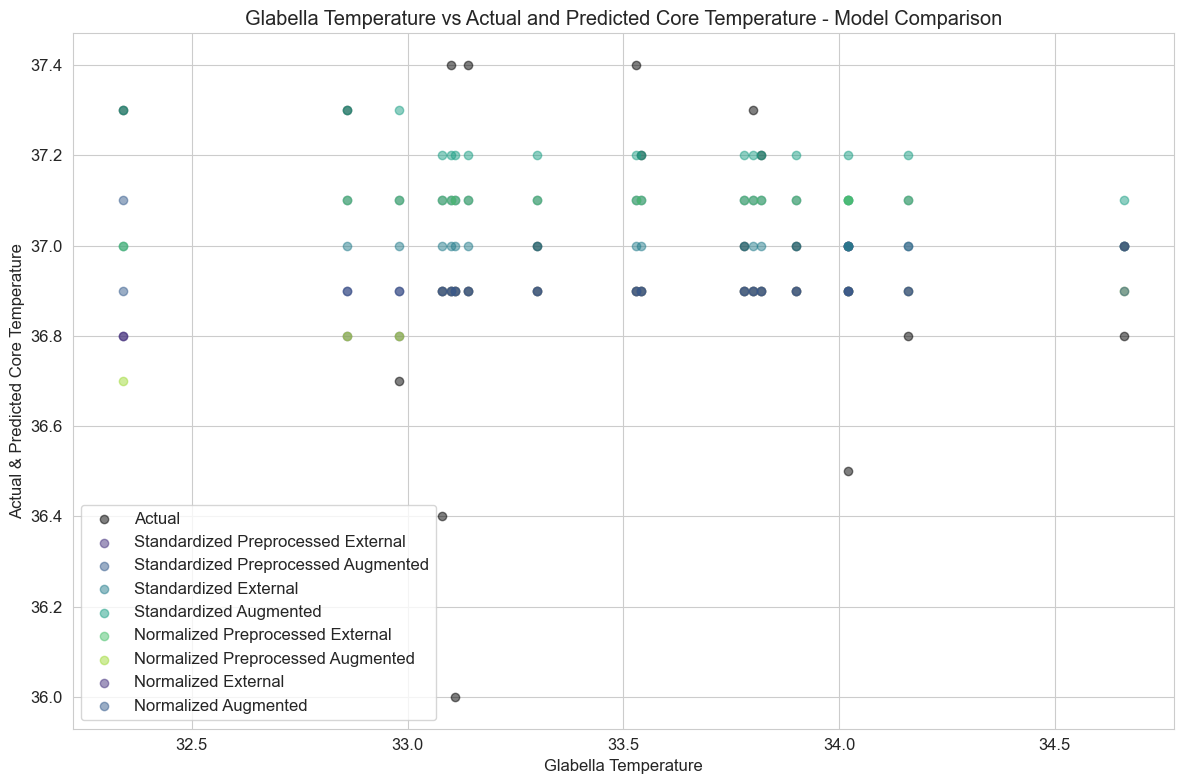

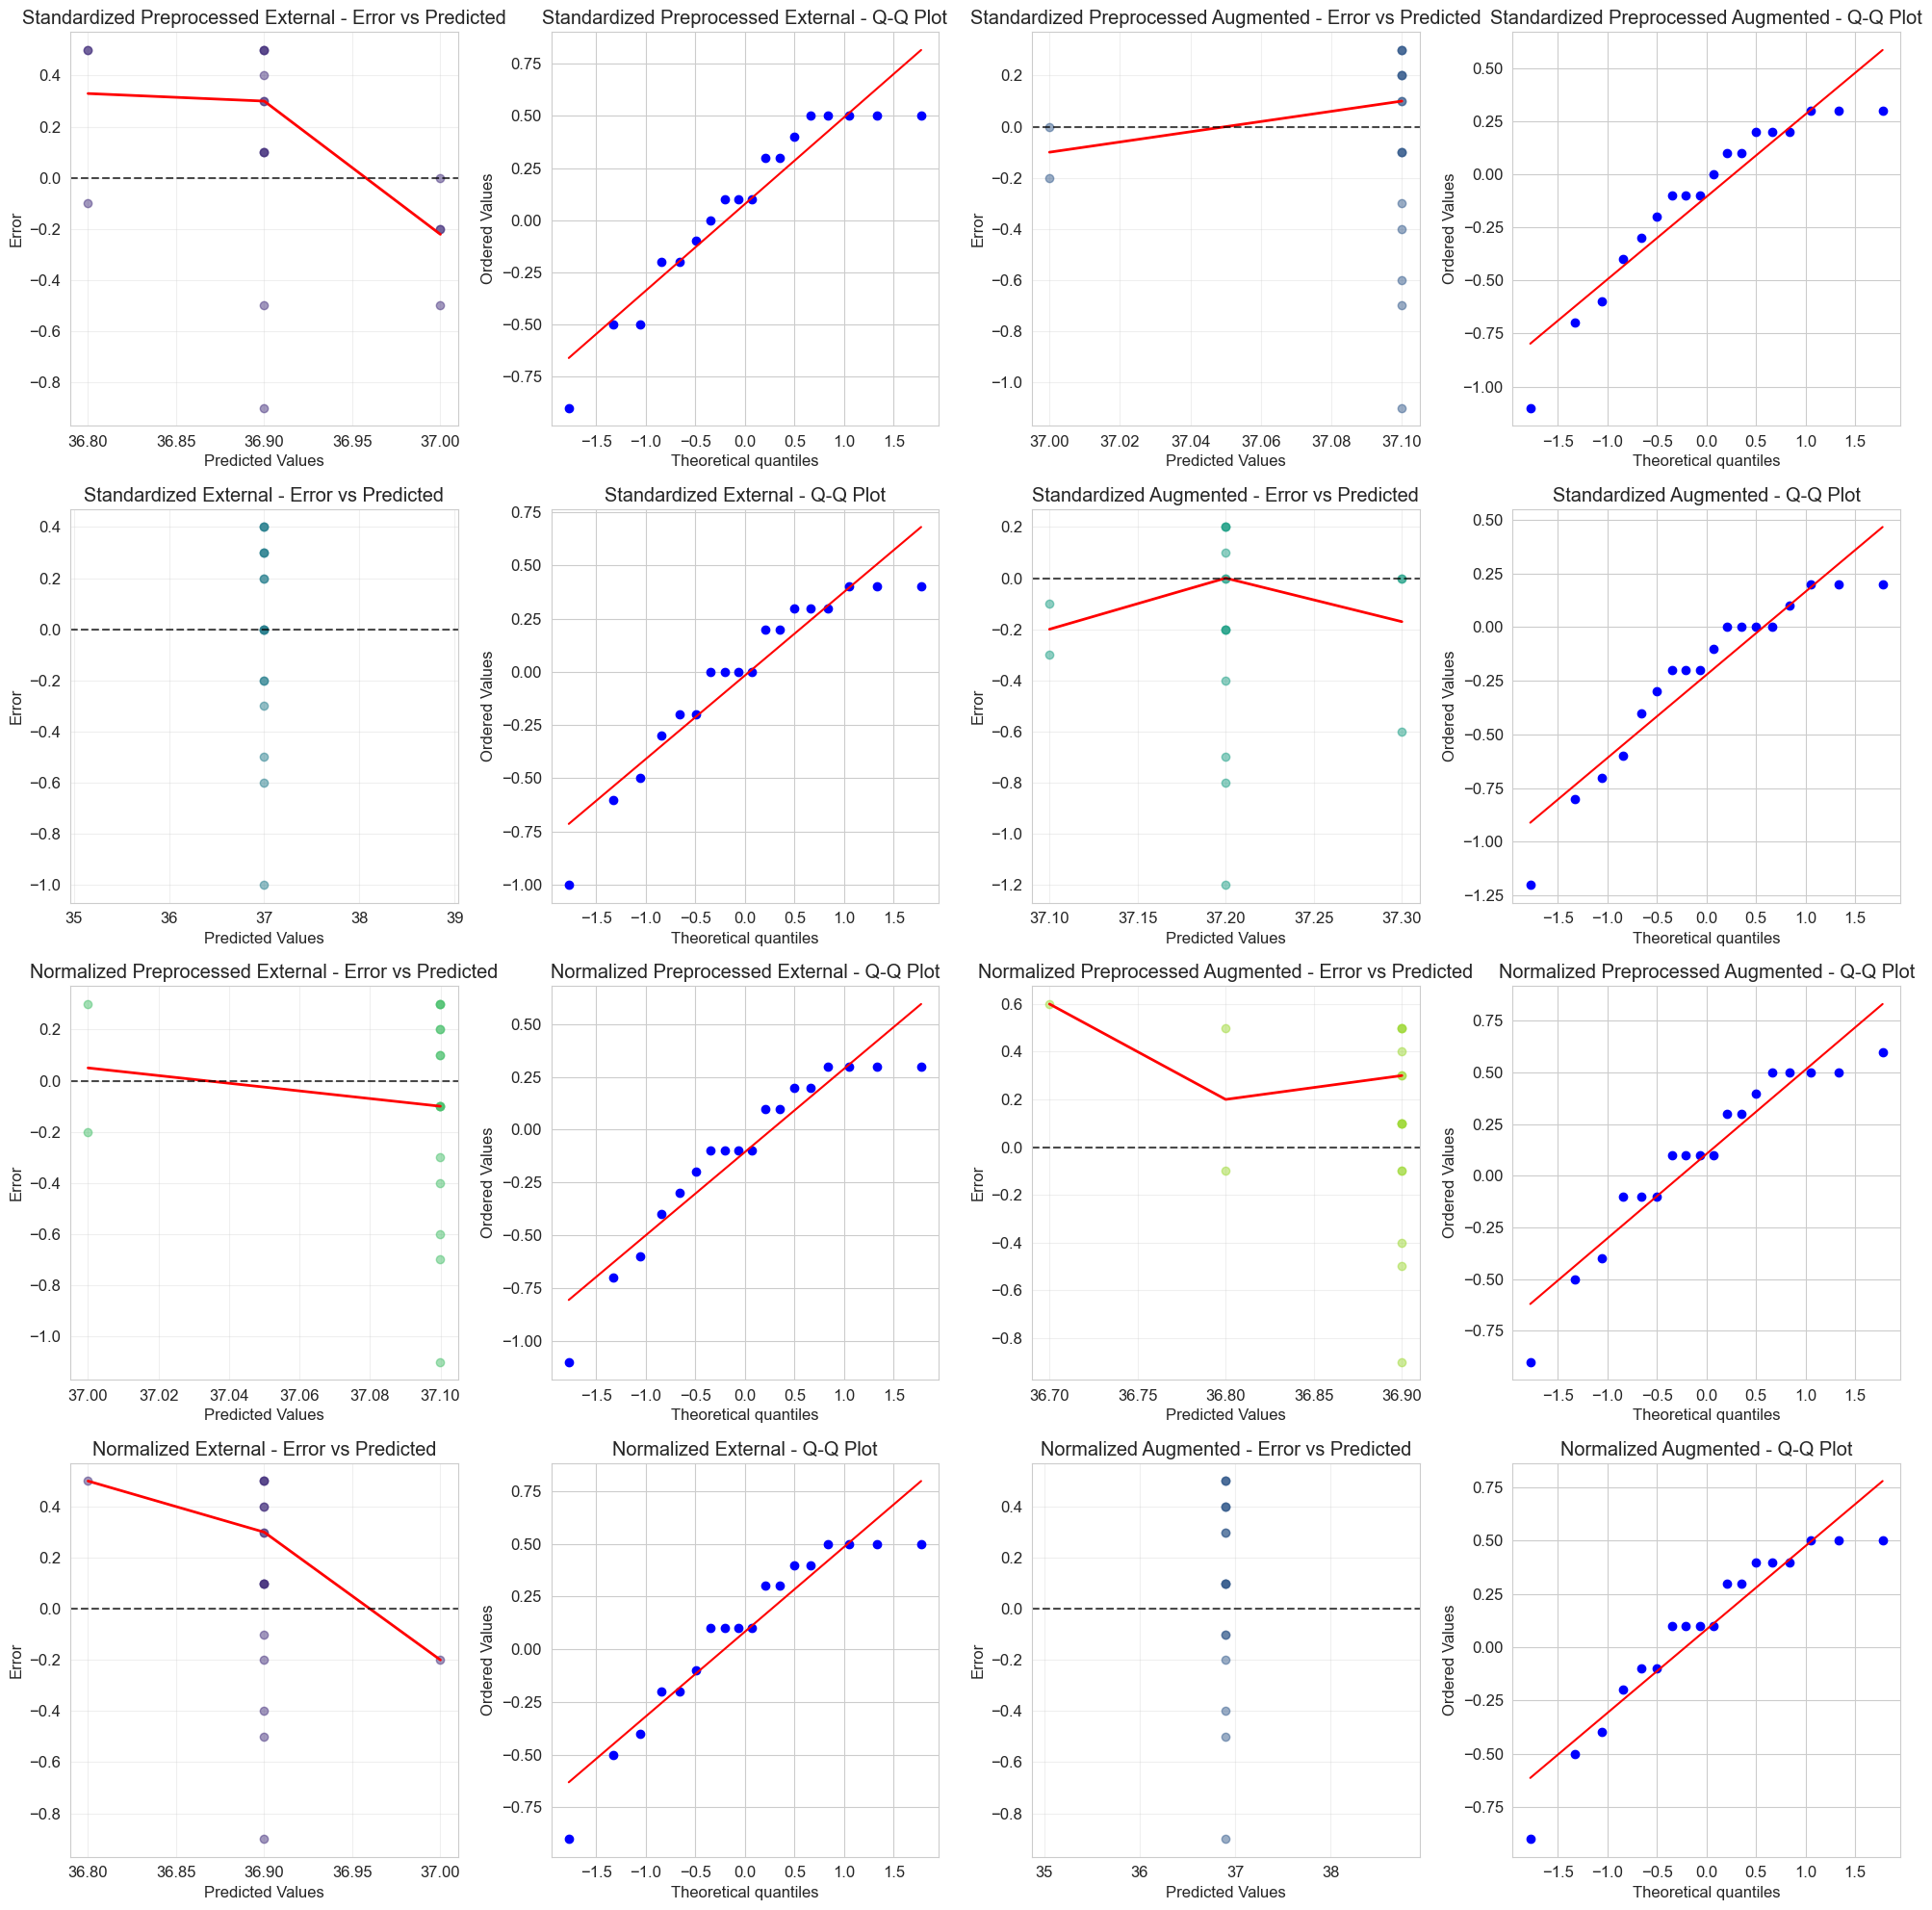

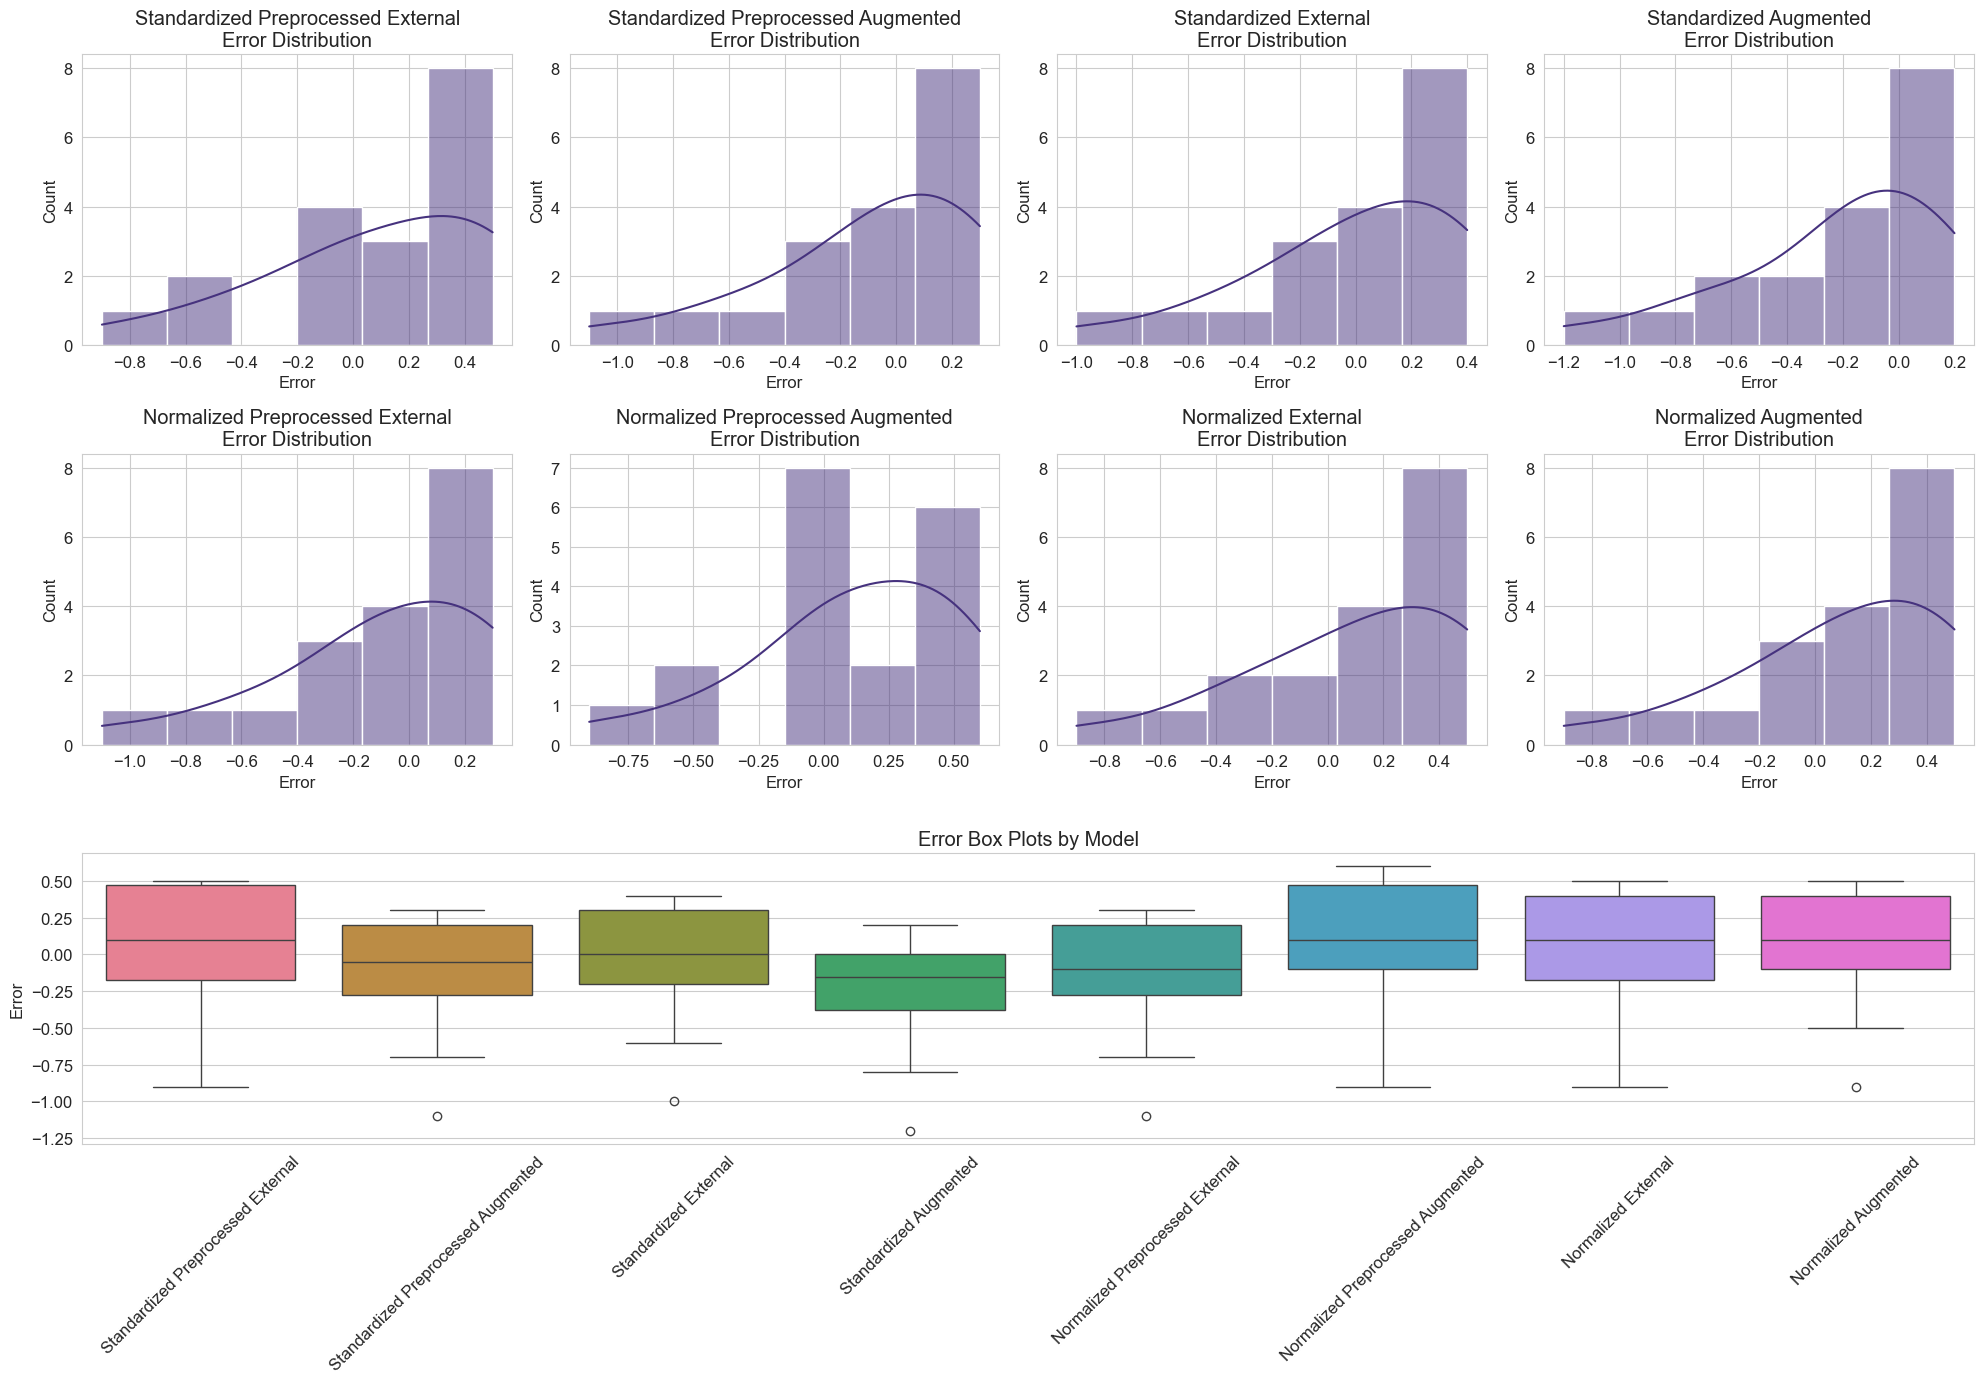

In [10]:
print("\nComparing models:")
dtodmetrics, dtodstats, dtodoverallstats, dtodhomoscedasticity, dtodstats_test_result, dtoderrors = manager.compare_models(test_data[(test_data['Hc'] == 'default_activity') & (test_data['Rc'] == 'default')], ['default_pa', 'default'], 'Tc', to_sort=False, plot=True)

#### Cooled Room


Comparing models:

---------------
 Trial 1 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.461736 0.350098 0.213200 -0.572786
Standardized Preprocessed Augmented 0.462783 0.356459 0.214168 -0.579928
              Standardized External 0.395139 0.328791 0.156135 -0.151814
             Standardized Augmented 0.627383 0.517802 0.393610 -1.903679
   Normalized Preprocessed External 0.443978 0.356482 0.197116 -0.454136
  Normalized Preprocessed Augmented 0.345900 0.301195 0.119647  0.117359
                Normalized External 0.488084 0.377627 0.238226 -0.757405
               Normalized Augmented 0.421360 0.323546 0.177544 -0.309754

---------------
 Trial 2 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.373558 0.319392 0.139546 -0.108974
Standardized Preprocessed Augmented 0.374617 0.319220 0.140338 -0.115270
              Stand

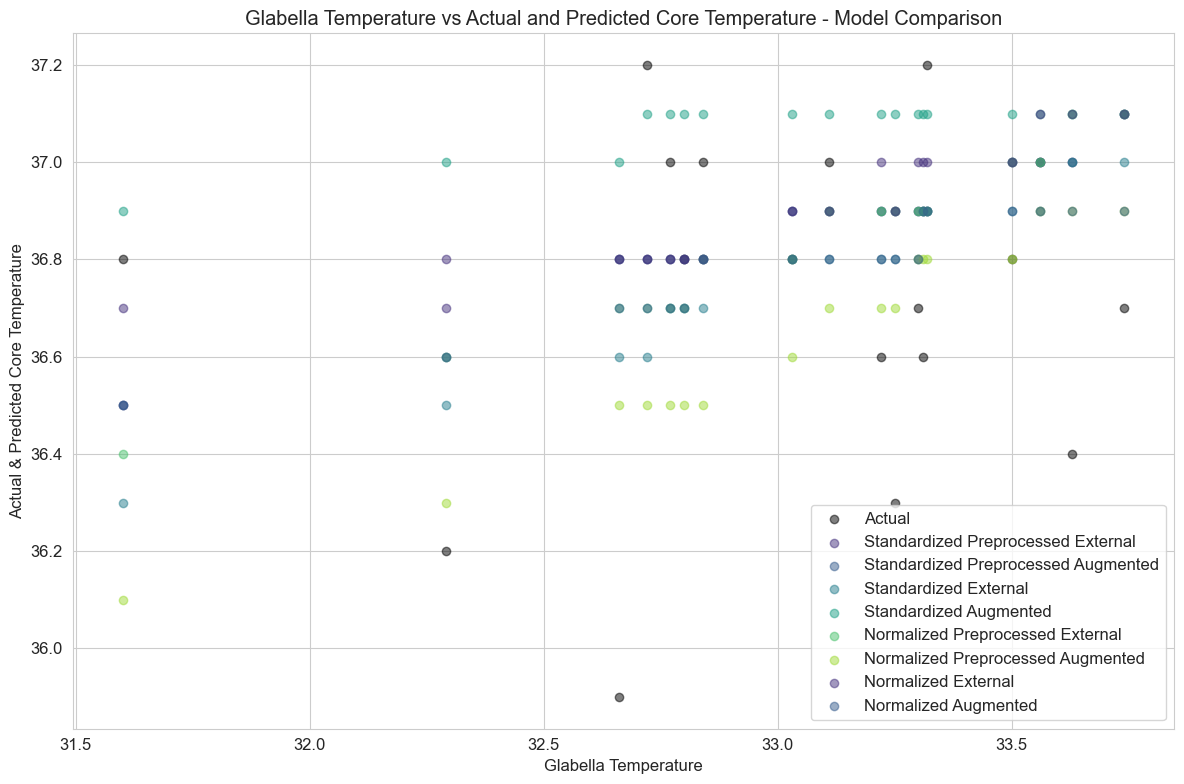

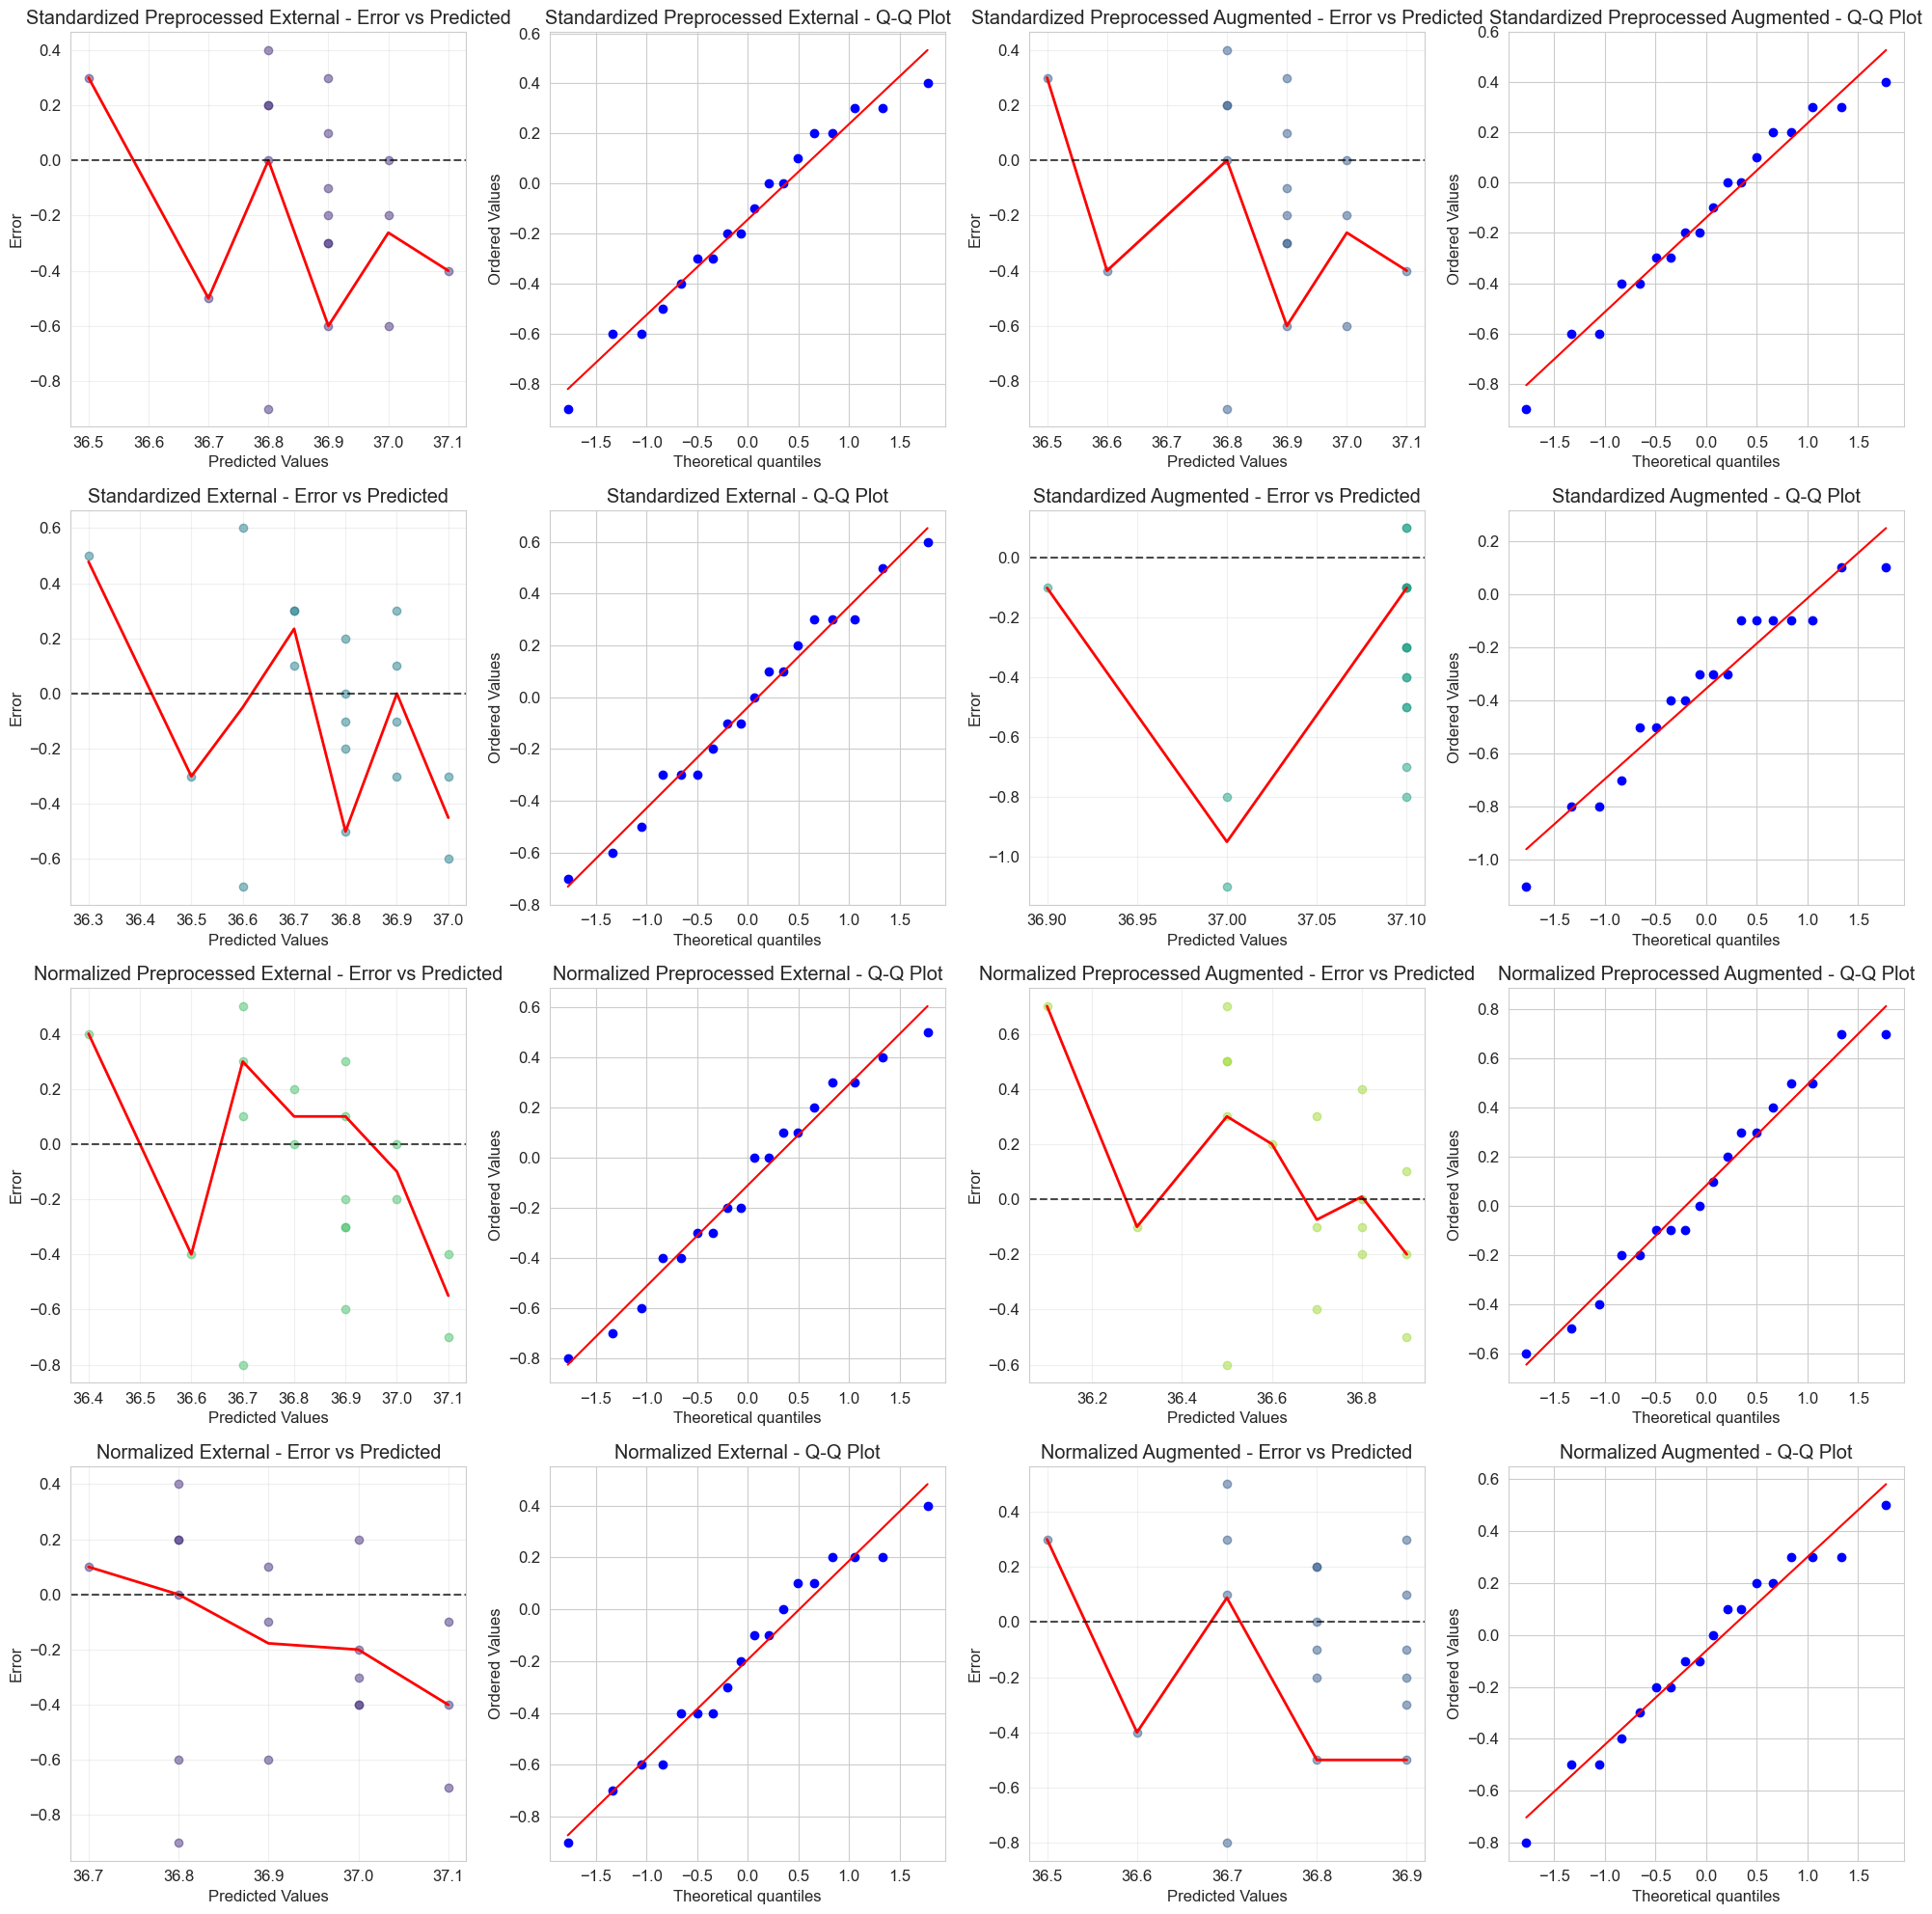

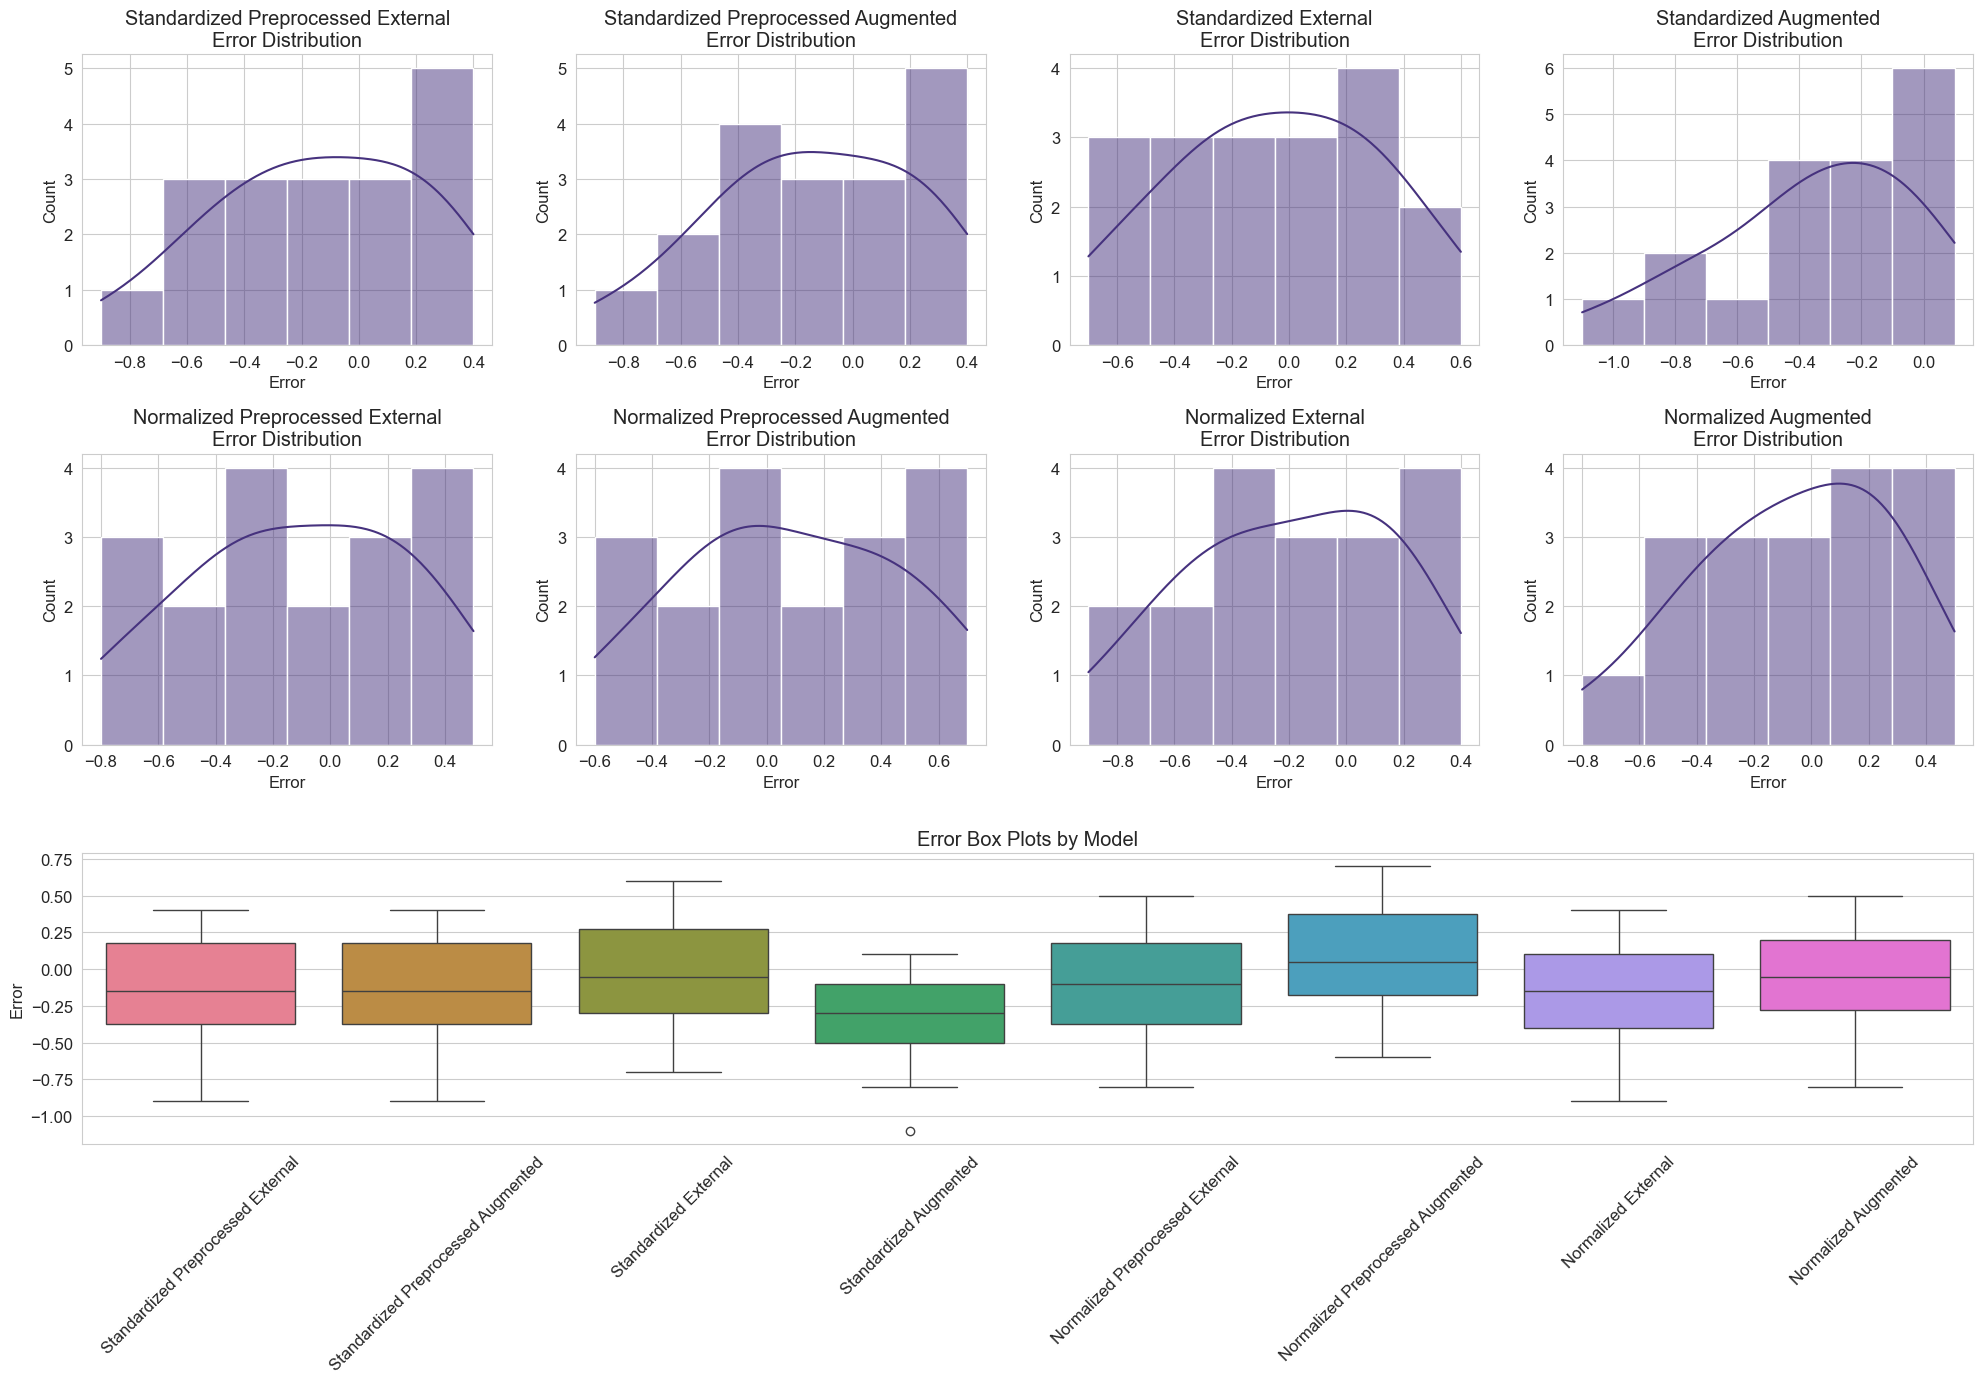

In [11]:
print("\nComparing models:")
dtocmetrics, dtocstats, dtocoverallstats, dtochomoscedasticity, dtocstats_test_result, dtocerrors = manager.compare_models(test_data[(test_data['Hc'] == 'default_activity') & (test_data['Rc'] == 'cooled')], ['default_pa', 'cooled'], 'Tc', to_sort=False, plot=True)

### Rigorous

#### Default Room


Comparing models:

---------------
 Trial 1 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.358882 0.289588 0.128796 -0.016814
Standardized Preprocessed Augmented 0.504358 0.408352 0.254377 -1.008243
              Standardized External 0.477880 0.396648 0.228369 -0.802914
             Standardized Augmented 0.629898 0.530530 0.396771 -2.132404
   Normalized Preprocessed External 0.442089 0.368432 0.195442 -0.542966
  Normalized Preprocessed Augmented 0.428039 0.377894 0.183218 -0.446456
                Normalized External 0.374737 0.330661 0.140428 -0.108643
               Normalized Augmented 0.416586 0.330643 0.173544 -0.370082

---------------
 Trial 2 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.383998 0.316131 0.147455  0.052077
Standardized Preprocessed Augmented 0.528169 0.458402 0.278963 -0.793333
              Stand

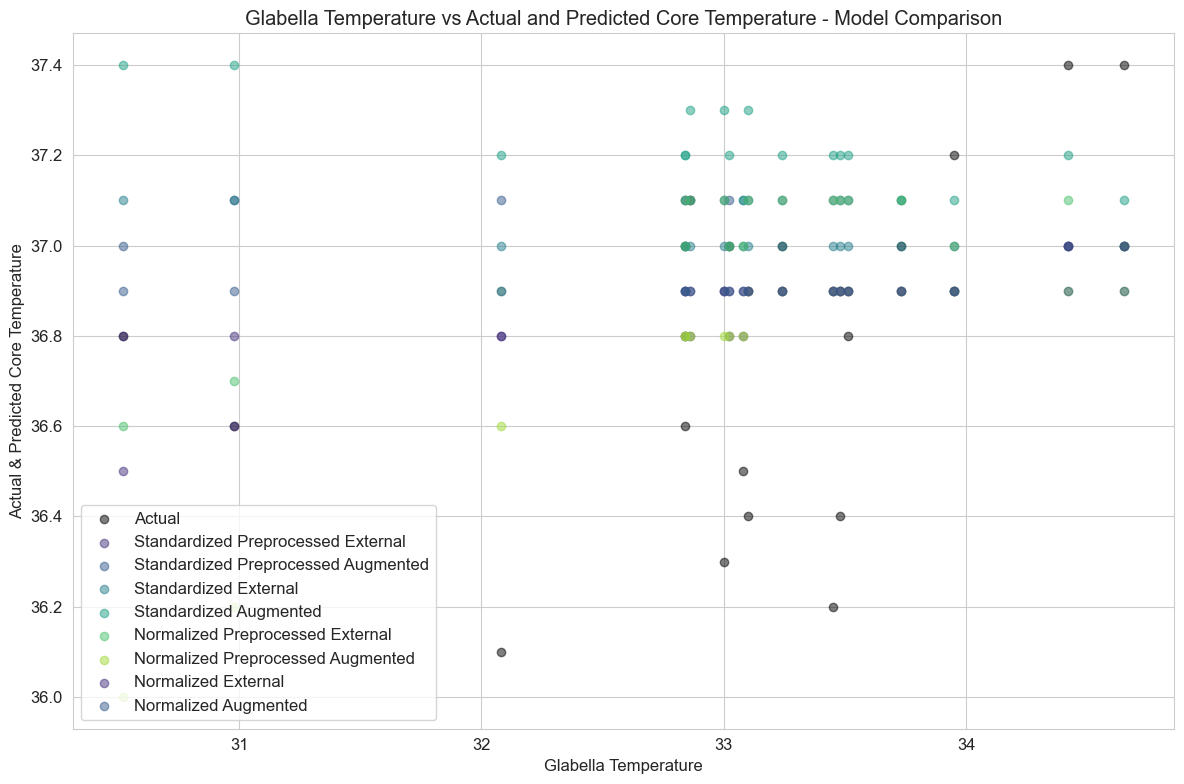

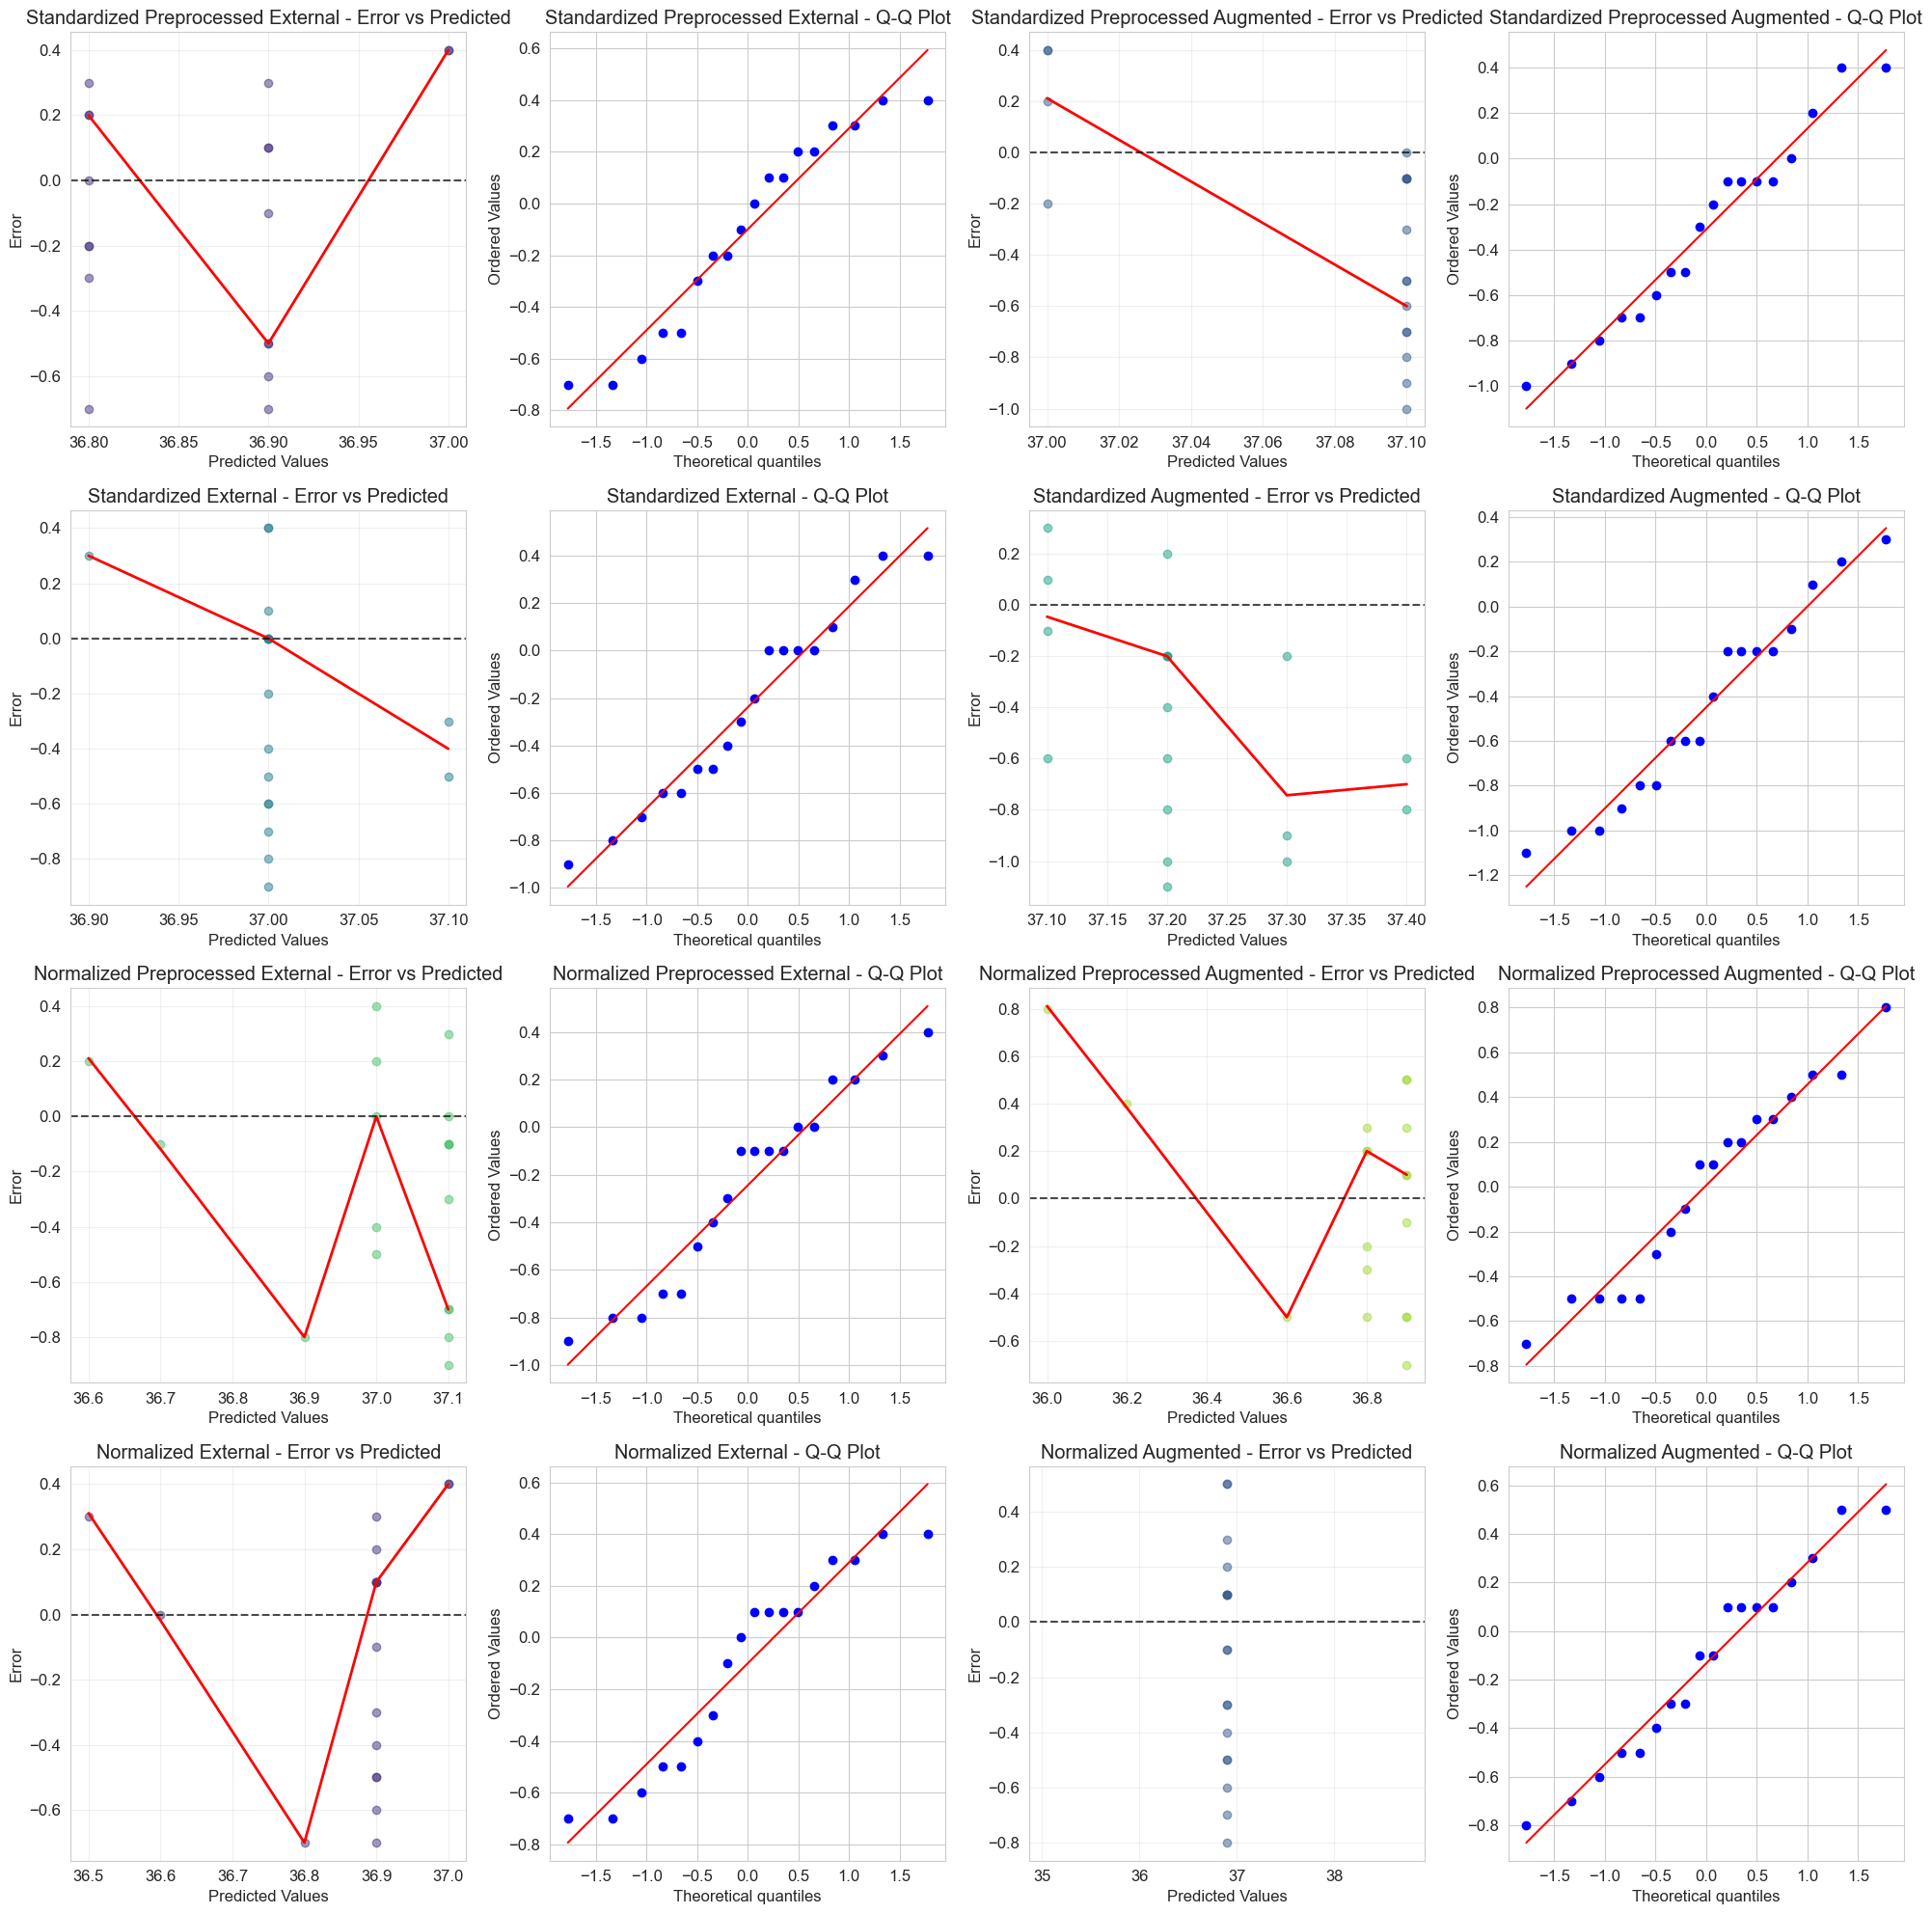

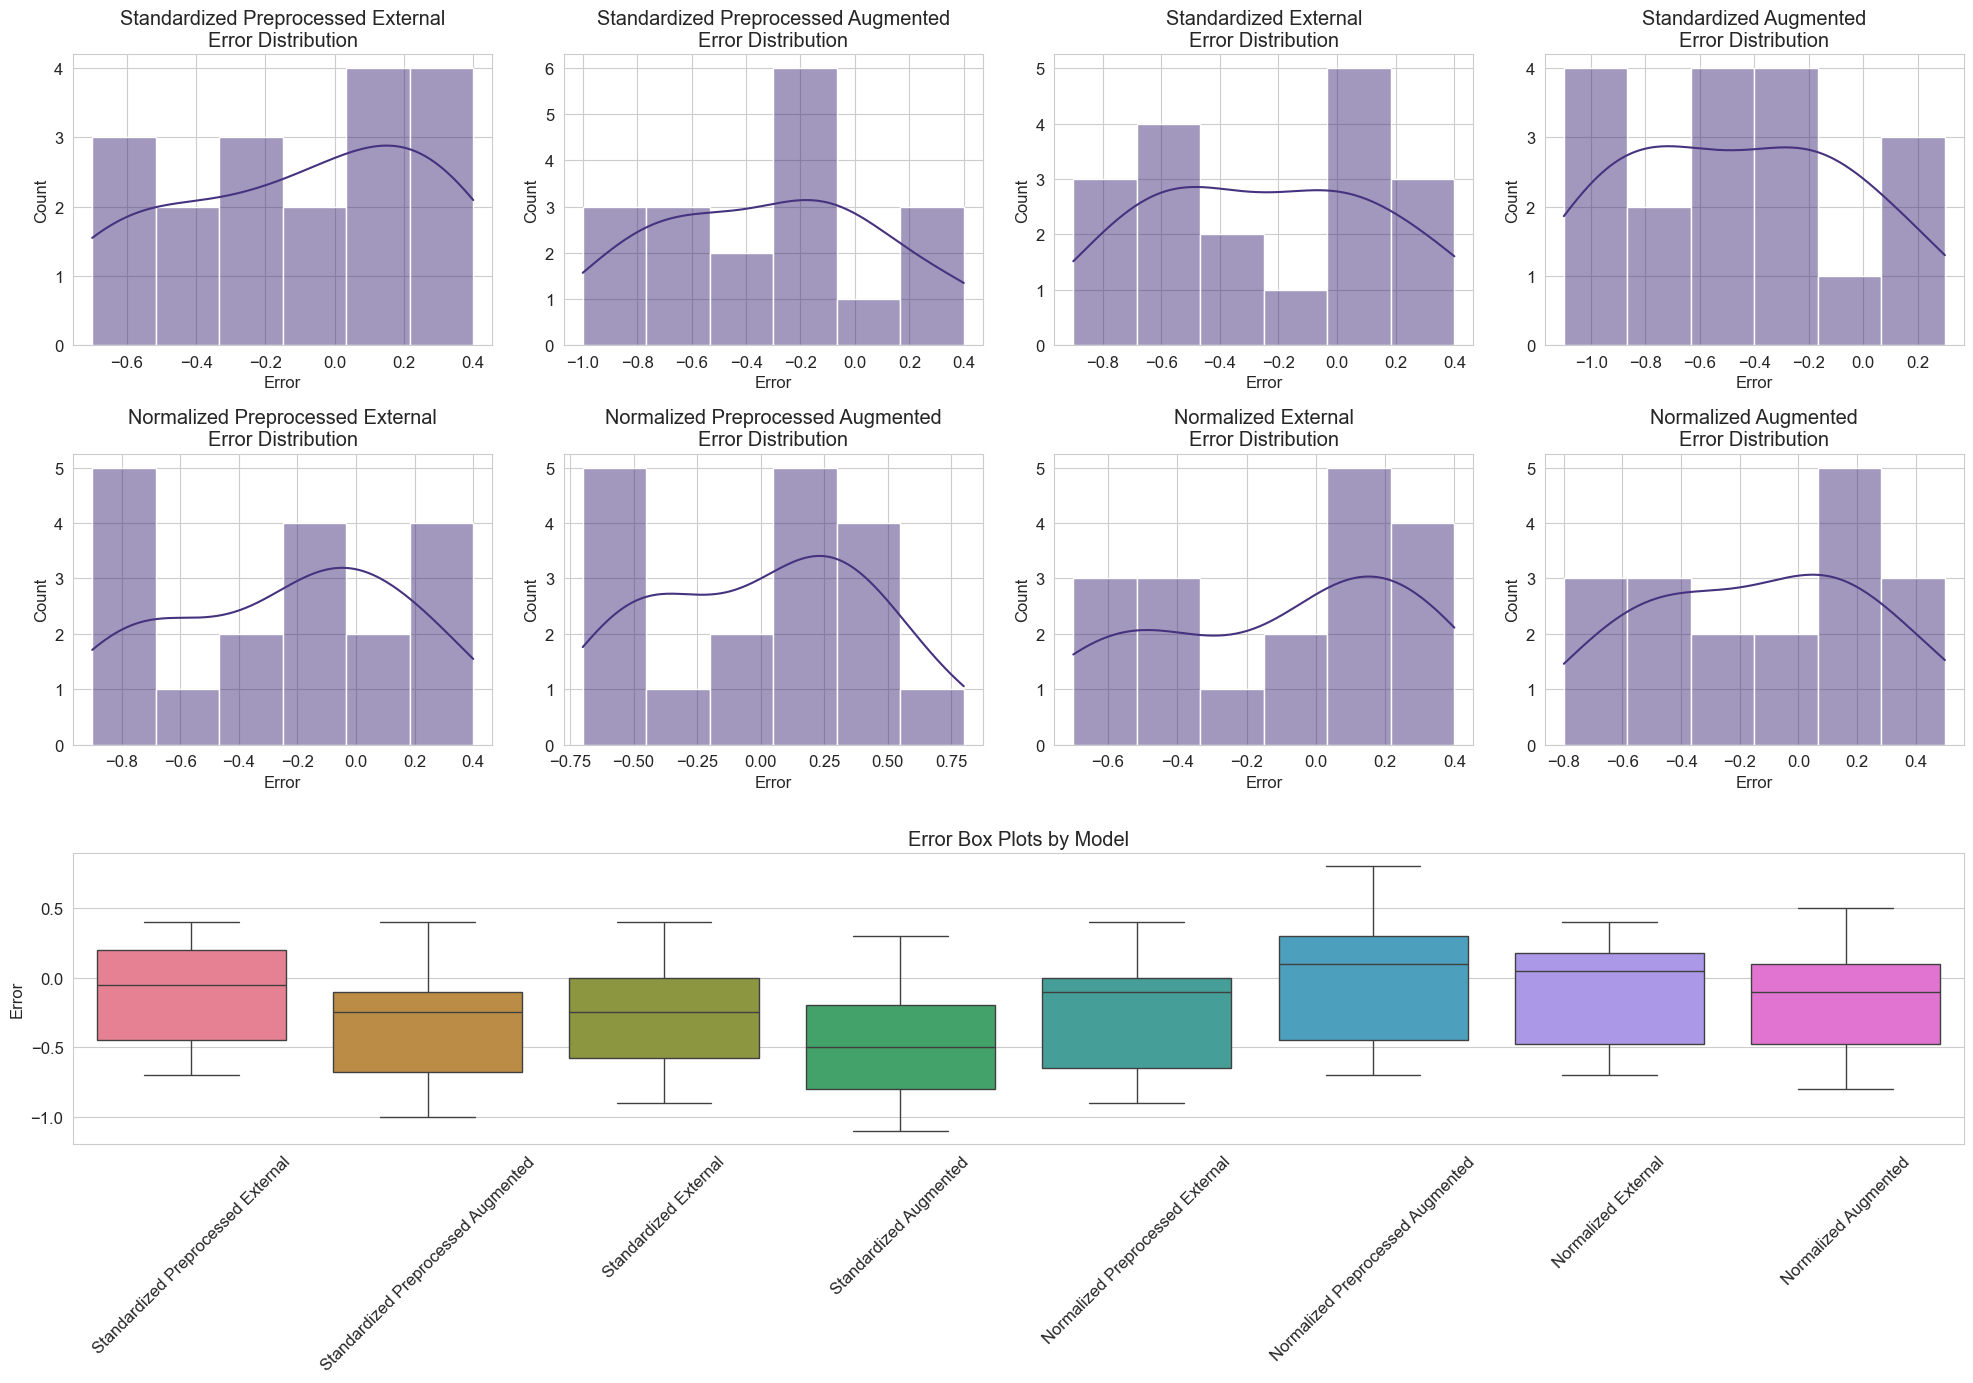

In [12]:

print("\nComparing models:")
rtodmetrics, rtodstats, rtodoverallstats, rtodhomoscedasticity, rtodstats_test_result, rtoderrors = manager.compare_models(test_data[(test_data['Hc'] == 'rigorous_activity') & (test_data['Rc'] == 'default')], ['rigorous_pa', 'default'], 'Tc', to_sort=False, plot=True)

#### Cooled Room


Comparing models:

---------------
 Trial 1 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.686207 0.564807 0.470880 -0.210835
Standardized Preprocessed Augmented 0.679698 0.560333 0.461990 -0.187974
              Standardized External 0.681551 0.587616 0.464511 -0.194457
             Standardized Augmented 0.795589 0.612013 0.632962 -0.627617
   Normalized Preprocessed External 0.684889 0.574412 0.469073 -0.206188
  Normalized Preprocessed Augmented 0.771777 0.709455 0.595640 -0.531646
                Normalized External 0.697422 0.548746 0.486398 -0.250738
               Normalized Augmented 0.669565 0.555858 0.448317 -0.152814

---------------
 Trial 2 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.657722 0.580509 0.432598  0.016823
Standardized Preprocessed Augmented 0.655249 0.581145 0.429352  0.024201
              Stand

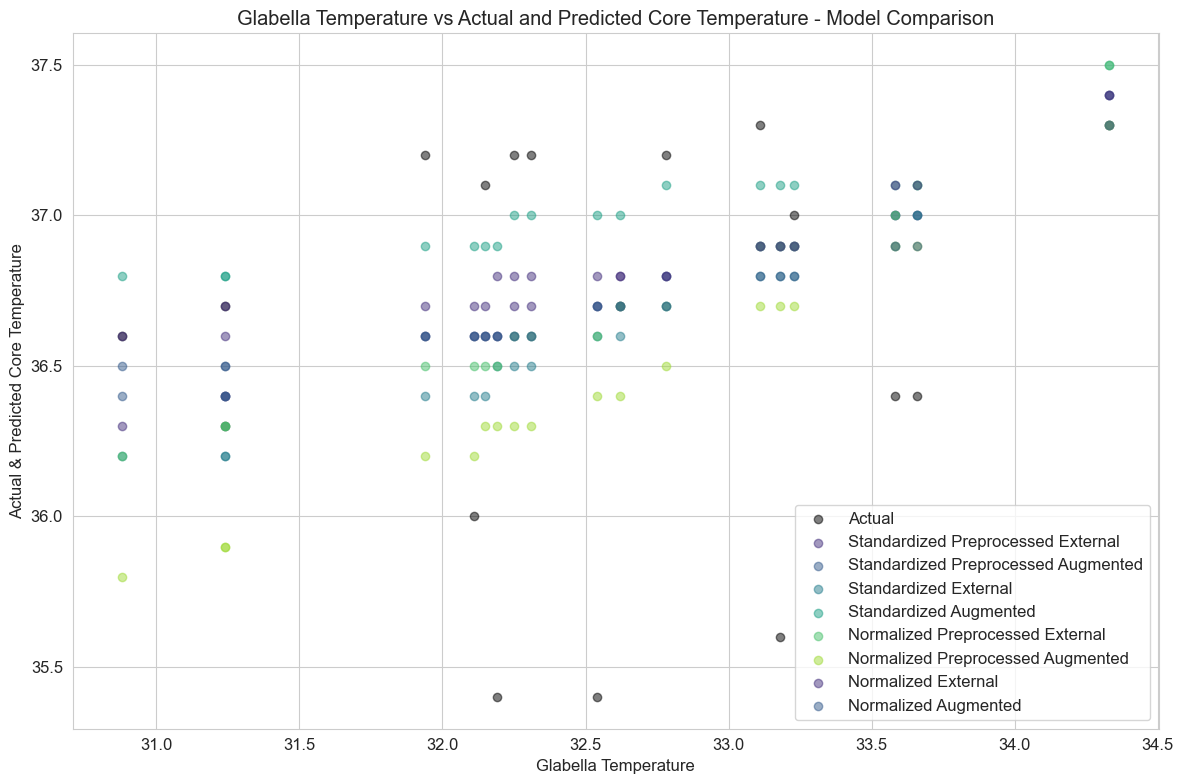

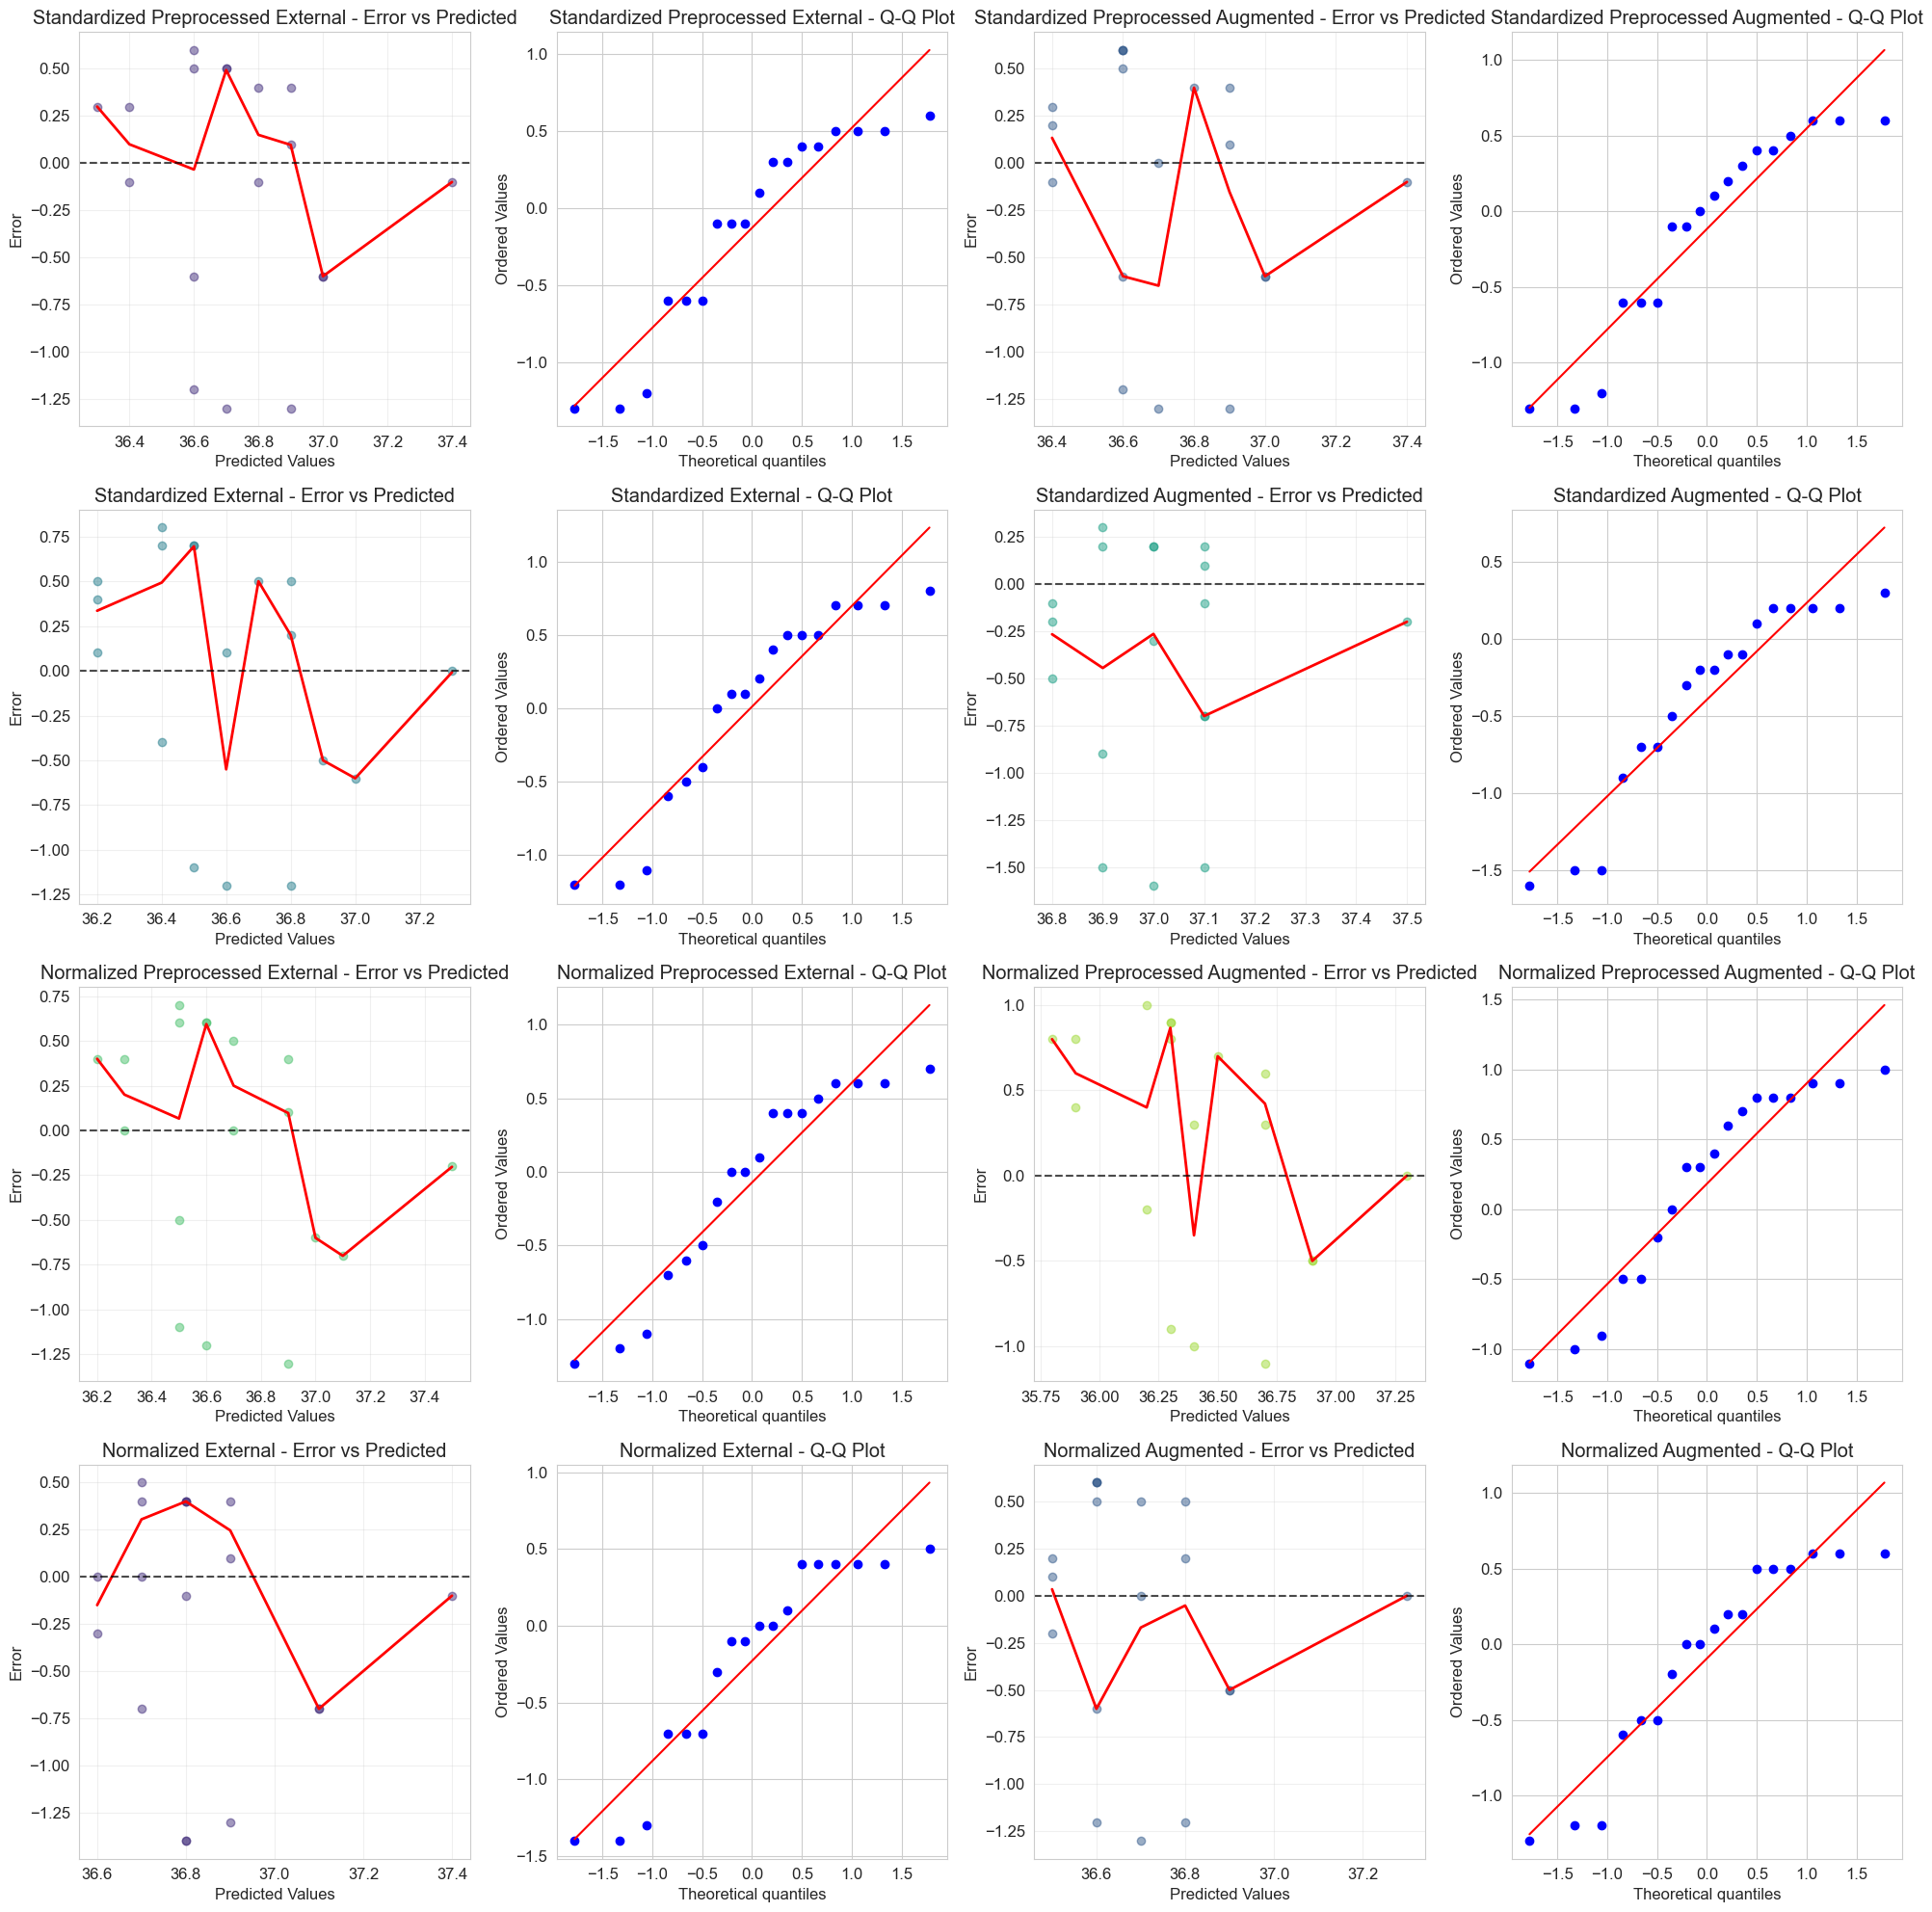

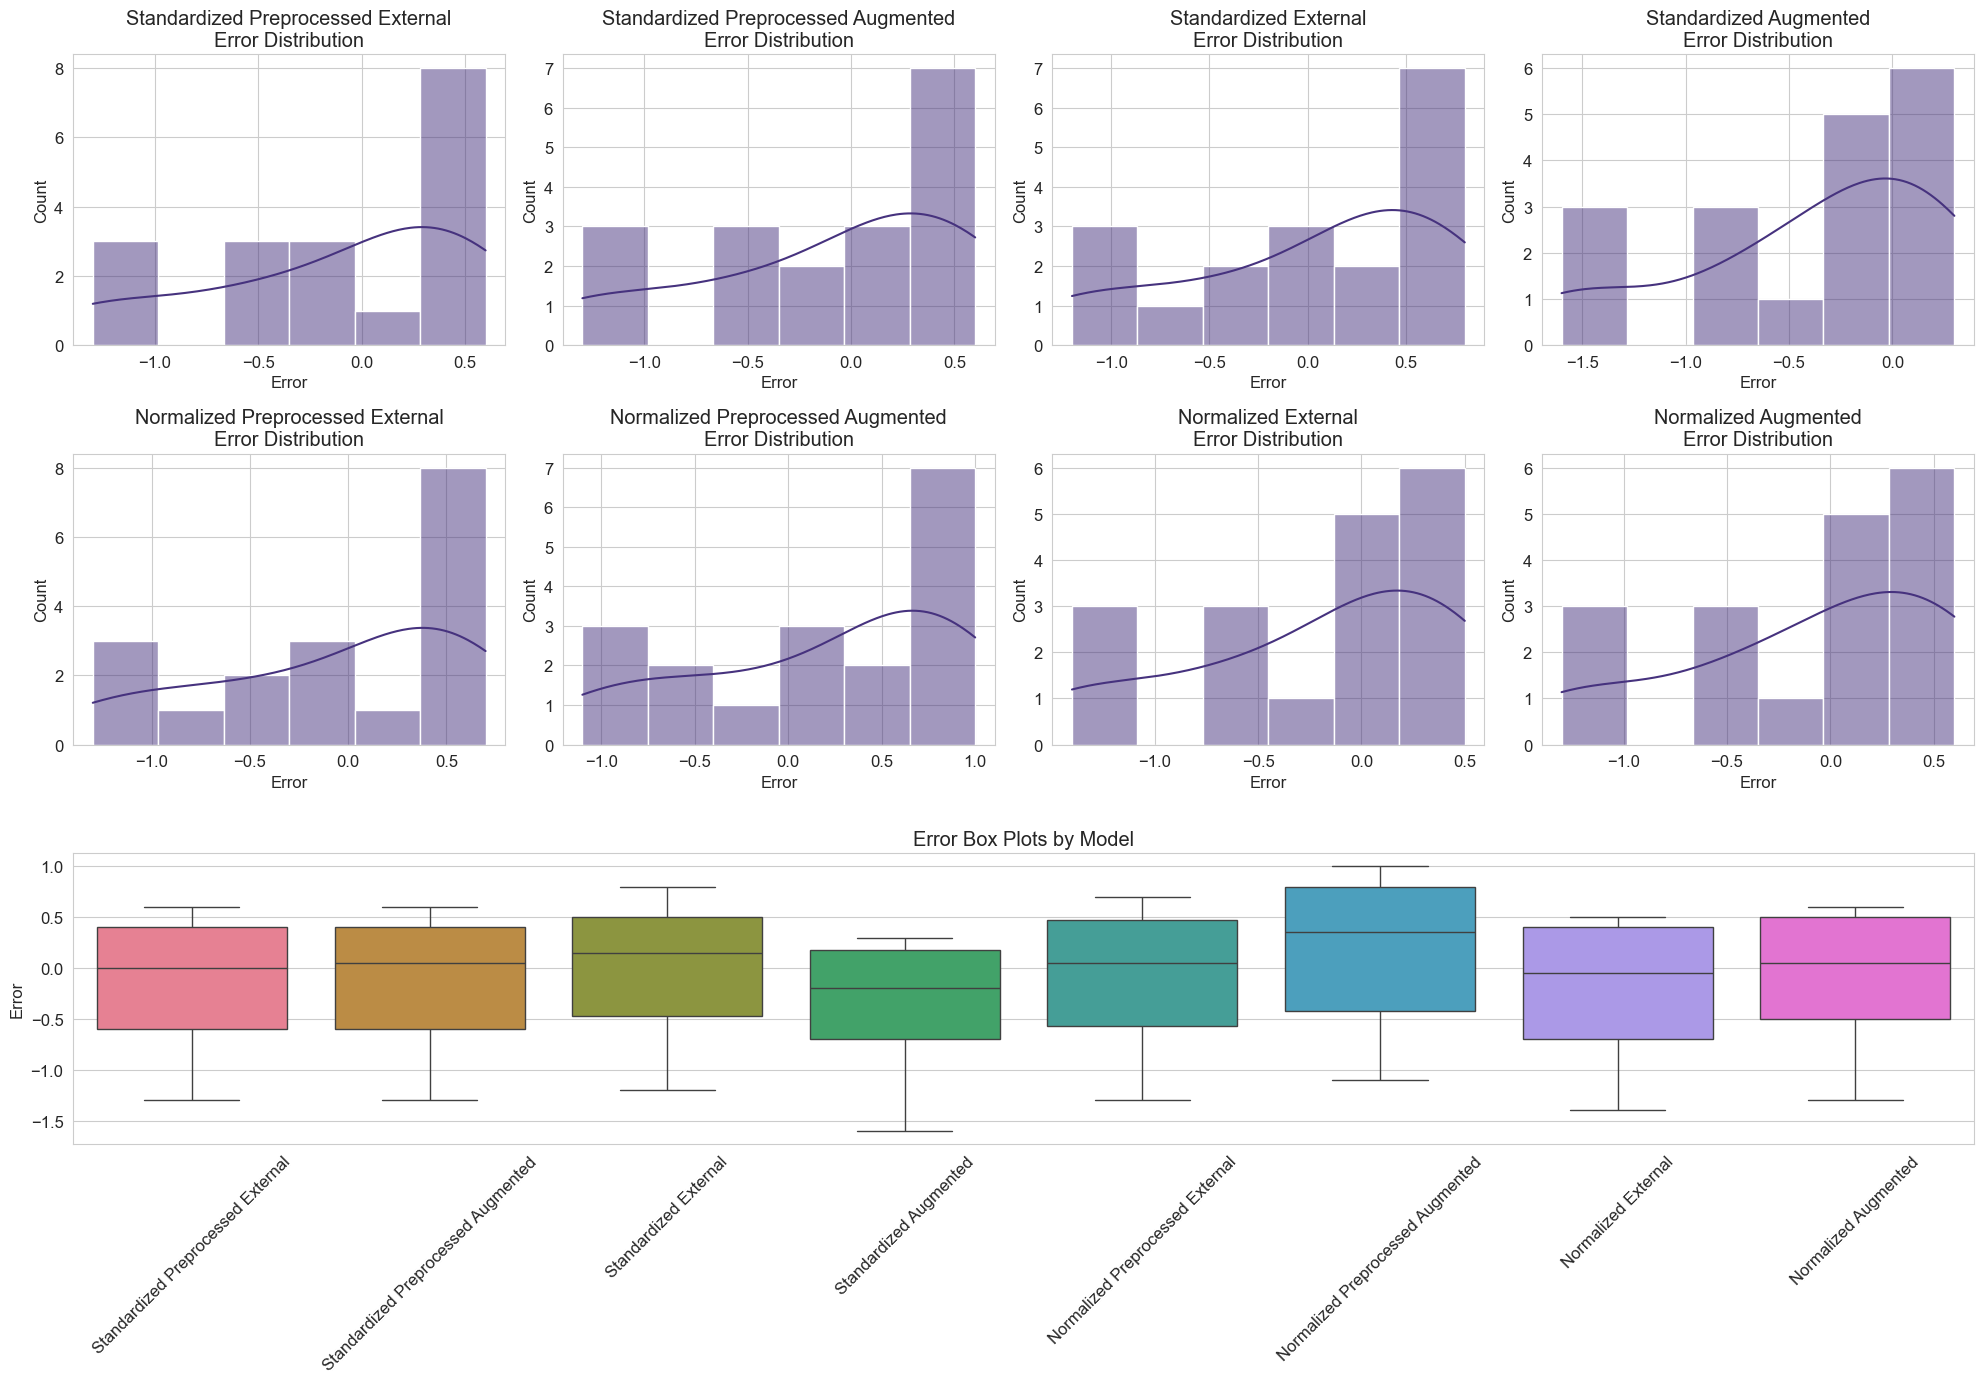

In [13]:
print("\nComparing models:")
rtocmetrics, rtocstats, rtocoverallstats, rtochomoscedasticity, rtocstats_test_result, rtocerrors = manager.compare_models(test_data[(test_data['Hc'] == 'rigorous_activity') & (test_data['Rc'] == 'cooled')], ['rigorous_pa', 'cooled'], 'Tc', to_sort=False, plot=True)

### Cooled

#### Default Room


Comparing models:

---------------
 Trial 1 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.802557 0.506697 0.644098 -0.434873
Standardized Preprocessed Augmented 0.960516 0.692151 0.922591 -1.055277
              Standardized External 0.945106 0.652645 0.893226 -0.989859
             Standardized Augmented 1.109454 0.868085 1.230887 -1.742076
   Normalized Preprocessed External 0.821870 0.537809 0.675470 -0.504760
  Normalized Preprocessed Augmented 0.652823 0.466799 0.426177  0.050595
                Normalized External 0.774872 0.482532 0.600427 -0.337584
               Normalized Augmented 0.869277 0.580347 0.755643 -0.683364

---------------
 Trial 2 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.732480 0.473253 0.536526 -0.291106
Standardized Preprocessed Augmented 0.877190 0.609105 0.769462 -0.851647
              Stand

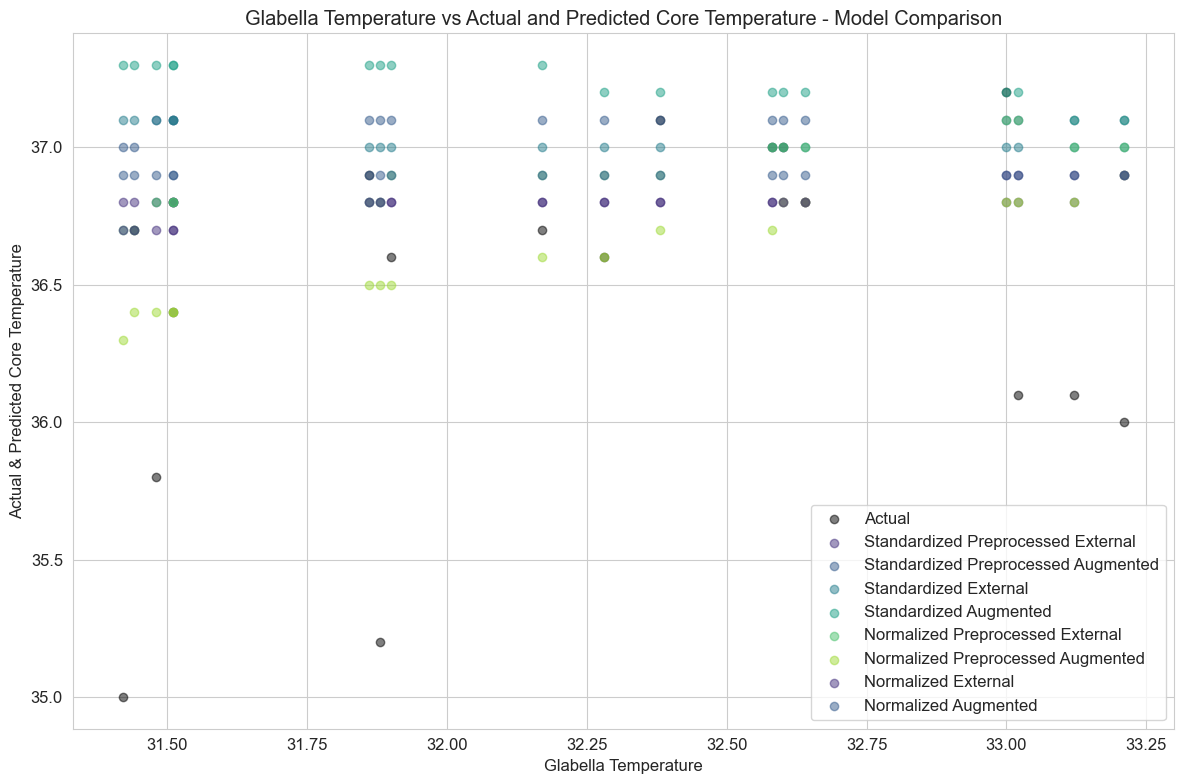

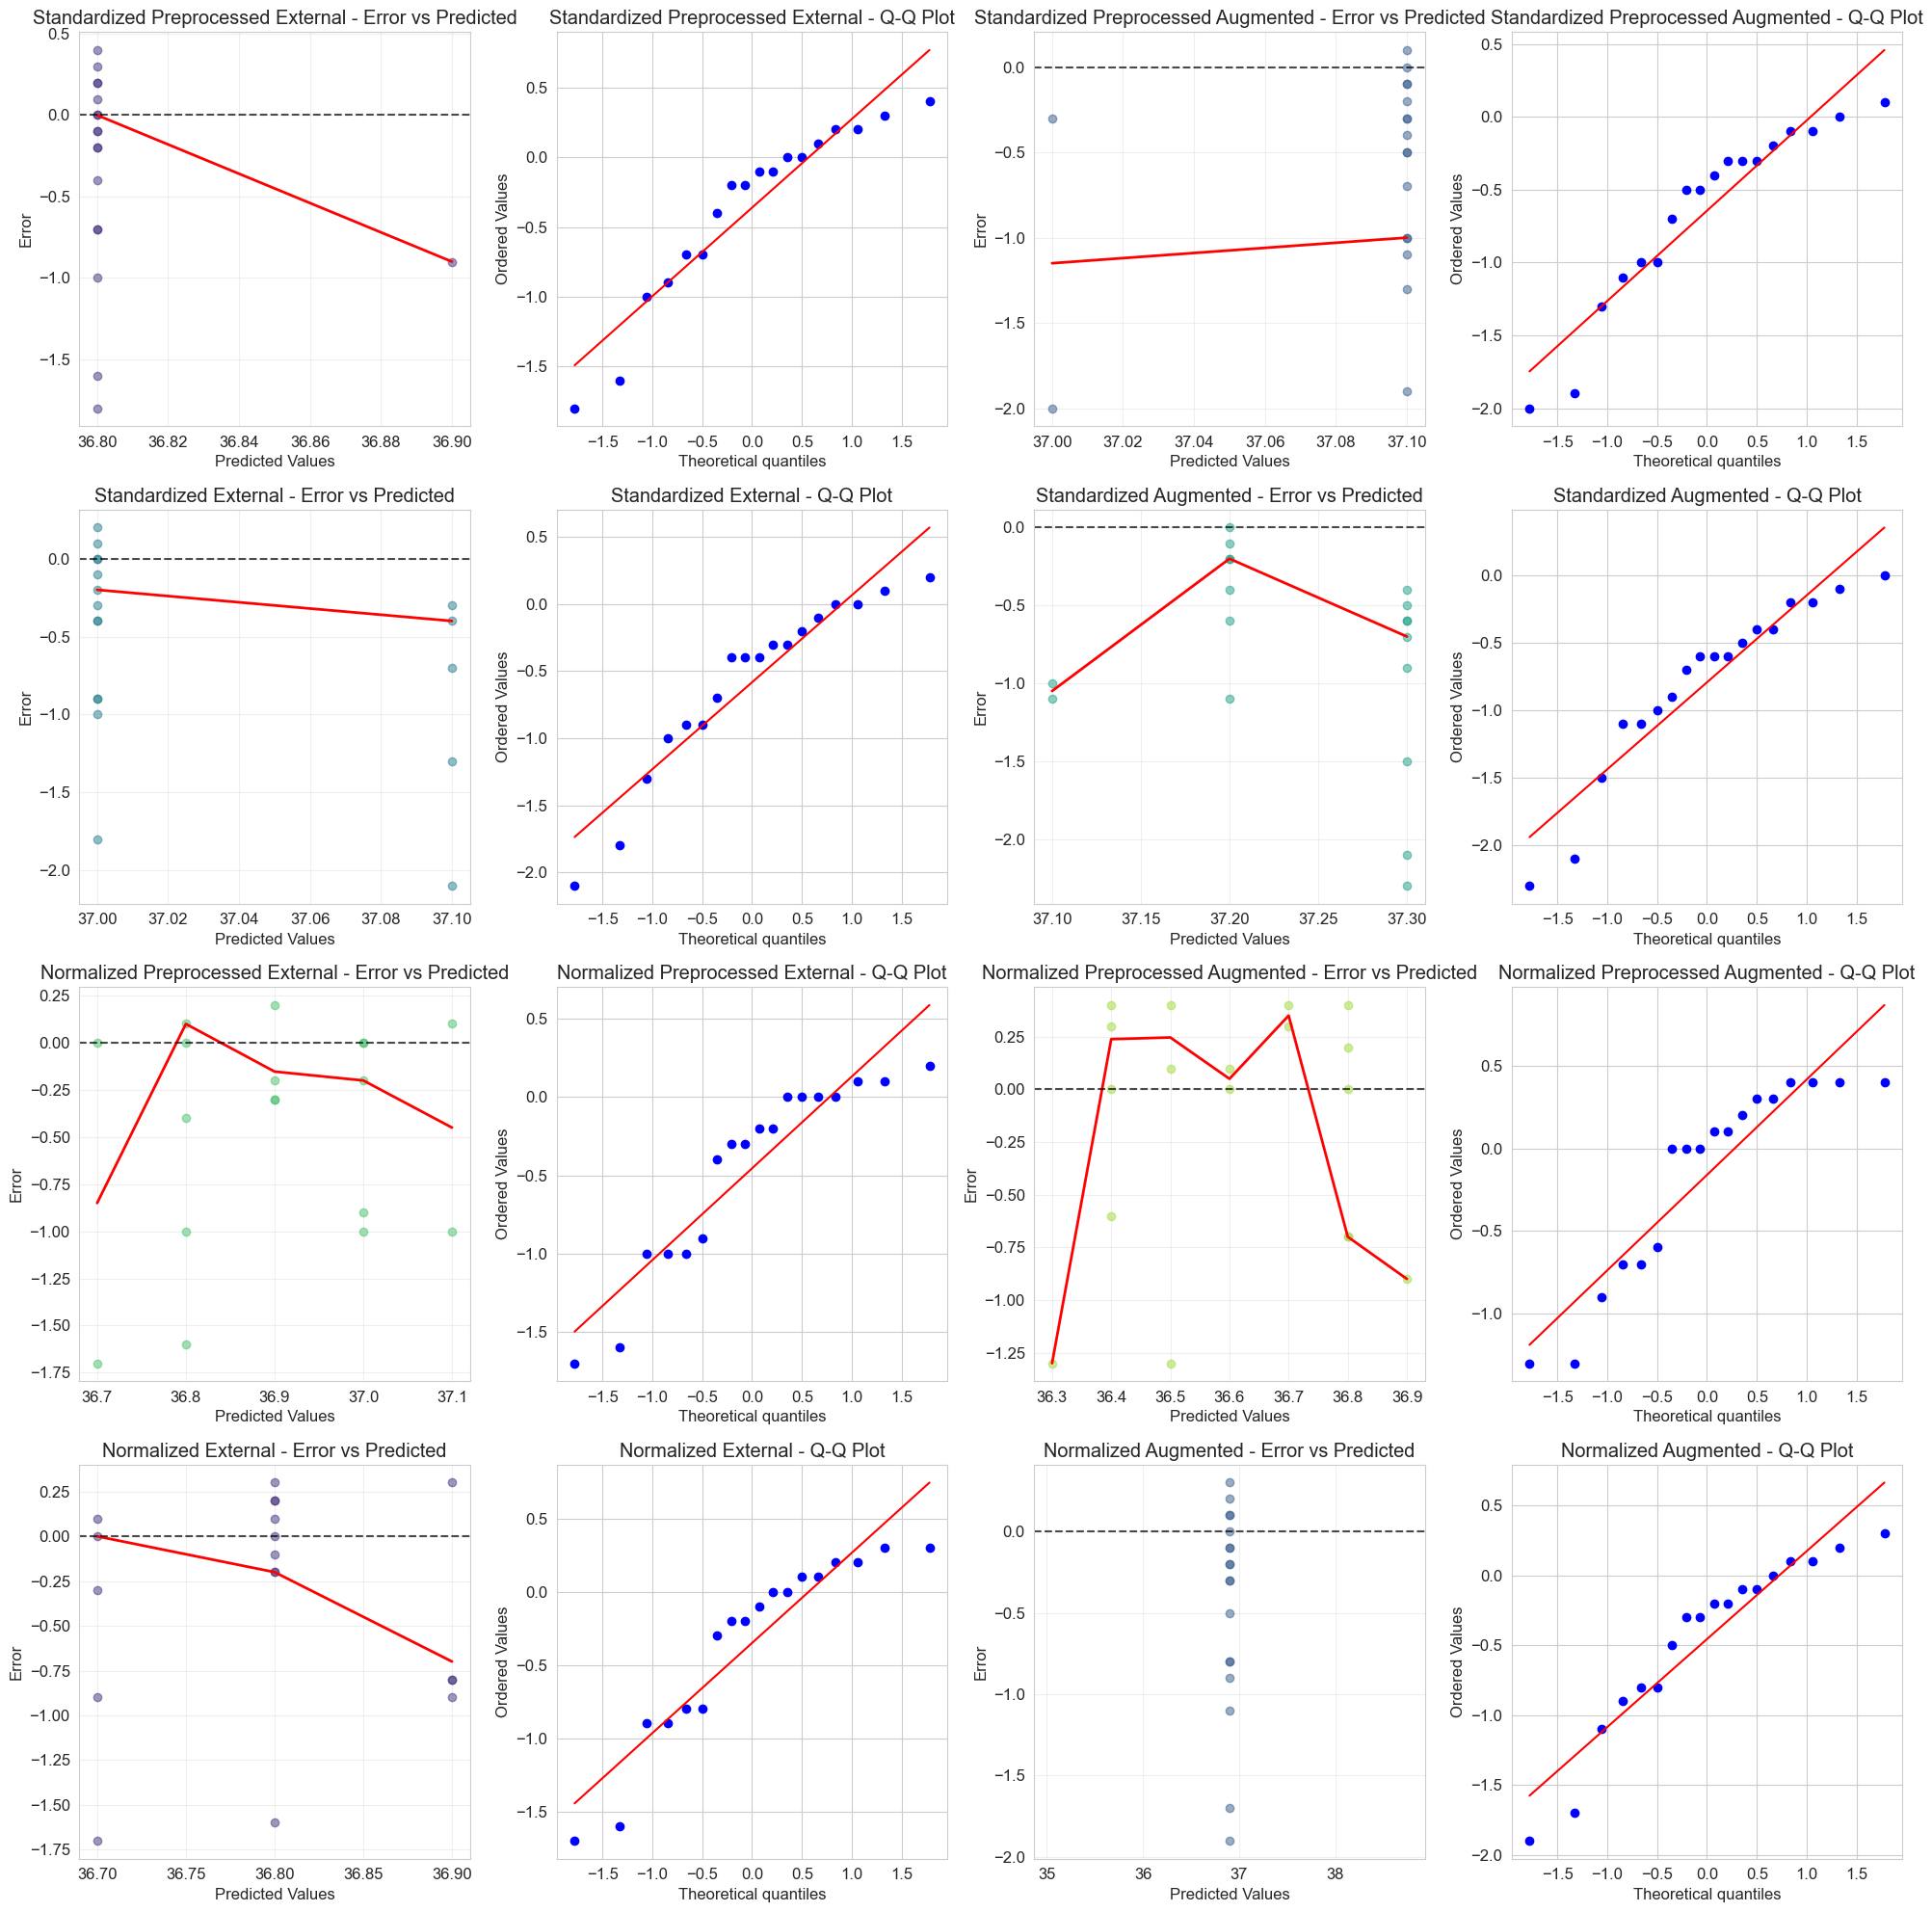

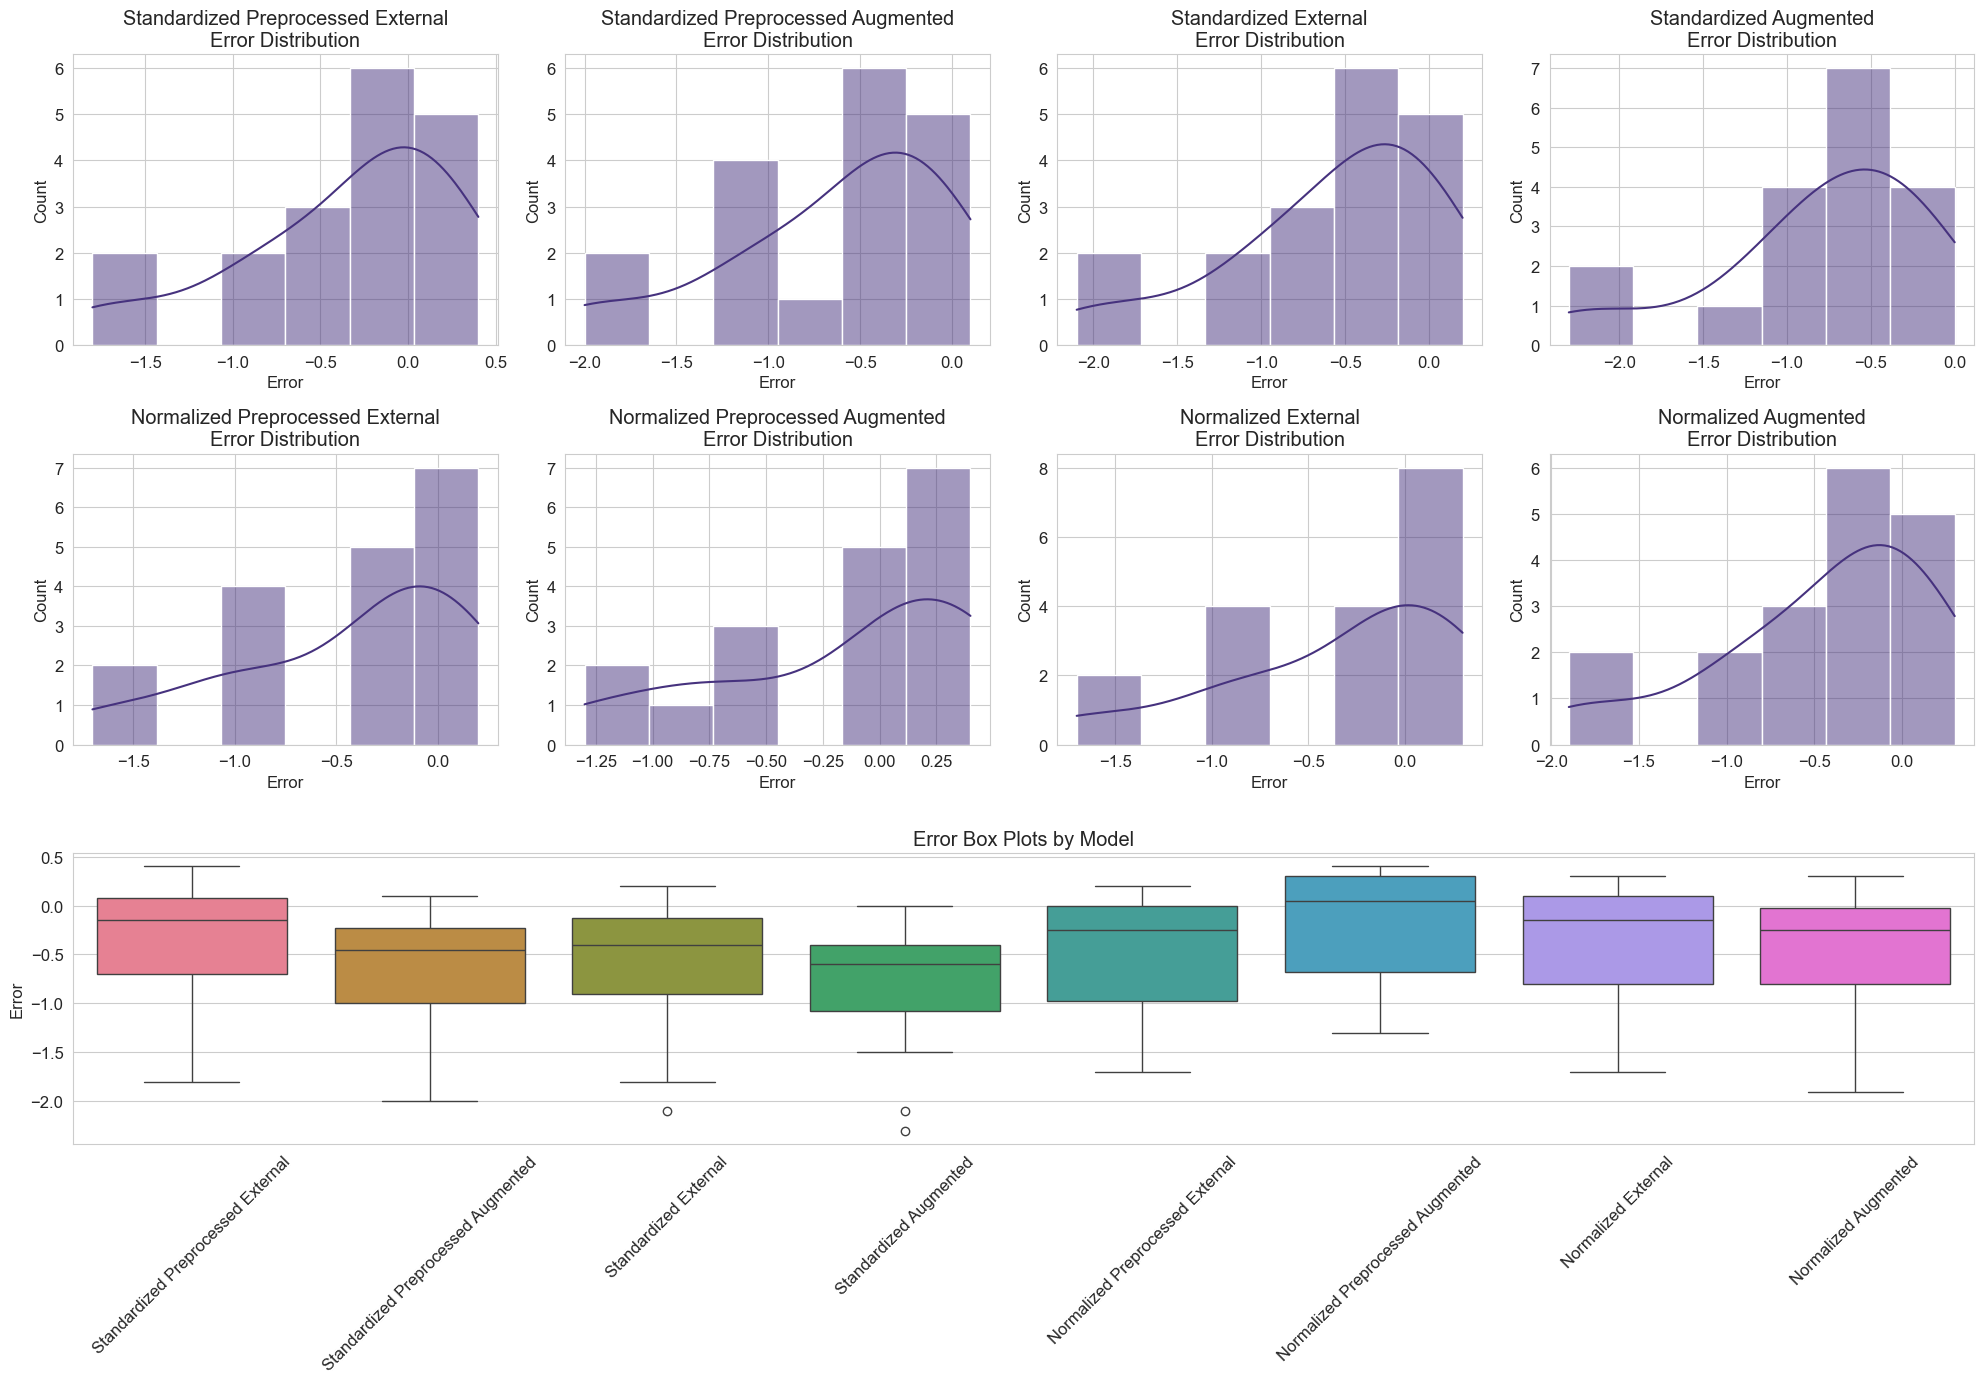

In [14]:
print("\nComparing models:")
ctodmetrics, ctodstats, ctodoverallstats, ctodhomoscedasticity, ctodstats_test_result, ctoderrors = manager.compare_models(test_data[(test_data['Hc'] == 'cooled') & (test_data['Rc'] == 'default')], ['cooled', 'default'], 'Tc', to_sort=False, plot=True)

#### Cooled Room


Comparing models:

---------------
 Trial 1 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.851512 0.593373 0.725072  0.198570
Standardized Preprocessed Augmented 0.887663 0.601010 0.787945  0.129075
              Standardized External 0.906953 0.619374 0.822563  0.090811
             Standardized Augmented 1.094339 0.669532 1.197577 -0.323696
   Normalized Preprocessed External 0.706669 0.552770 0.499381  0.448028
  Normalized Preprocessed Augmented 0.693333 0.583269 0.480711  0.468665
                Normalized External 0.843466 0.567594 0.711435  0.213643
               Normalized Augmented 0.881068 0.598374 0.776282  0.141967

---------------
 Trial 2 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.823099 0.668721 0.677491  0.104637
Standardized Preprocessed Augmented 0.840022 0.671049 0.705637  0.067440
              Stand

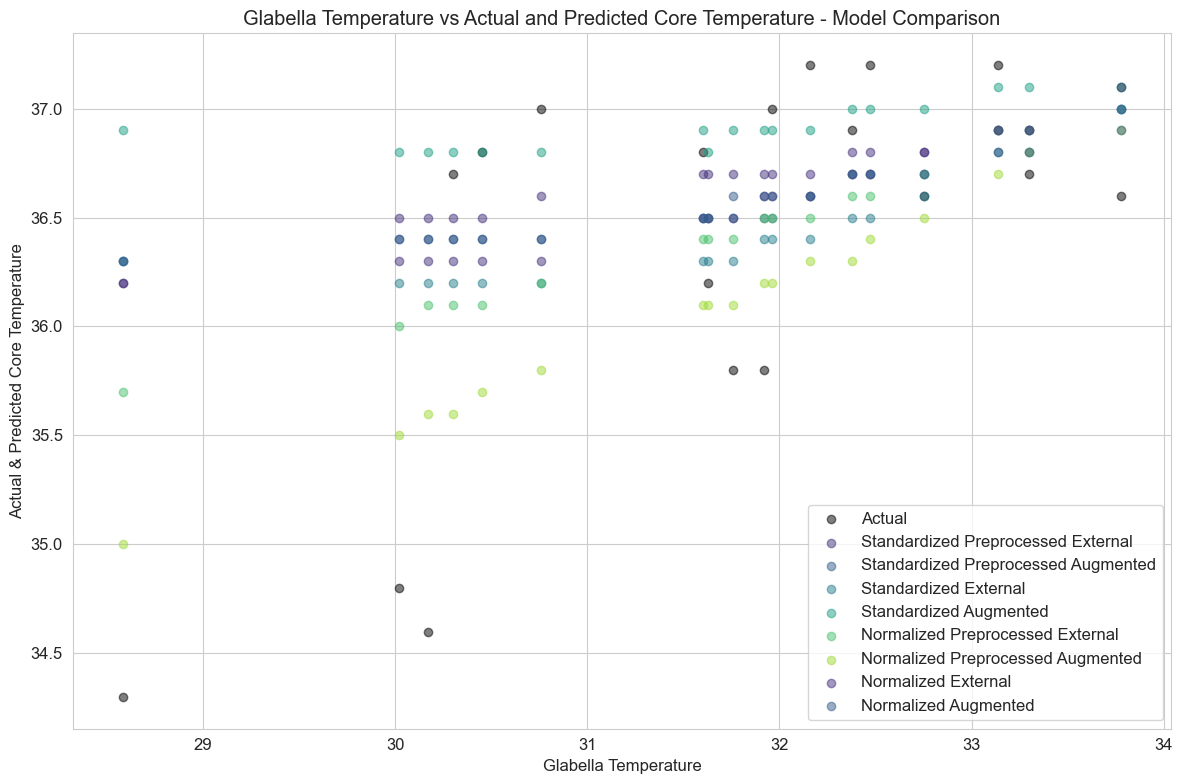

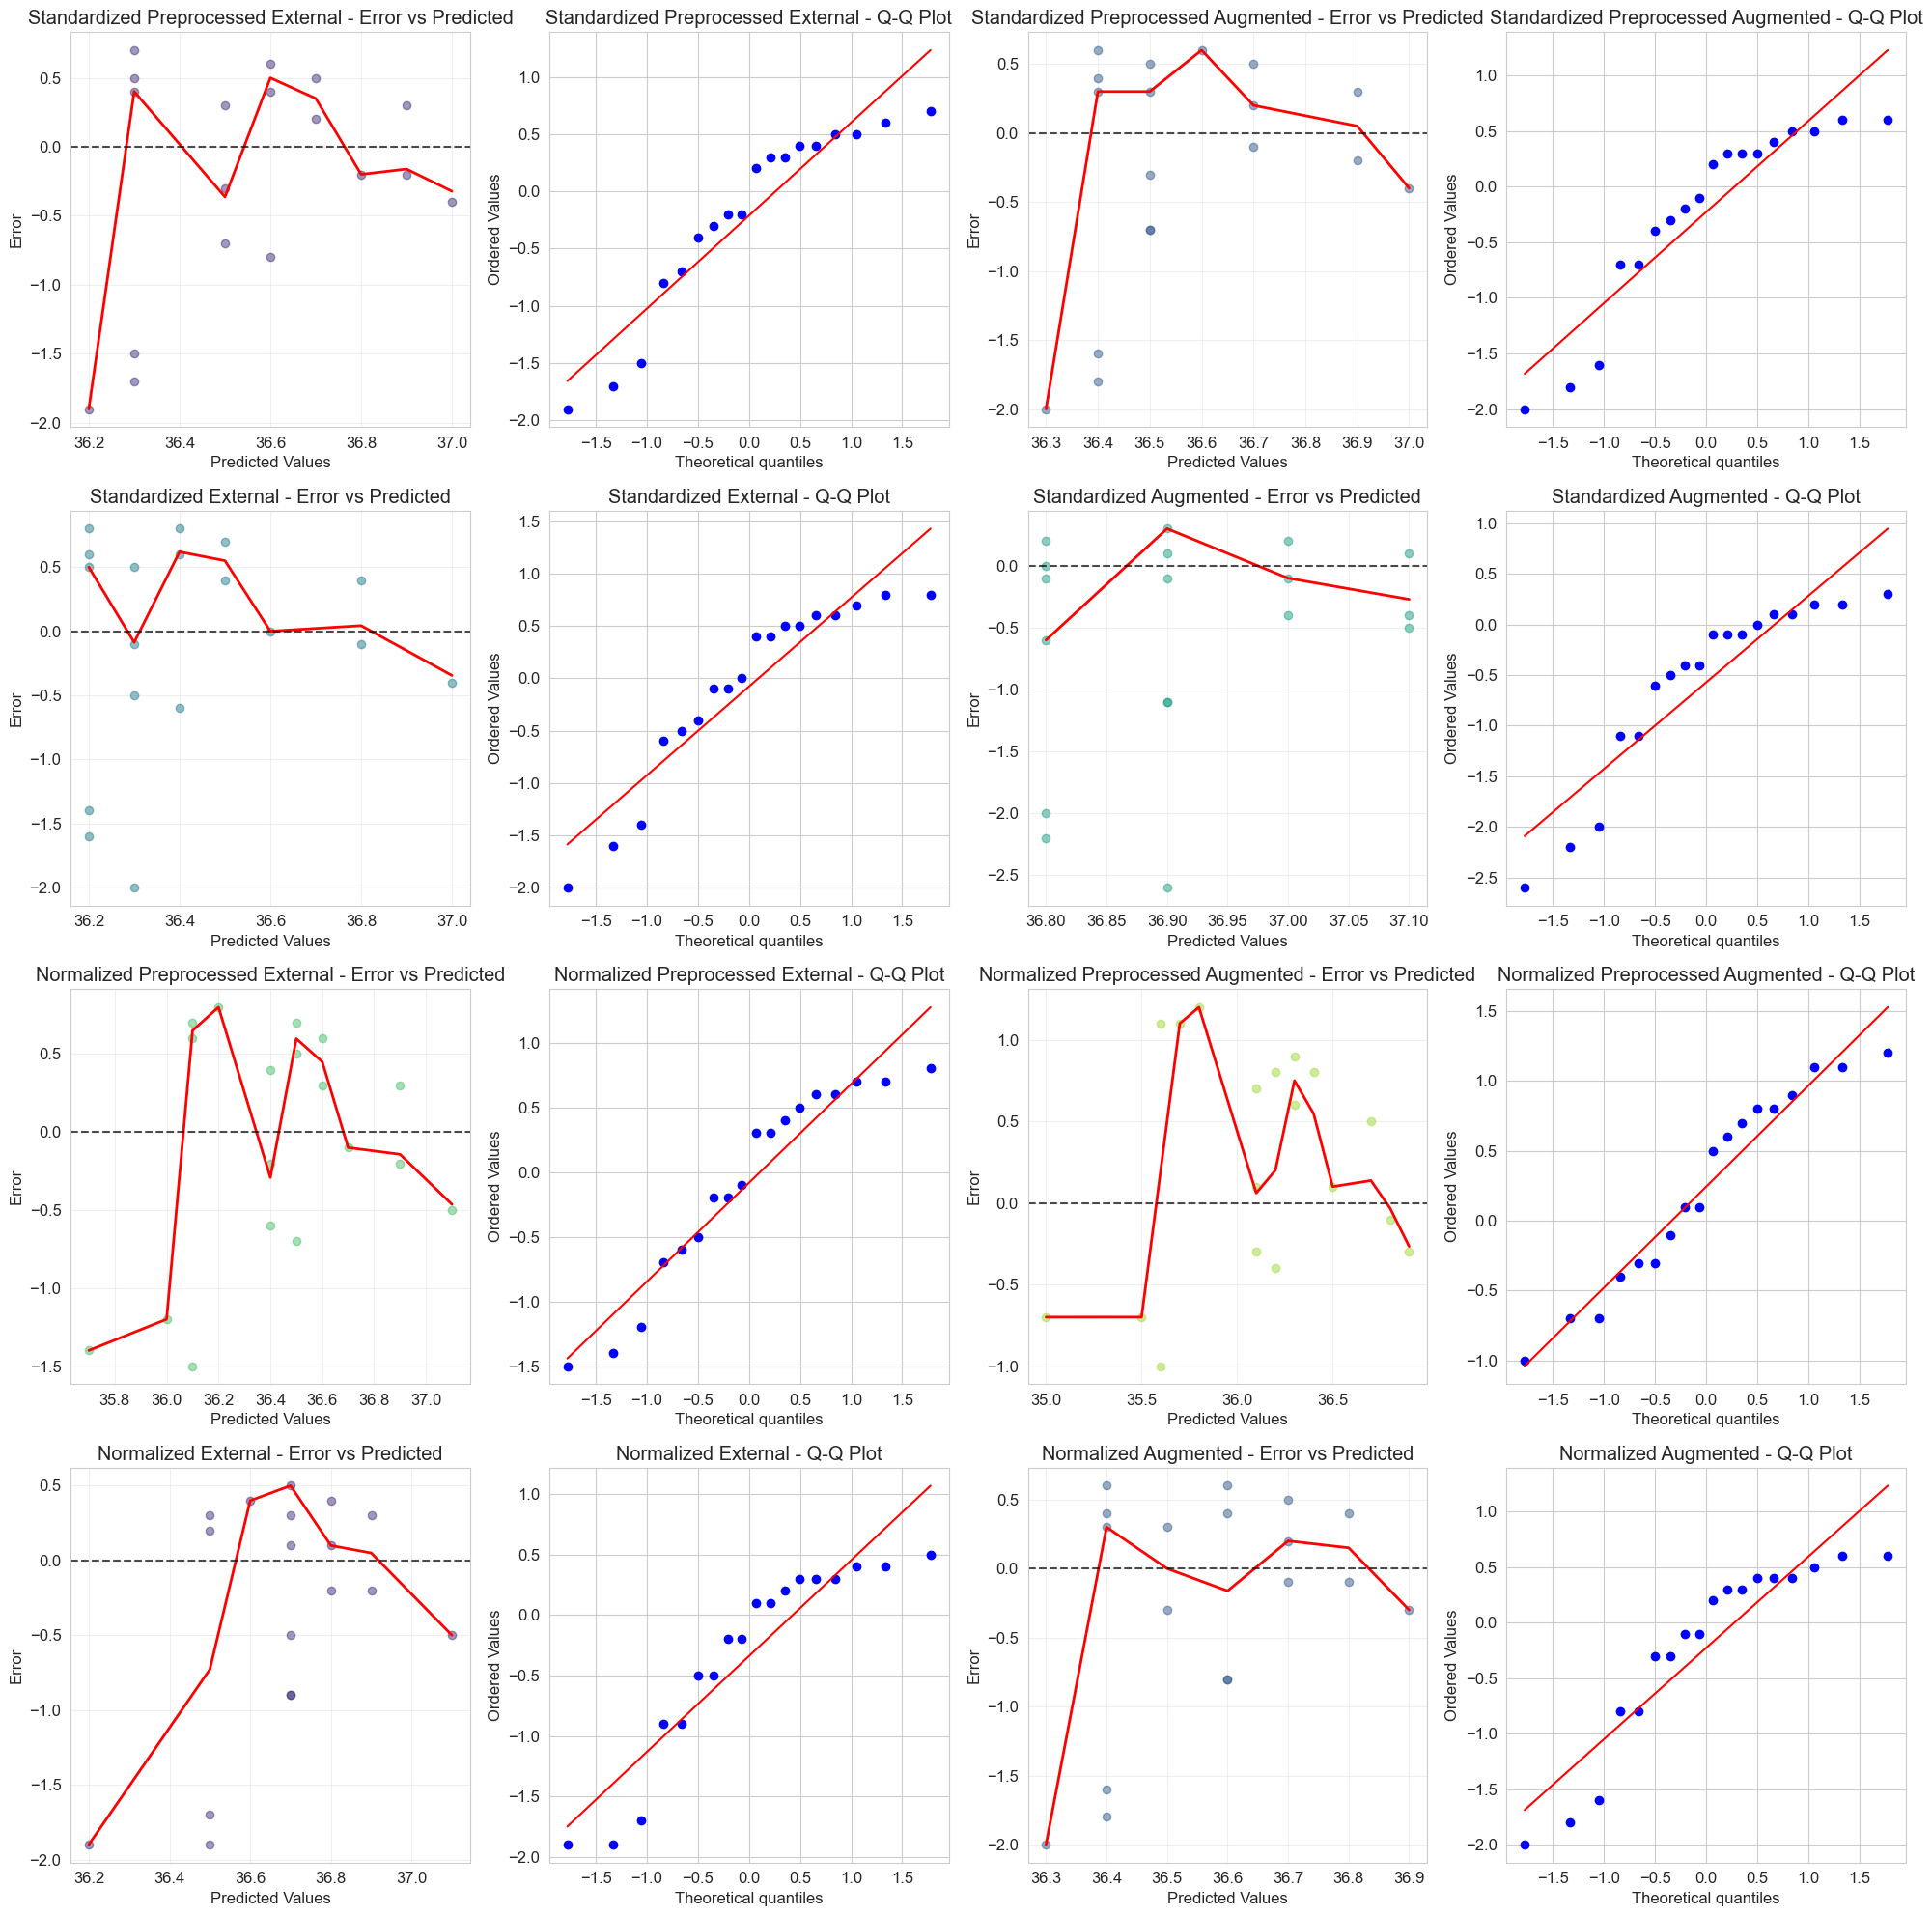

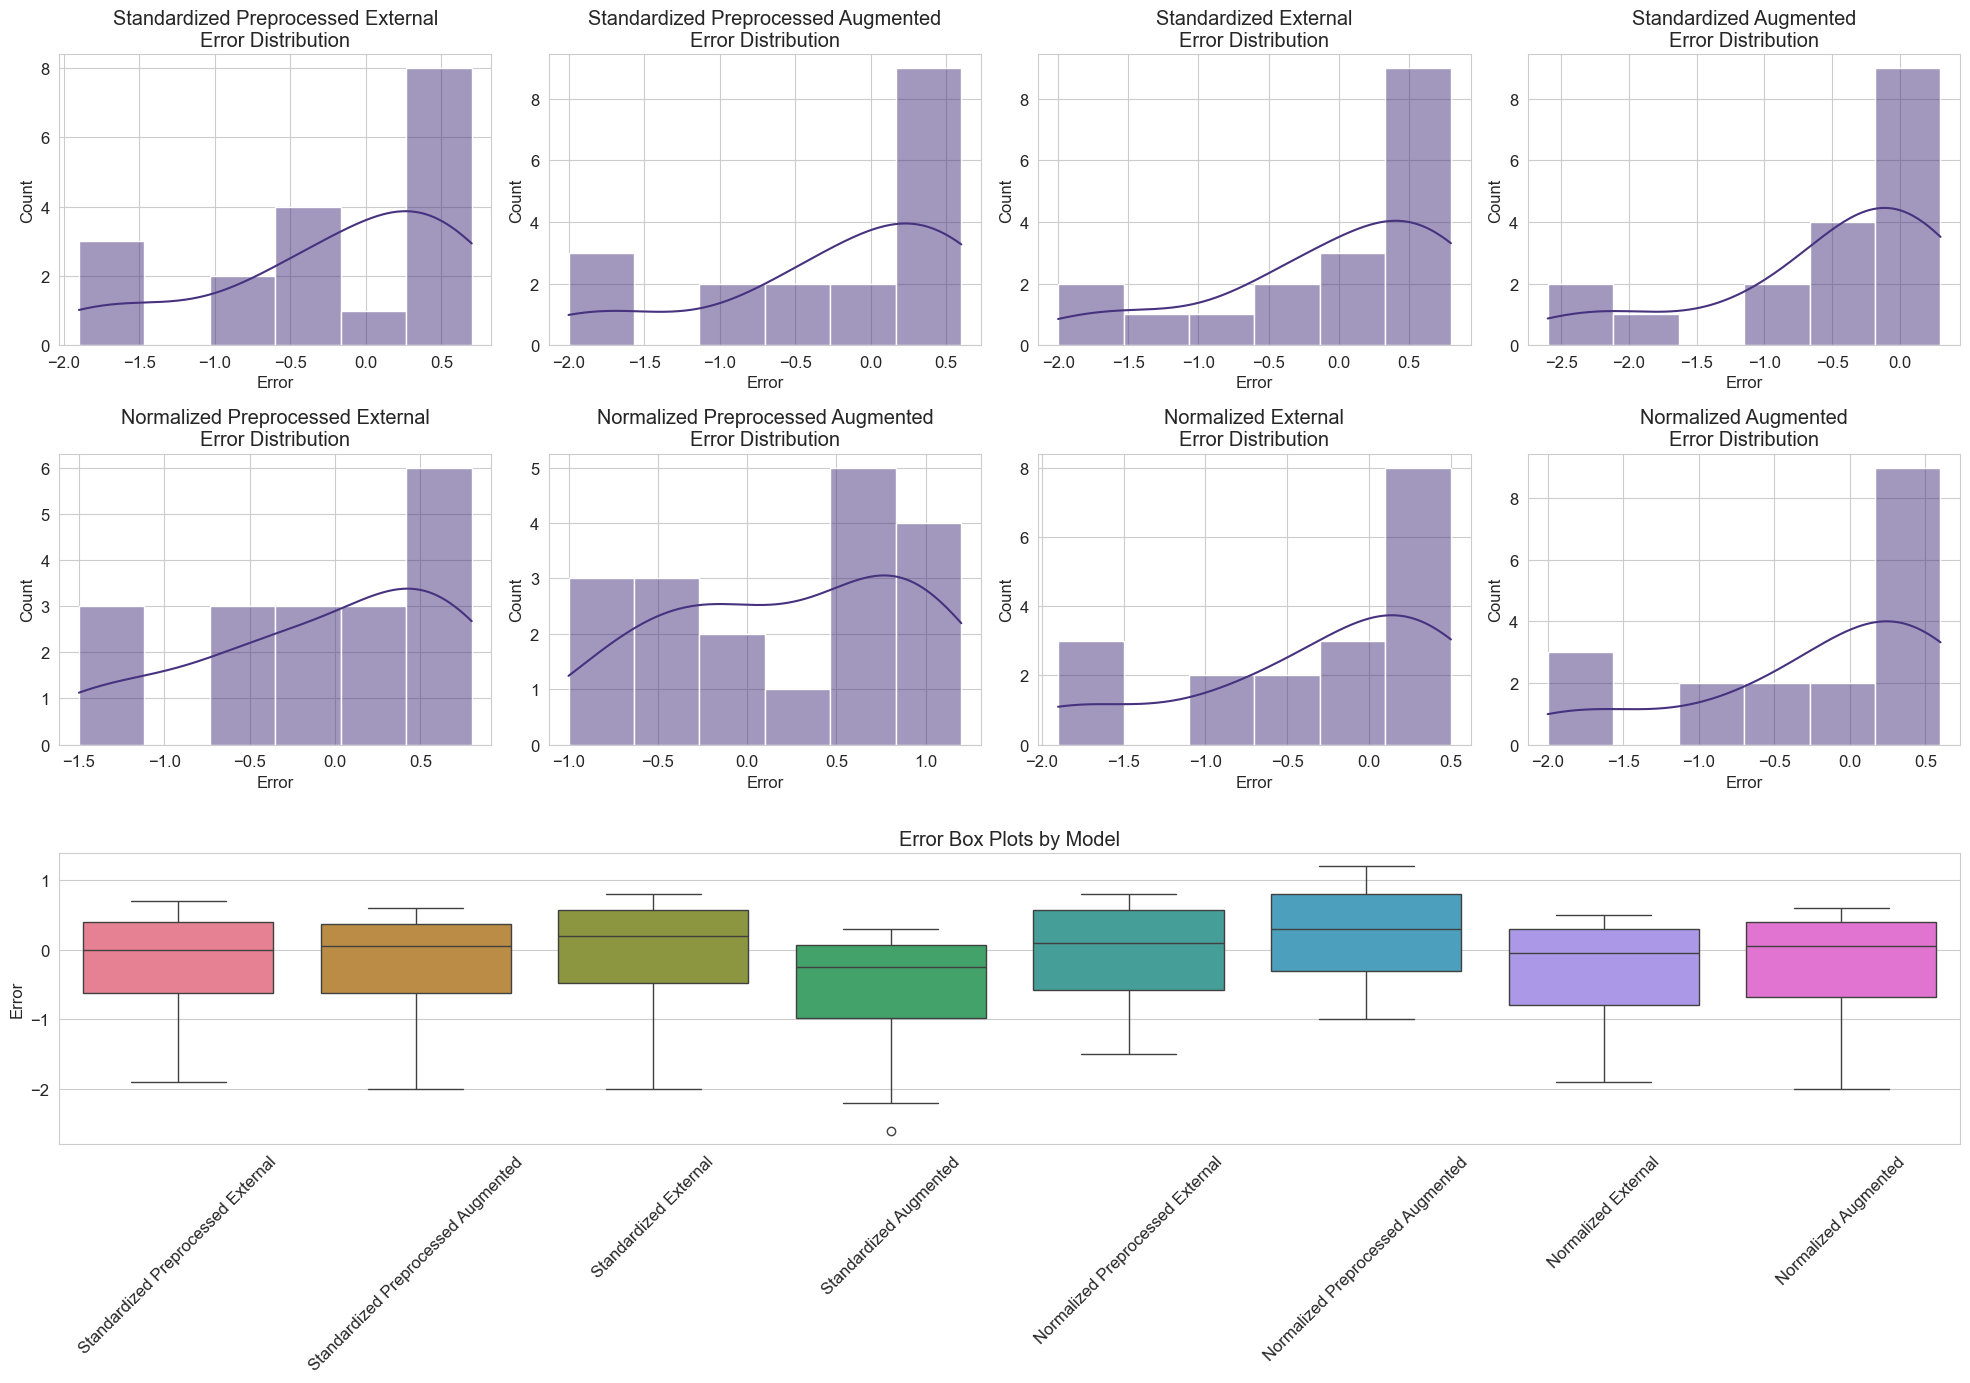

In [26]:
print("\nComparing models:")
ctocmetrics, ctocstats, ctocoverallstats, ctochomoscedasticity, ctocstats_test_result, ctocerrors = manager.compare_models(test_data[(test_data['Hc'] == 'cooled') & (test_data['Rc'] == 'cooled')], ['cooled', 'cooled'], 'Tc', to_sort=False, plot=True)

## Ambient Temp-Based

### Default Room


Comparing models:

---------------
 Trial 1 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.542138 0.356437 0.293913 -0.031051
Standardized Preprocessed Augmented 0.654192 0.446090 0.427967 -0.501313
              Standardized External 0.639360 0.434218 0.408781 -0.434009
             Standardized Augmented 0.767792 0.555285 0.589505 -1.067991
   Normalized Preprocessed External 0.571501 0.385182 0.326614 -0.145766
  Normalized Preprocessed Augmented 0.488914 0.373431 0.239037  0.161456
                Normalized External 0.531060 0.360795 0.282025  0.010653
               Normalized Augmented 0.586005 0.390272 0.343402 -0.204658

---------------
 Trial 2 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.553919 0.399618 0.306826  0.003992
Standardized Preprocessed Augmented 0.661359 0.484058 0.437396 -0.419859
              Stand

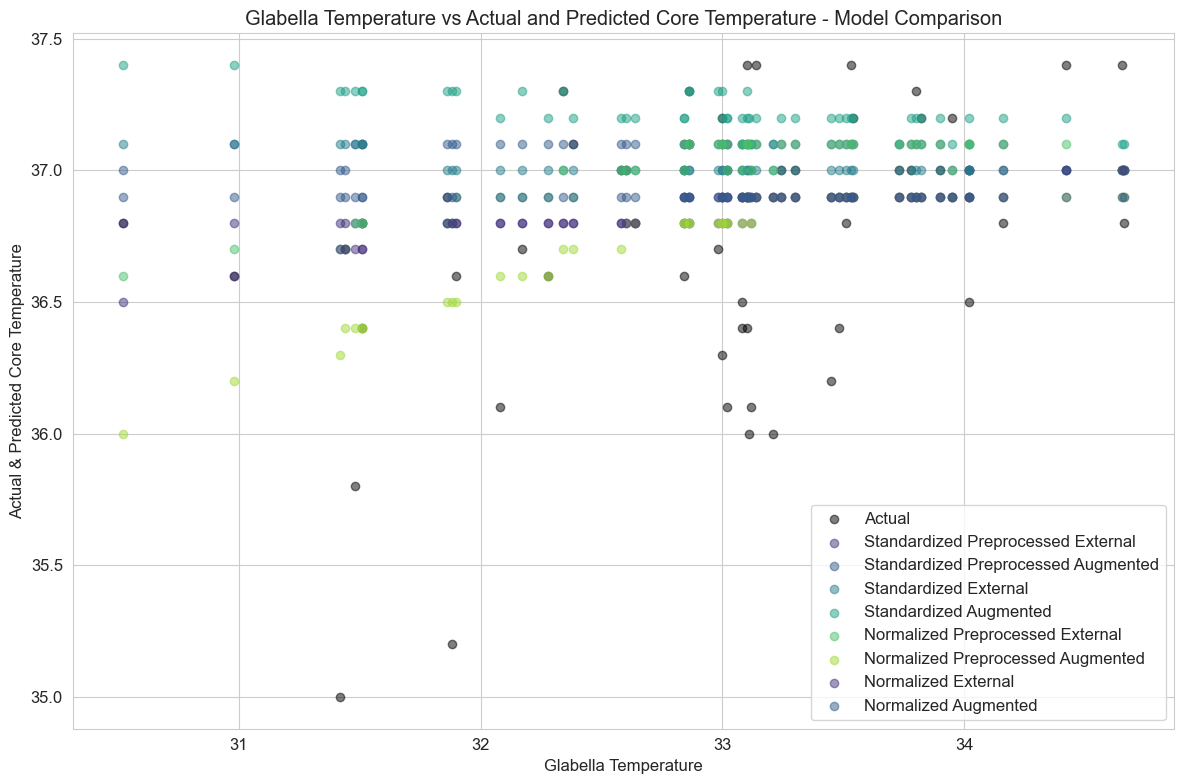

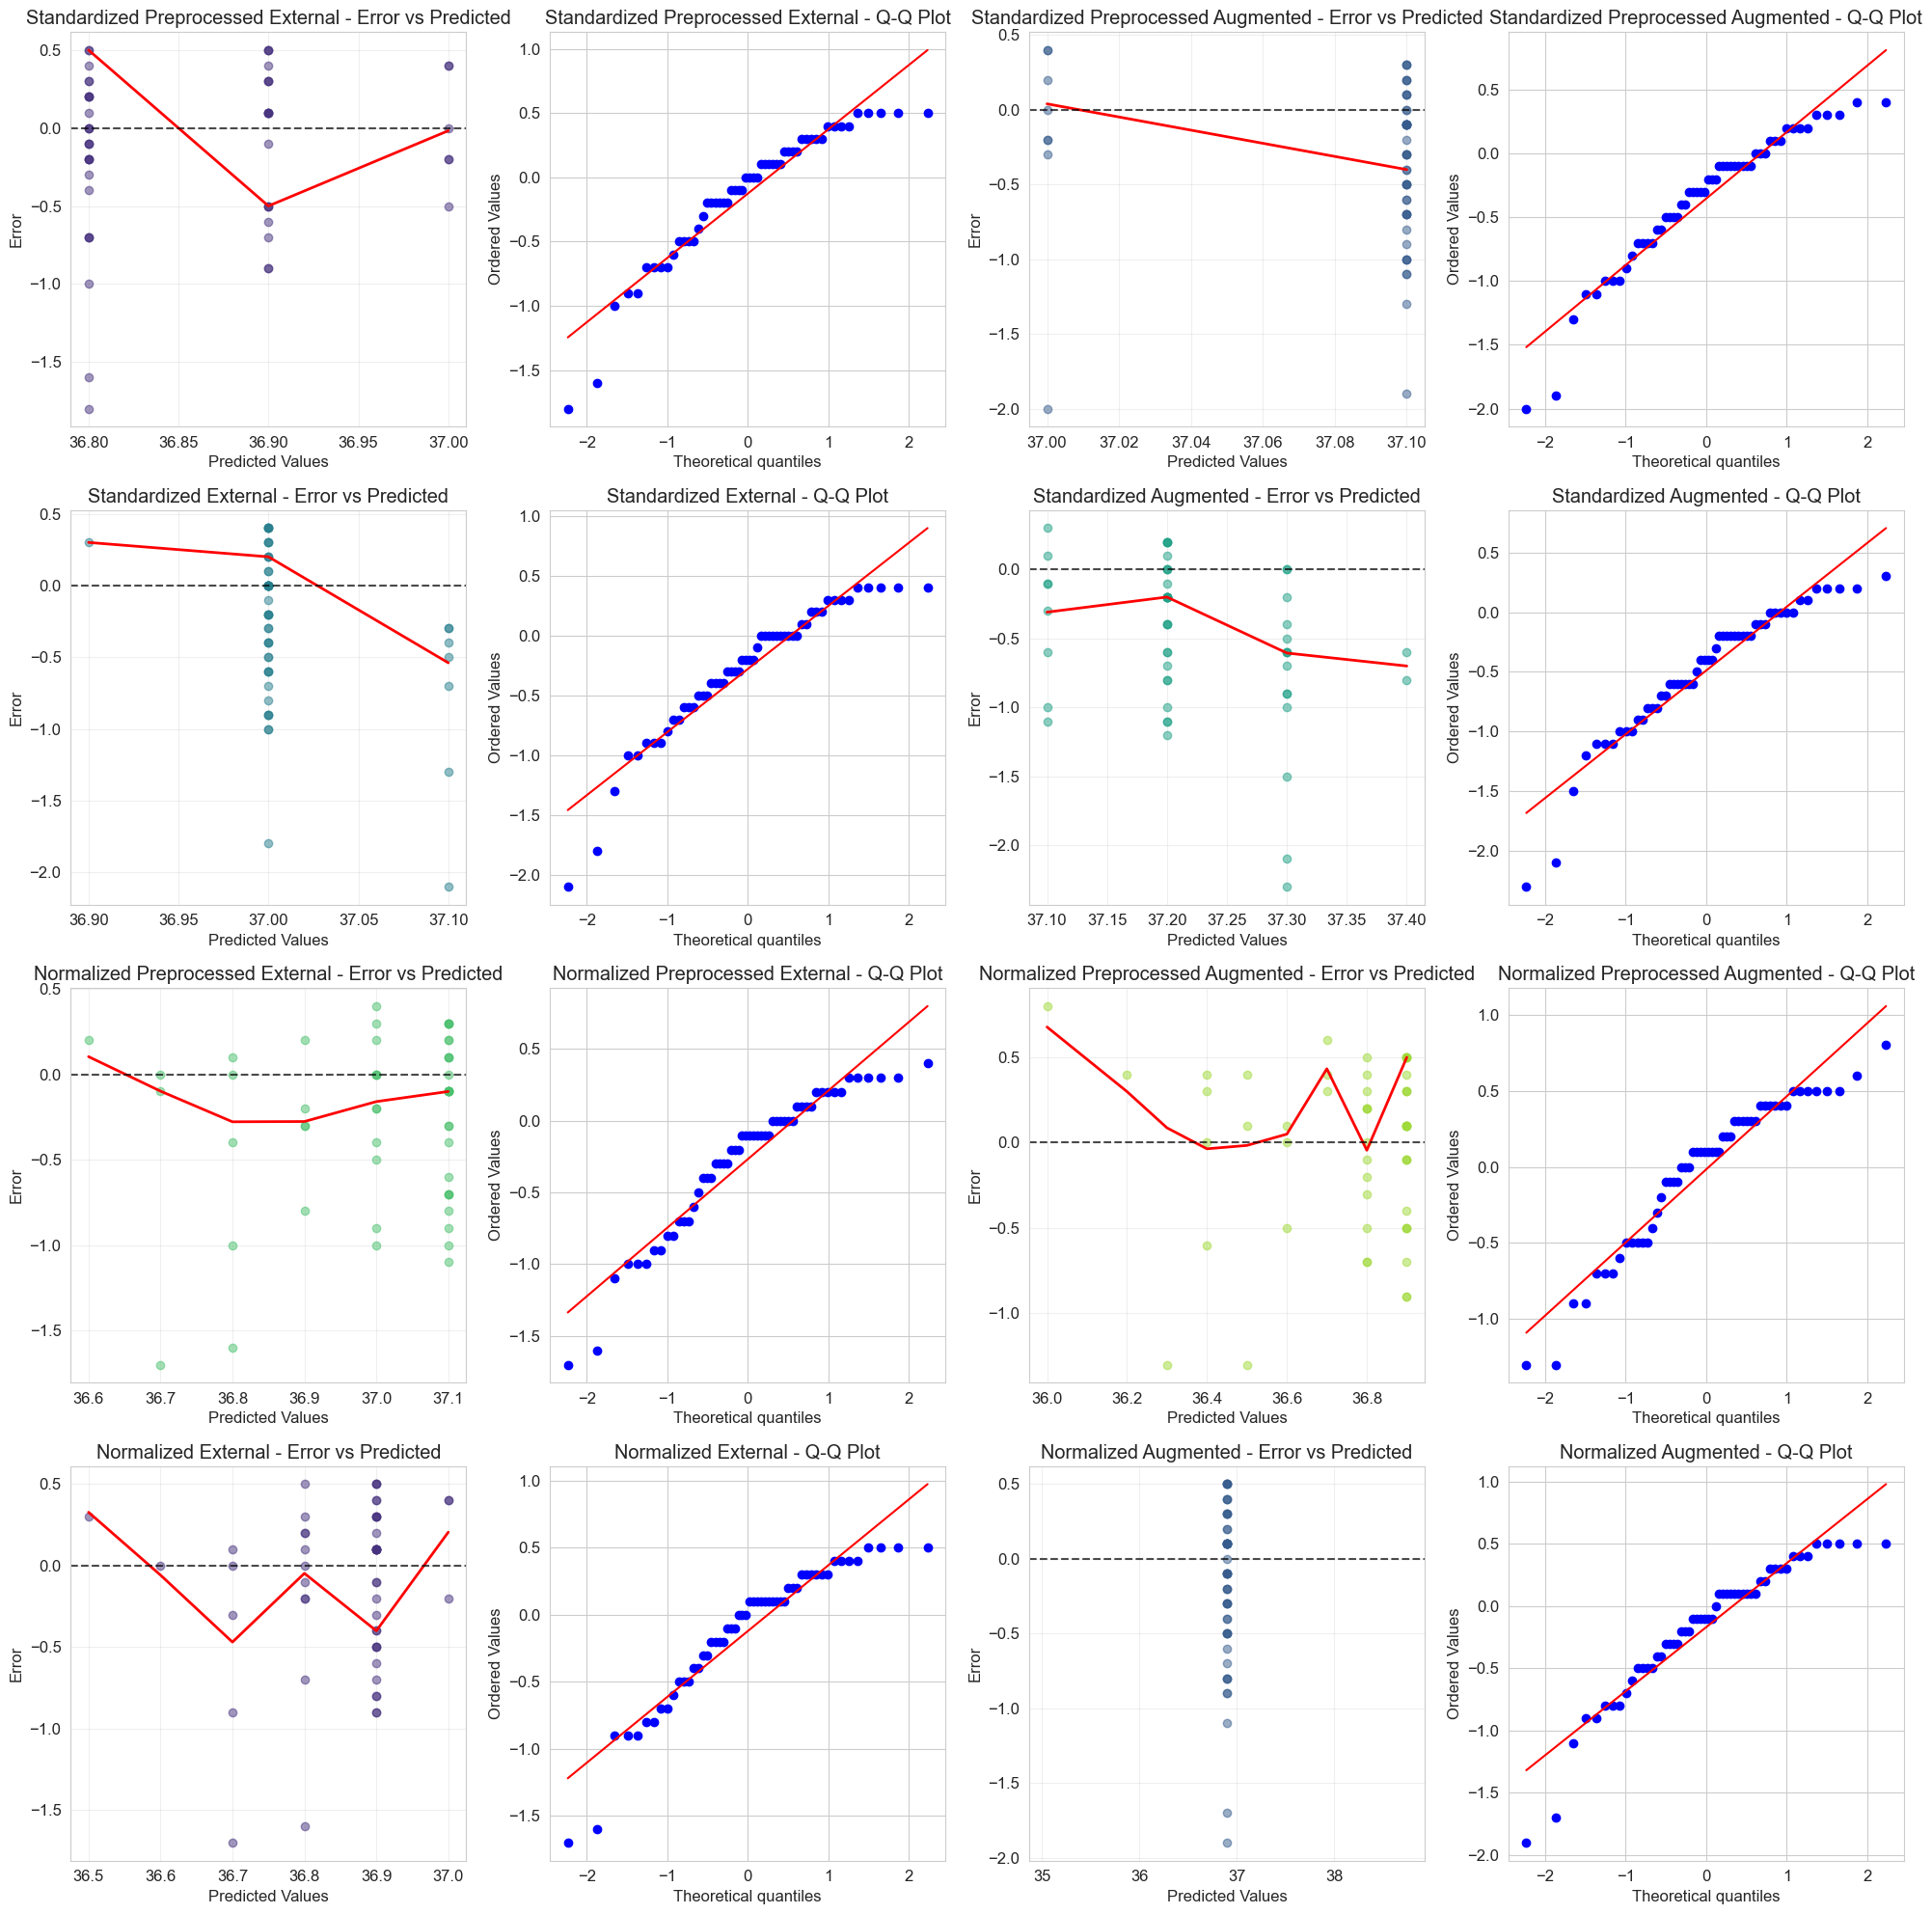

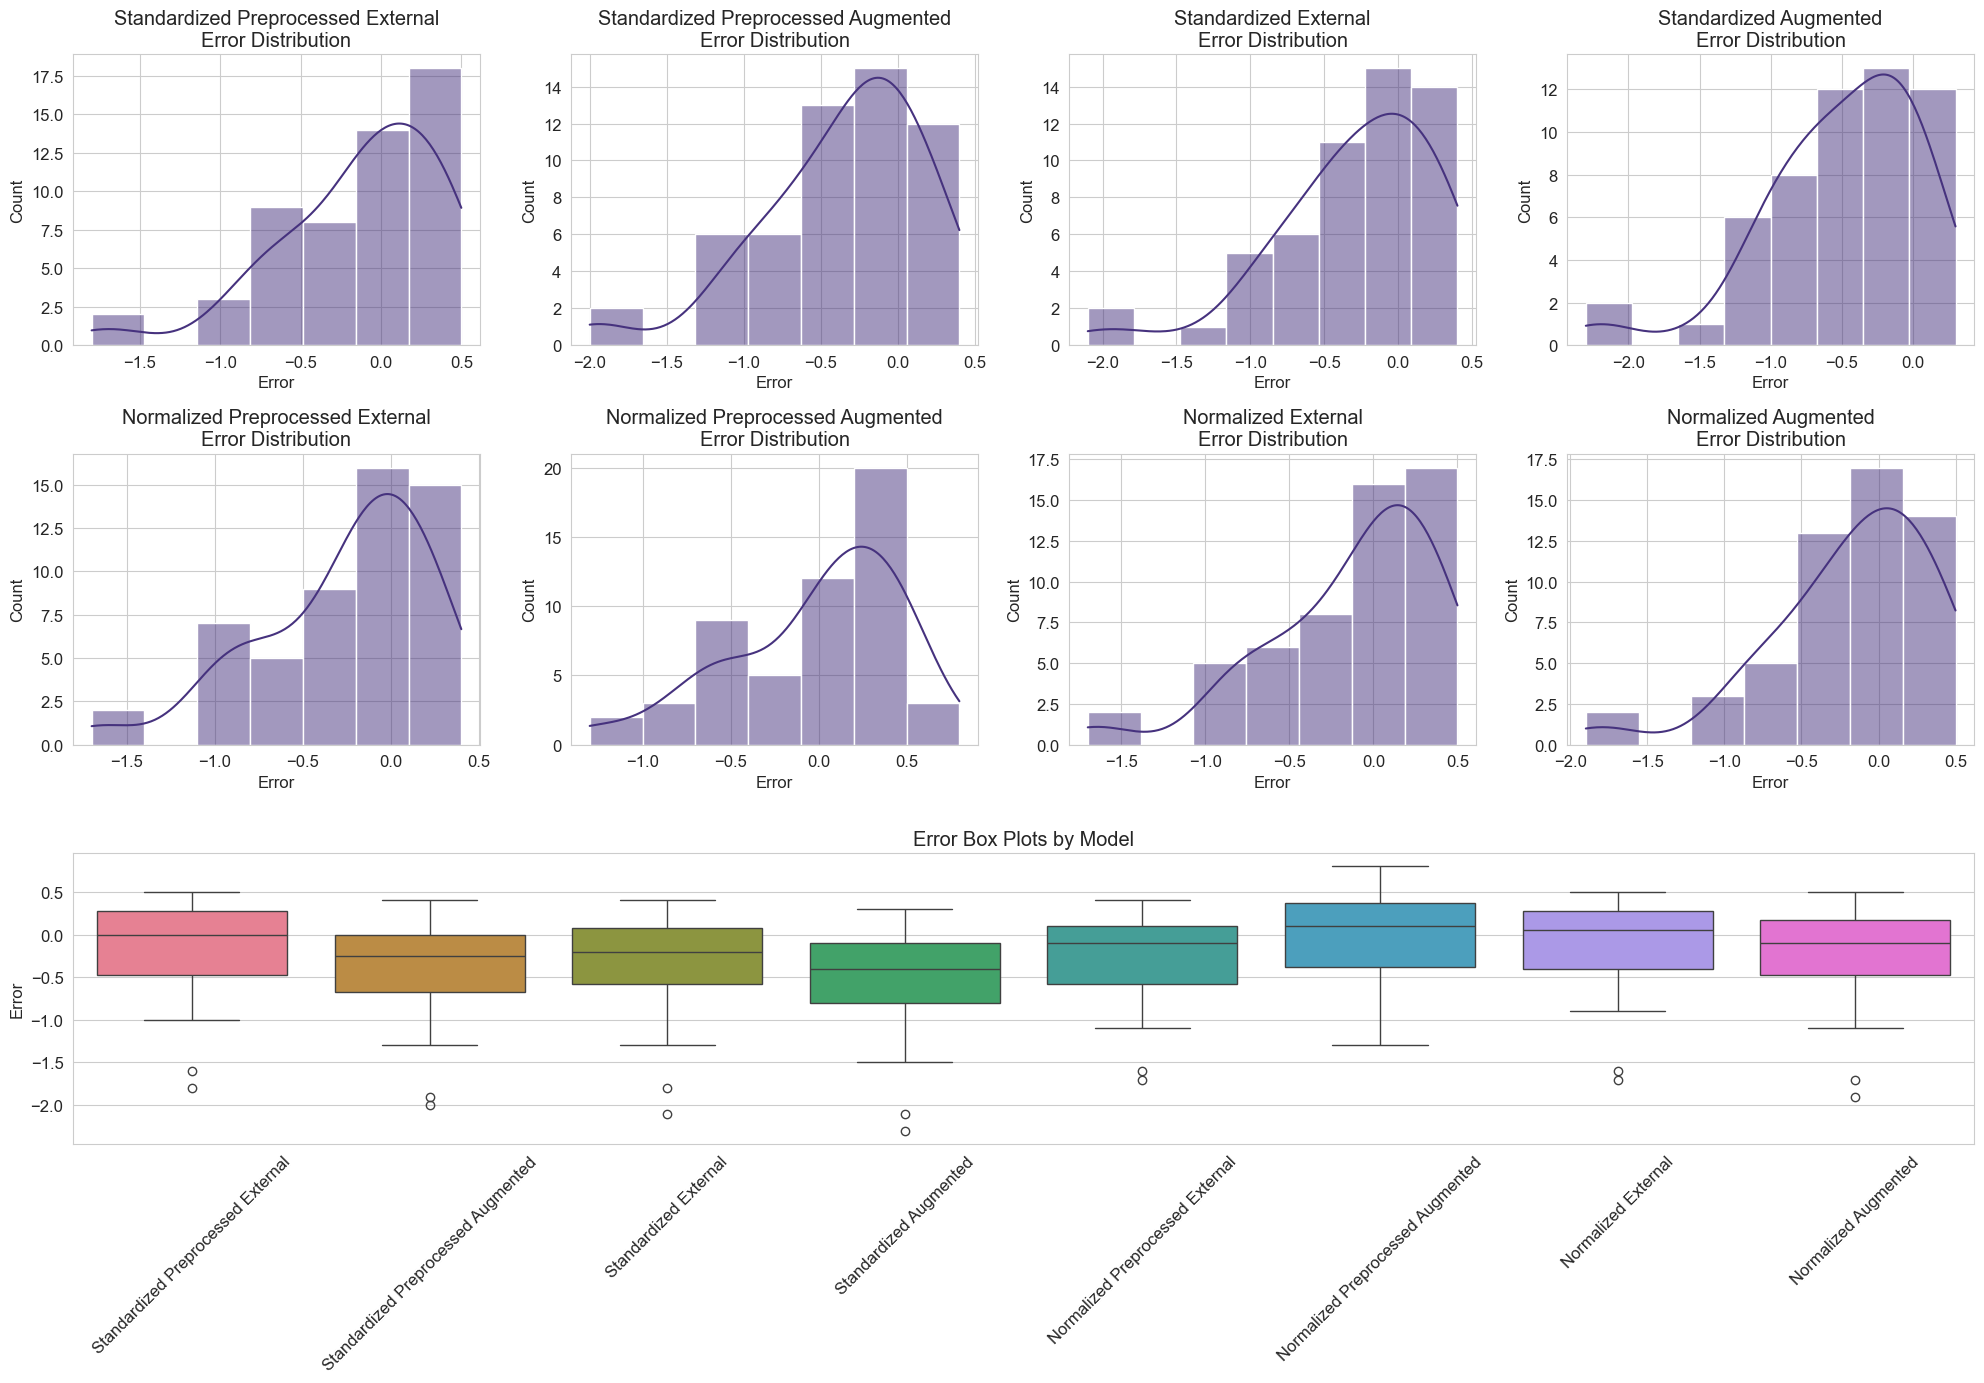

In [24]:
print("\nComparing models:")
dmetrics, dstats, doverallstats, dhomoscedasticity, dstats_test_result, derrors = manager.compare_models(test_data[test_data['Rc'] == 'default'], ['default', 'default'], 'Tc', to_sort=False, plot=True)

### Cooled Room


Comparing models:

---------------
 Trial 1 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.685359 0.502759 0.469717  0.035133
Standardized Preprocessed Augmented 0.698594 0.505934 0.488034 -0.002492
              Standardized External 0.693592 0.511927 0.481070  0.011814
             Standardized Augmented 0.861036 0.599782 0.741383 -0.522907
   Normalized Preprocessed External 0.623316 0.494555 0.388523  0.201917
  Normalized Preprocessed Augmented 0.631400 0.531306 0.398666  0.181083
                Normalized External 0.691872 0.497989 0.478686  0.016710
               Normalized Augmented 0.683653 0.492593 0.467381  0.039933

---------------
 Trial 2 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.645403 0.522874 0.416545  0.134701
Standardized Preprocessed Augmented 0.652004 0.523804 0.425109  0.116912
              Stand

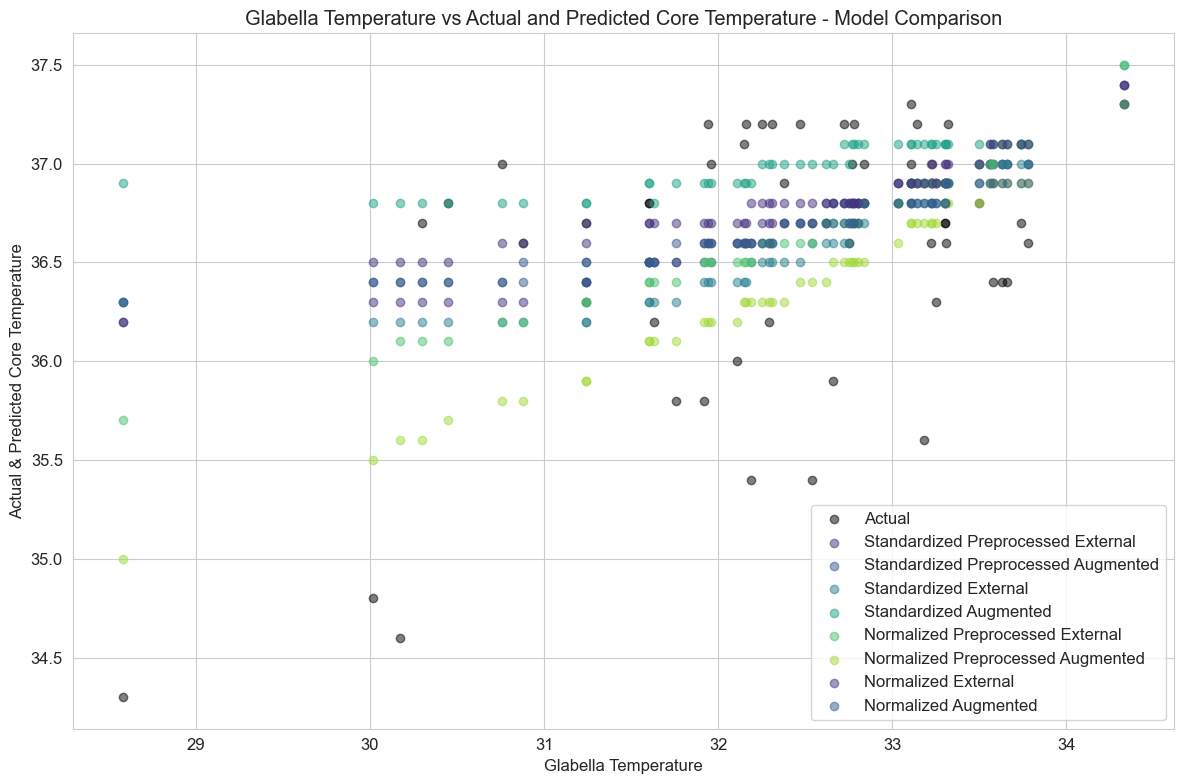

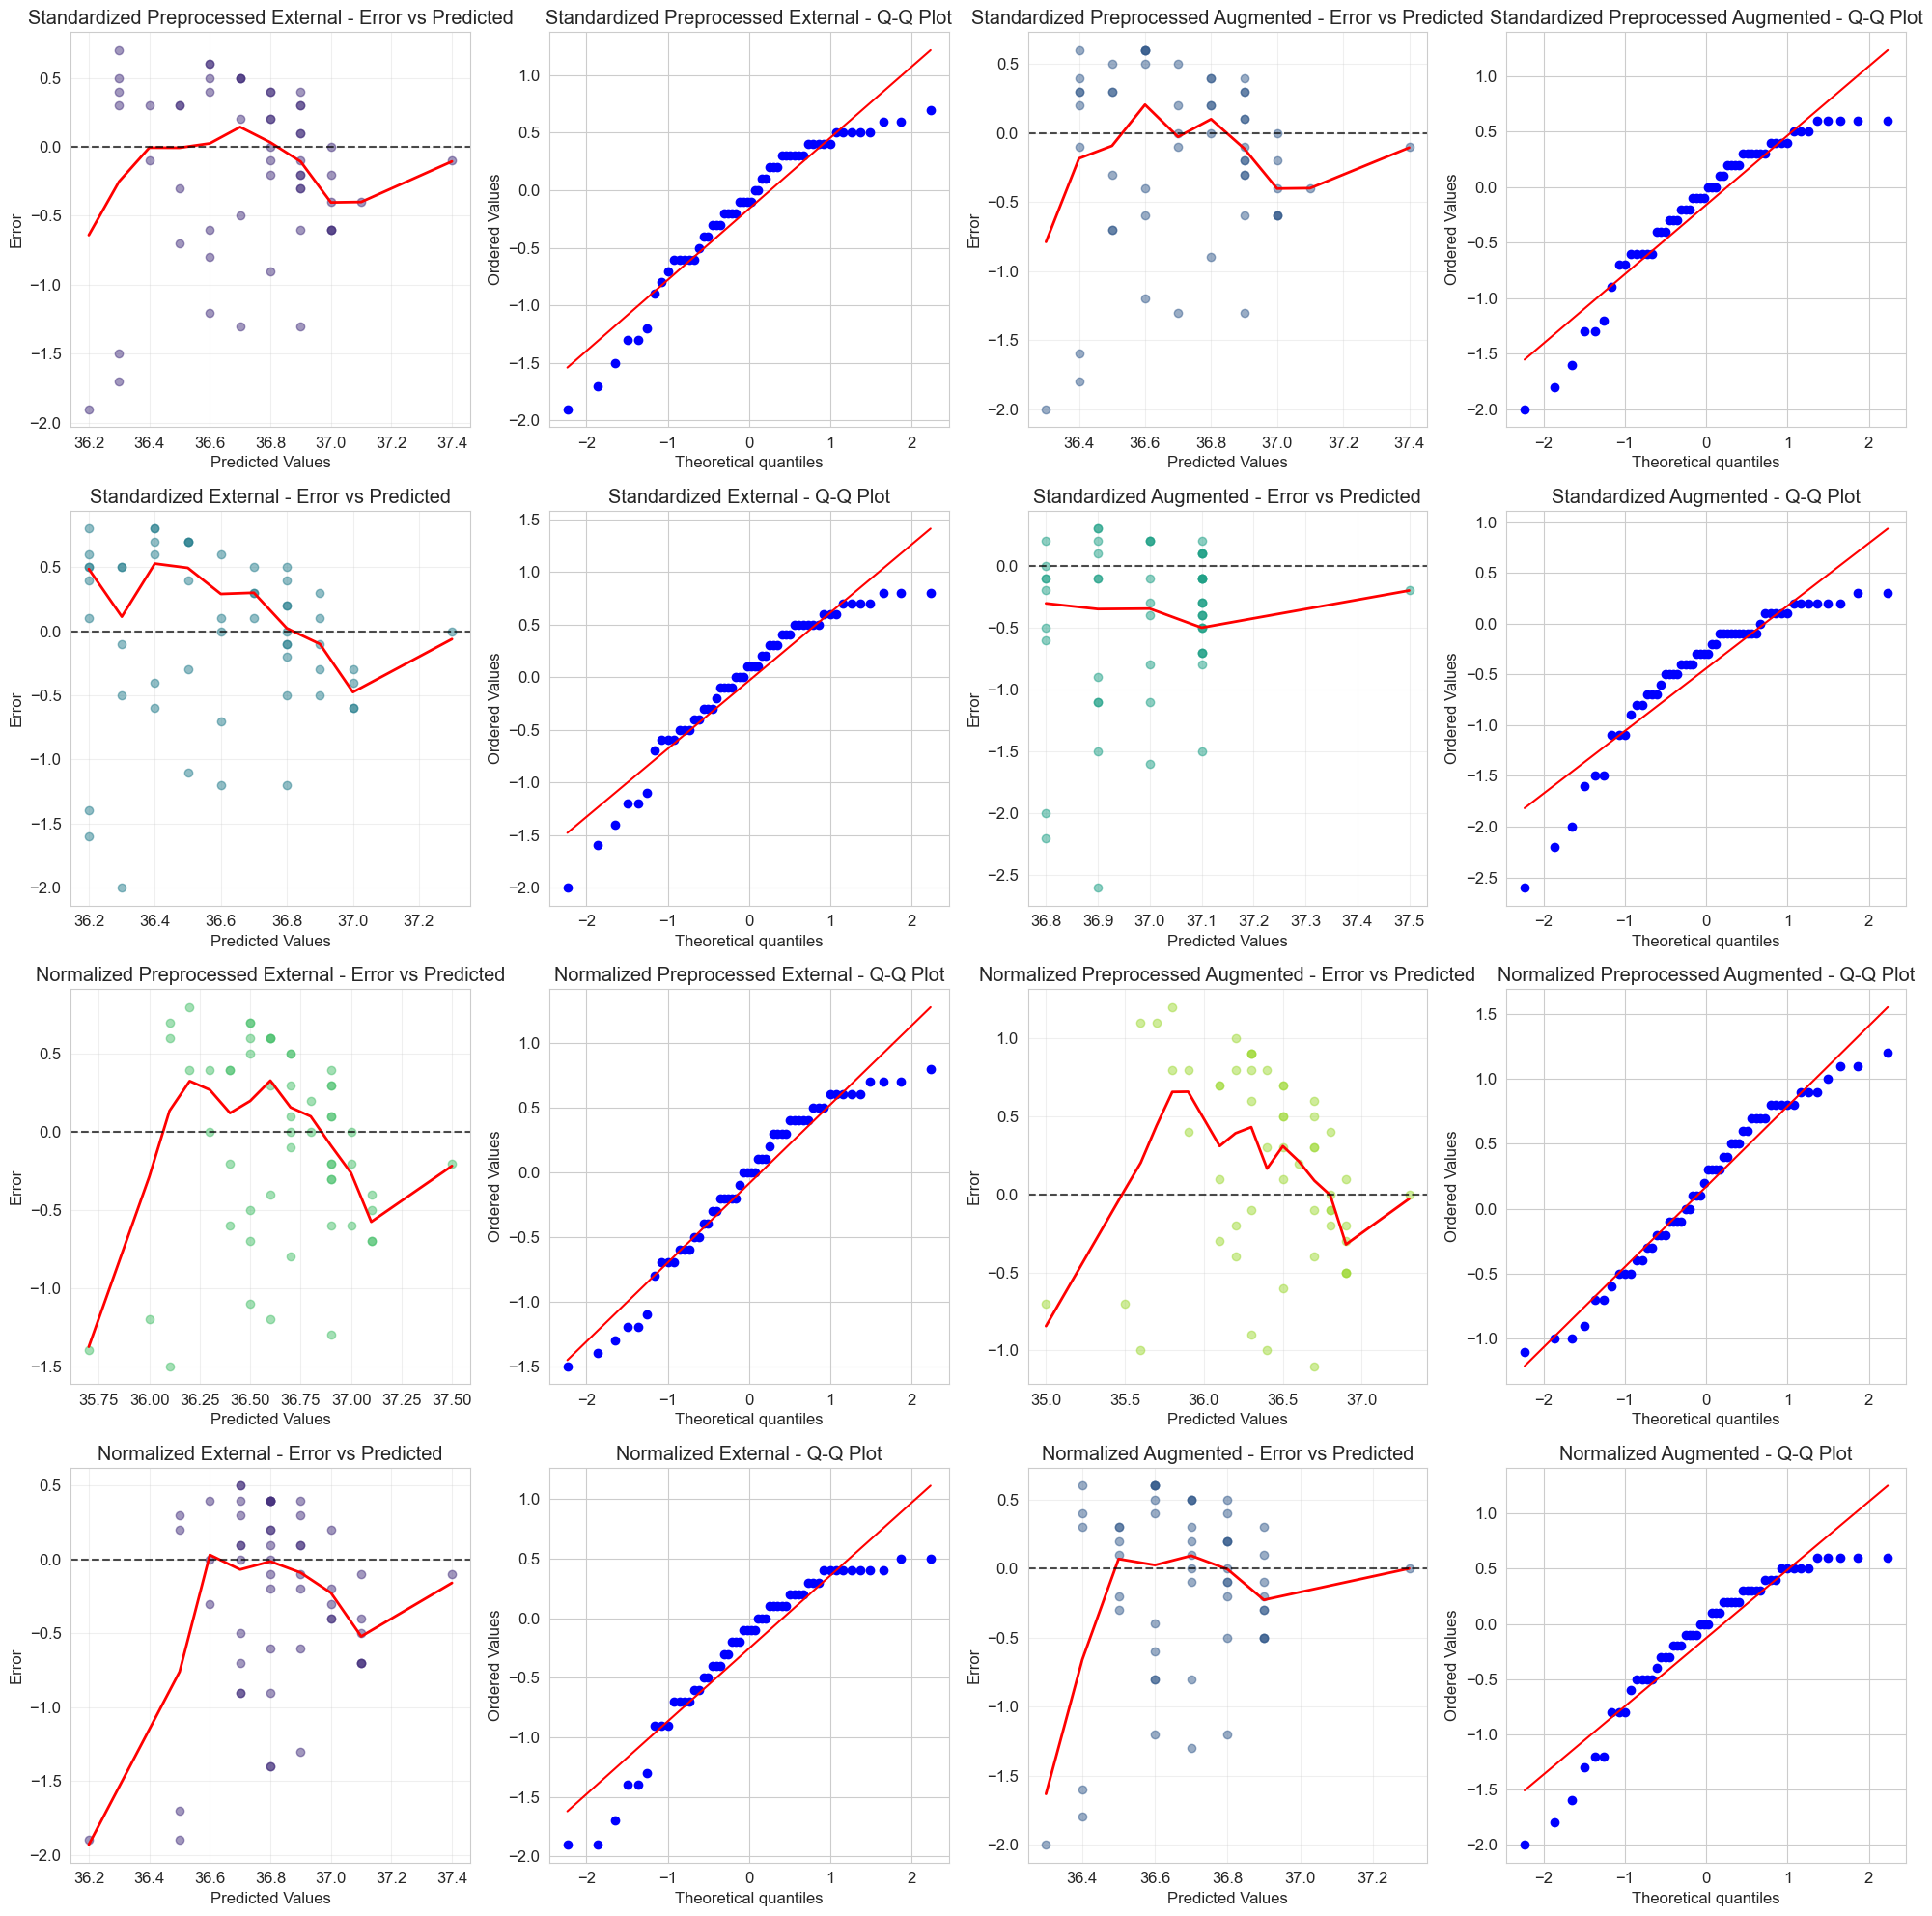

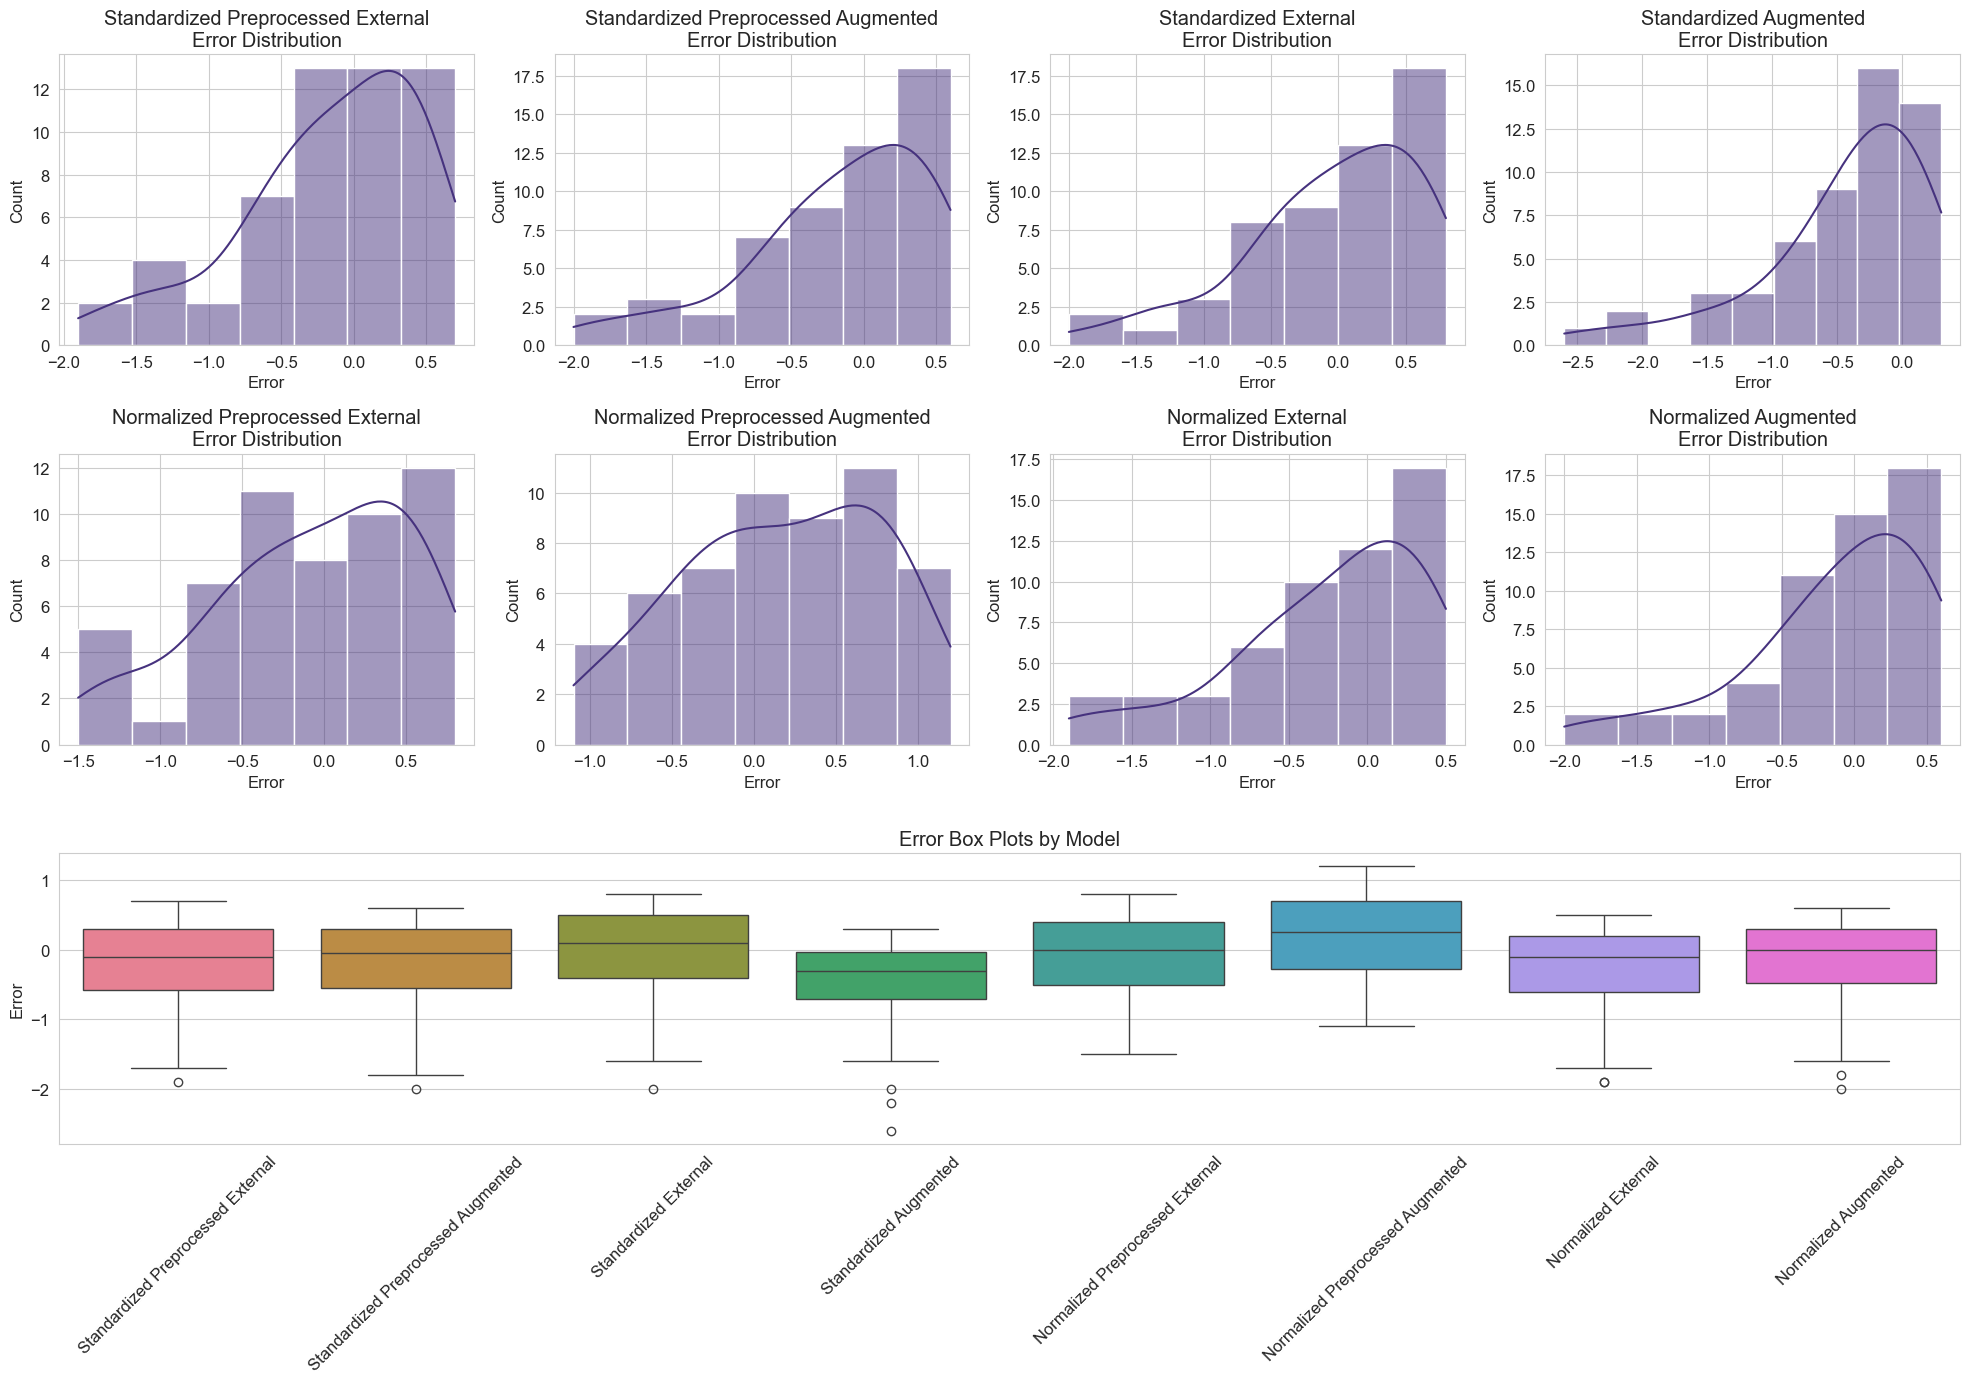

In [27]:
print("\nComparing models:")
cmetrics, cstats, coverallstats, chomoscedasticity, cstats_test_result, cerrors = manager.compare_models(test_data[test_data['Rc'] == 'cooled'], ['cooled', 'cooled'], 'Tc', to_sort=False, plot=True)

# Overall

In [16]:
from mda import test_statistical_significance
from mda.model_manager import NumpyEncoder

import json

In [17]:
results_path = "../reports/results/testing"
combinations = list(product(['default_pa', 'rigorous_pa', 'cooled'], ['default', 'cooled']))

rmse_scores = {}
for (Hc, Rc) in combinations:
    df = pd.read_csv(f"{results_path}/{Hc}/{Rc}/{Hc}_{Rc}_comparison.csv")

    for (trial, model_name) in product(df['trial'].unique(), df['Model'].unique()):
        if trial != 0:
            rmse = df.loc[(df['trial'] == trial) & (df['Model'] == model_name), 'RMSE'].iloc[0]
            if model_name not in rmse_scores:
                rmse_scores[model_name] = []
            rmse_scores[model_name].append(rmse)

stats_test_result = test_statistical_significance(rmse_scores)

# Save statistical test results to a JSON file
with open(f'../reports/results/testing/overall/overall/overall_overall_stats_test_result.json', 'w') as f:
    json.dump(stats_test_result, f, indent=4, cls=NumpyEncoder)

In [18]:
from mda import process_stats_files

In [28]:
from itertools import product

results_path = "../reports/results/testing"
combinations = list(product(['default_pa', 'rigorous_pa', 'cooled body'], ['default', 'cooled']))
process_stats_files(results_path, combinations)

combinations = list(product(['overall'], ['overall']))
process_stats_files(results_path, combinations)

combinations = list(product(['default'], ['default']))
process_stats_files(results_path, combinations)

combinations = list(product(['cooled'], ['cooled']))
process_stats_files(results_path, combinations)

Processing: ../reports/results/testing/default_pa/default/default_pa_default_stats_test_result.json
Saved: ../reports/results/testing/default_pa/default/default_pa_default_Normality Test.csv
Saved: ../reports/results/testing/default_pa/default/default_pa_default_Friedman Test.csv
Processing: ../reports/results/testing/default_pa/cooled/default_pa_cooled_stats_test_result.json
Saved: ../reports/results/testing/default_pa/cooled/default_pa_cooled_Normality Test.csv
Saved: ../reports/results/testing/default_pa/cooled/default_pa_cooled_Friedman Test.csv
Processing: ../reports/results/testing/rigorous_pa/default/rigorous_pa_default_stats_test_result.json
Saved: ../reports/results/testing/rigorous_pa/default/rigorous_pa_default_Normality Test.csv
Saved: ../reports/results/testing/rigorous_pa/default/rigorous_pa_default_Friedman Test.csv
Saved: ../reports/results/testing/rigorous_pa/default/rigorous_pa_default_Nemenyi Test_comparisons.csv
Saved: ../reports/results/testing/rigorous_pa/default/

# Overall Model Performance Analysis

In [58]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp
from statsmodels.stats.libqsturng import qsturng
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import f_oneway

from mda.stats_testing import test_statistical_significance

class ModelPerformanceAnalyzer:
    def __init__(self, alpha=0.05):
        """
        Initialize the model performance analyzer.
        
        Parameters:
        -----------
        alpha : float, default=0.05
            The significance level for statistical tests.
        """
        self.alpha = alpha
        self.experiment_results = {}
        self.summary_results = {}
        
    def add_experiment(self, experiment_name, sample):
        """
        Add experiment results to the analyzer.
        
        Parameters:
        -----------
        experiment_name : str
            Name of the experiment.
        sample : dict
            Dictionary with model names as keys and lists of sample as values.
            All models should have the same number of samples.
        """
        # Check if all models have the same number of samples
        lengths = [len(v) for v in sample.values()]
        if len(set(lengths)) > 1:
            raise ValueError("All models must have the same number of samples")
            
        # Store the results
        self.experiment_results[experiment_name] = sample
        
    def analyze_experiment(self, experiment_name):
        """
        Perform statistical analysis on a single experiment.
        First tests for normality to determine whether to use parametric or non-parametric tests.
        
        Parameters:
        -----------
        experiment_name : str
            Name of the experiment to analyze.
            
        Returns:
        --------
        dict
            Results of the statistical analysis.
        """
        if experiment_name not in self.experiment_results:
            raise ValueError(f"Experiment '{experiment_name}' not found")
            
        sample = self.experiment_results[experiment_name]
        
        return test_statistical_significance(sample)
    
    def analyze_all_experiments(self):
        """
        Perform statistical analysis on all experiments.
        
        Returns:
        --------
        dict
            Results of all statistical analyses.
        """
        all_results = {}
        
        for experiment_name in self.experiment_results:
            all_results[experiment_name] = self.analyze_experiment(experiment_name)
            
        return all_results
    
    def summarize_performance(self):
        """
        Create a summary of model performance across all experiments.
        
        Returns:
        --------
        dict
            Summary of model performance.
        """
        # First, analyze all experiments if not already done
        all_results = self.analyze_all_experiments()
        
        # Extract all model names across all experiments
        all_models = set()
        for experiment in self.experiment_results.values():
            all_models.update(experiment.keys())
        all_models = list(all_models)
        
        # Initialize summary structures
        win_matrix = pd.DataFrame(0, index=all_models, columns=all_models)
        tie_matrix = pd.DataFrame(0, index=all_models, columns=all_models)
        loss_matrix = pd.DataFrame(0, index=all_models, columns=all_models)
        
        # Track average ranks
        rank_sum = defaultdict(float)
        rank_count = defaultdict(int)
        
        # Track overall win/tie/loss
        overall_wins = defaultdict(int)
        overall_ties = defaultdict(int)
        overall_losses = defaultdict(int)
        
        # Populate matrices
        for exp_name, results in all_results.items():
            # Check if we used parametric or non-parametric tests
            if 'Tukey\'s Honest Significant Difference' in results:
                tukey = results['Tukey\'s Honest Significant Difference']
                
                # Record means (lower is better for error metrics)
                for i, model in enumerate(tukey['summary']['models']):
                    # Use negative means because lower is better for error metrics
                    # This makes ranking consistent with higher = better
                    rank_sum[model] += -tukey['summary']['means'][i]
                    rank_count[model] += 1
                
                # Record pairwise comparisons
                for comp in tukey['comparisons']:
                    model_1 = comp['model_1']
                    model_2 = comp['model_2']
                    
                    # Use significance flag for determination
                    if comp['reject']:
                        # Mean diff is model_1 - model_2, so negative means model_1 is better (lower error)
                        if comp['mean_diff'] < 0:
                            win_matrix.loc[model_1, model_2] += 1
                            loss_matrix.loc[model_2, model_1] += 1
                            overall_wins[model_1] += 1
                            overall_losses[model_2] += 1
                        else:
                            win_matrix.loc[model_2, model_1] += 1
                            loss_matrix.loc[model_1, model_2] += 1
                            overall_wins[model_2] += 1
                            overall_losses[model_1] += 1
                    else:
                        # No significant difference
                        tie_matrix.loc[model_1, model_2] += 1
                        tie_matrix.loc[model_2, model_1] += 1
                        overall_ties[model_1] += 1
                        overall_ties[model_2] += 1
            
            elif 'Nemenyi Test' in results:
                nemenyi = results['Nemenyi Test']
                
                # Record ranks
                for i, model in enumerate(nemenyi['summary']['models']):
                    rank_sum[model] += nemenyi['summary']['r_mean'][i]
                    rank_count[model] += 1
                
                # Record pairwise comparisons
                for comp in nemenyi['comparisons']:
                    model_1 = comp['model_1']
                    model_2 = comp['model_2']
                    
                    # Use p-value for significance determination
                    if comp['significant']:
                        if comp['r_mean_diff'] > 0:  # Check which model is better
                            # Lower rank means better performance
                            idx_1 = nemenyi['summary']['models'].index(model_1)
                            idx_2 = nemenyi['summary']['models'].index(model_2)
                            
                            if nemenyi['summary']['r_mean'][idx_1] > nemenyi['summary']['r_mean'][idx_2]:
                                win_matrix.loc[model_1, model_2] += 1
                                loss_matrix.loc[model_2, model_1] += 1
                                overall_wins[model_1] += 1
                                overall_losses[model_2] += 1
                            else:
                                win_matrix.loc[model_2, model_1] += 1
                                loss_matrix.loc[model_1, model_2] += 1
                                overall_wins[model_2] += 1
                                overall_losses[model_1] += 1
                    else:
                        # No significant difference
                        tie_matrix.loc[model_1, model_2] += 1
                        tie_matrix.loc[model_2, model_1] += 1
                        overall_ties[model_1] += 1
                        overall_ties[model_2] += 1
        
        # Calculate average ranks
        avg_ranks = {model: rank_sum[model] / rank_count[model] if rank_count[model] > 0 else float('nan') 
                     for model in all_models}
        
        # Sort models by average rank
        sorted_models = sorted(avg_ranks.items(), key=lambda x: x[1])
        
        # Summarize relative performance
        relative_performance = {}
        for model in all_models:
            relative_performance[model] = {
                'wins': overall_wins[model],
                'ties': overall_ties[model] // 2,  # Divide by 2 because ties are counted twice
                'losses': overall_losses[model],
                'avg_rank': avg_ranks[model]
            }
        
        # Create final summary
        summary = {
            'win_matrix': win_matrix.to_dict(),
            'tie_matrix': tie_matrix.to_dict(),
            'loss_matrix': loss_matrix.to_dict(),
            'avg_ranks': avg_ranks,
            'relative_performance': relative_performance,
            'best_model': sorted_models[0][0] if sorted_models else None
        }
        
        self.summary_results = summary
        return summary
    
    def generate_results_table(self):
        """
        Generate a formatted results table.
        
        Returns:
        --------
        pandas.DataFrame
            Table of model performance across experiments.
        """
        if not self.summary_results:
            self.summarize_performance()
            
        # Create DataFrame for relative performance
        perf_data = []
        for model, stats in self.summary_results['relative_performance'].items():
            perf_data.append({
                'Model': model,
                'Wins': stats['wins'],
                'Ties': stats['ties'],
                'Losses': stats['losses'],
                'Average Rank': round(stats['avg_rank'], 2)
            })
            
        perf_df = pd.DataFrame(perf_data)
        perf_df = perf_df.sort_values(by='Average Rank')
        
        return perf_df
    
    def plot_rank_summary(self):
        """
        Create a visualization of average ranks across experiments.
        
        Returns:
        --------
        matplotlib.figure.Figure
            Figure with rank visualization.
        """
        if not self.summary_results:
            self.summarize_performance()
            
        # Create DataFrame for ranks
        rank_data = pd.DataFrame({
            'Model': list(self.summary_results['avg_ranks'].keys()),
            'Average Rank': list(self.summary_results['avg_ranks'].values())
        })
        
        rank_data = rank_data.sort_values(by='Average Rank')
        
        # Create plot
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x='Model', y='Average Rank', data=rank_data)
        ax.set_title('Average Ranks Across All Experiments')
        ax.set_xlabel('Model')
        ax.set_ylabel('Average Rank (lower is better)')
        
        # Add values on top of bars
        for i, v in enumerate(rank_data['Average Rank']):
            ax.text(i, v + 0.1, f"{v:.2f}", ha='center')
            
        plt.tight_layout()
        return plt.gcf()
    
    def plot_win_loss_matrix(self):
        """
        Create a heatmap visualization of the win/loss matrix.
        
        Returns:
        --------
        matplotlib.figure.Figure
            Figure with win/loss heatmap.
        """
        if not self.summary_results:
            self.summarize_performance()
            
        # Convert win_matrix back to DataFrame if it's stored as dict
        if isinstance(self.summary_results['win_matrix'], dict):
            win_matrix = pd.DataFrame(self.summary_results['win_matrix'])
        else:
            win_matrix = self.summary_results['win_matrix']
            
        # Create plot
        plt.figure(figsize=(10, 8))
        ax = sns.heatmap(win_matrix, annot=True, cmap='YlGnBu', fmt='d')
        ax.set_title('Win Matrix (Row Model vs Column Model)')
        plt.tight_layout()
        return plt.gcf()
        
    def generate_detailed_report(self):
        """
        Generate a comprehensive report of the analysis.
        
        Returns:
        --------
        str
            Detailed report in formatted text.
        """
        if not self.summary_results:
            self.summarize_performance()
            
        # Start building the report
        report = []
        report.append("# Model Performance Analysis Report")
        report.append("\n## Summary of Results")
        
        # Add best model
        best_model = self.summary_results['best_model']
        report.append(f"\nBest performing model: **{best_model}**")
        
        # Add table of average ranks
        report.append("\n### Average Ranks (lower is better)")
        rank_items = sorted(self.summary_results['avg_ranks'].items(), key=lambda x: x[1])
        report.append("\n| Model | Average Rank |")
        report.append("| ----- | ------------ |")
        for model, rank in rank_items:
            report.append(f"| {model} | {rank:.2f} |")
        
        # Add table of wins/ties/losses
        report.append("\n### Win/Tie/Loss Summary")
        report.append("\n| Model | Wins | Ties | Losses |")
        report.append("| ----- | ---- | ---- | ------ |")
        for model, rank in rank_items:  # Use same order as ranks
            stats = self.summary_results['relative_performance'][model]
            report.append(f"| {model} | {stats['wins']} | {stats['ties']} | {stats['losses']} |")
        
        # Add experiment-specific results
        report.append("\n## Detailed Results by Experiment")
        all_results = self.analyze_all_experiments()
        
        for exp_name, results in all_results.items():
            report.append(f"\n### Experiment: {exp_name}")
            
            # Normality test results
            normality = results['Normality Test']
            report.append(f"\nNormality test conclusion: {'All distributions are normal' if normality['all_normal'] else 'Non-normal distributions detected'}")
            
            # Show which test was used based on normality
            if normality['all_normal']:
                # ANOVA test results
                anova = results['One-way ANOVA']
                report.append(f"\nANOVA Test: statistic = {anova['f-statistic']:.4f}, p-value = {anova['p-value']:.4f}")
                report.append(f"Significance: {'Significant' if anova['significant'] else 'Not significant'}")
                
                # Tukey's HSD results (if applicable)
                if 'Tukey\'s Honest Significant Difference' in results:
                    tukey = results['Tukey\'s Honest Significant Difference']
                    report.append("\n#### Tukey's HSD Summary")
                    
                    # Add table of means
                    report.append("\n| Model | Mean Error |")
                    report.append("| ----- | ---------- |")
                    for i, model in enumerate(tukey['summary']['models']):
                        report.append(f"| {model} | {tukey['summary']['means'][i]:.4f} |")
                    
                    # Add table of pairwise comparisons
                    report.append("\n#### Pairwise Comparisons")
                    report.append("\n| Model 1 | Model 2 | Mean Diff | p-value | 95% CI | Significant? |")
                    report.append("| ------- | ------- | --------- | ------- | ------ | ------------ |")
                    
                    for comp in tukey['comparisons']:
                        sig_str = "Yes" if comp['reject'] else "No"
                        ci_str = f"[{comp['lower']:.4f}, {comp['upper']:.4f}]"
                        report.append(f"| {comp['model_1']} | {comp['model_2']} | " +
                                     f"{comp['mean_diff']:.4f} | {comp['p-adj']:.4f} | {ci_str} | {sig_str}")
            else:
                # Friedman test results
                friedman = results['Friedman Test']
                report.append(f"\nFriedman Test: statistic = {friedman['chi2']:.4f}, p-value = {friedman['chi2']:.4f}")
                report.append(f"Significance: {'Significant' if friedman['significant'] else 'Not significant'}")
                
                # Nemenyi test results (if applicable)
                if 'Nemenyi Test' in results:
                    nemenyi = results['Nemenyi Test']
                    report.append("\n#### Nemenyi Test Summary")
                    report.append(f"\nNumber of samples: {nemenyi['summary']['size']}")
                    
                    # Add table of mean ranks
                    report.append("\n| Model | Mean Rank |")
                    report.append("| ----- | --------- |")
                    for i, model in enumerate(nemenyi['summary']['models']):
                        report.append(f"| {model} | {nemenyi['summary']['r_mean'][i]:.2f} |")
                    
                    # Add table of pairwise comparisons
                    report.append("\n#### Pairwise Comparisons")
                    report.append("\n| Model 1 | Model 2 | Mean Diff | p-value | Significant? |")
                    report.append("| ------- | ------- | --------- | ------- | ------------ |")
                    
                    for comp in nemenyi['comparisons']:
                        sig_str = "Yes" if comp['significant'] else "No"
                        report.append(f"| {comp['model_1']} | {comp['model_2']} | " +
                                    f"{comp['r_mean_diff']:.4f} | {comp['p-value']:.4f} | {sig_str} |")
        
        return "\n".join(report)

In [55]:

from itertools import product

analyzer = ModelPerformanceAnalyzer(alpha=0.05)

In [56]:
results_path = "../reports/results/testing"
combinations = list(product(['default_pa', 'rigorous_pa', 'cooled body'], ['default', 'cooled']))

for (Hc, Rc) in combinations:
    df = load_data(f"{results_path}/{Hc}/{Rc}/{Hc.split(' ')[0]}_{Rc}_comparison.csv", f"{Hc} to {Rc}")

    rmse_scores = {}
    for (trial, model_name) in product(df['trial'].unique(), df['Model'].unique()):
        if trial != 0:
            rmse = df.loc[(df['trial'] == trial) & (df['Model'] == model_name), 'RMSE'].iloc[0]
            if model_name not in rmse_scores:
                rmse_scores[model_name] = []
            rmse_scores[model_name].append(rmse)
    
    analyzer.add_experiment(f"{Hc} to {Rc}", rmse_scores) 

default_pa to default data loaded successfully with 32 rows and 6 columns.
default_pa to cooled data loaded successfully with 32 rows and 6 columns.
rigorous_pa to default data loaded successfully with 32 rows and 6 columns.
rigorous_pa to cooled data loaded successfully with 32 rows and 6 columns.
cooled body to default data loaded successfully with 32 rows and 6 columns.
cooled body to cooled data loaded successfully with 32 rows and 6 columns.


                                 Model  Wins  Ties  Losses  Average Rank
6  Standardized Preprocessed Augmented     0    14       0          2.08
0   Standardized Preprocessed External     0    13       1          2.92
5                Standardized External     0    14       0          3.42
2               Standardized Augmented     1    11       4          3.50
3     Normalized Preprocessed External     1    13       0          4.50
1    Normalized Preprocessed Augmented     2    13       0          5.33
7                  Normalized External     0    14       0          7.08
4                 Normalized Augmented     1    13       0          7.17
# Model Performance Analysis Report

## Summary of Results

Best performing model: **Normalized Augmented**

### Average Ranks (lower is better)

| Model | Average Rank |
| ----- | ------------ |
| Standardized Preprocessed Augmented | 2.08 |
| Standardized Preprocessed External | 2.92 |
| Standardized External | 3.42 |
| Standardized Augmen

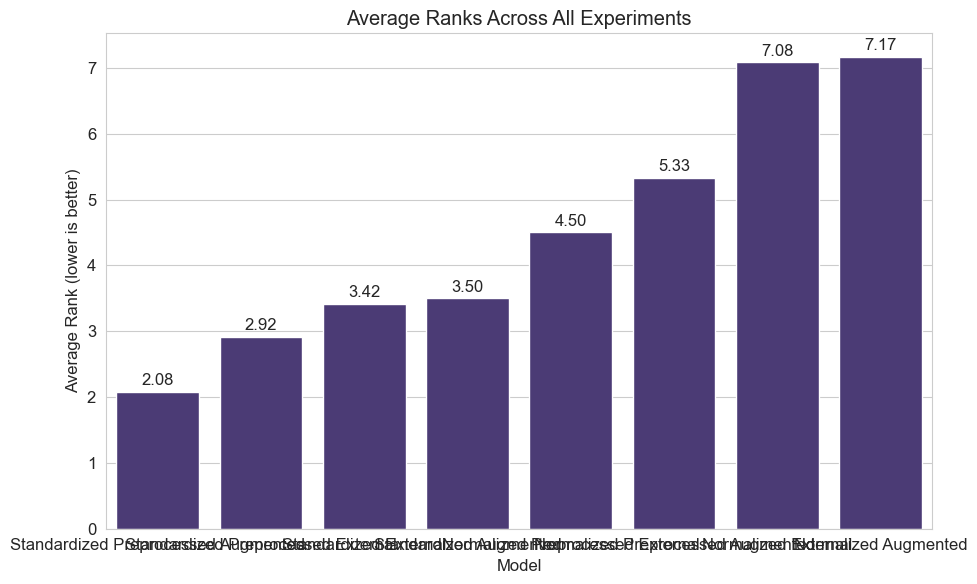

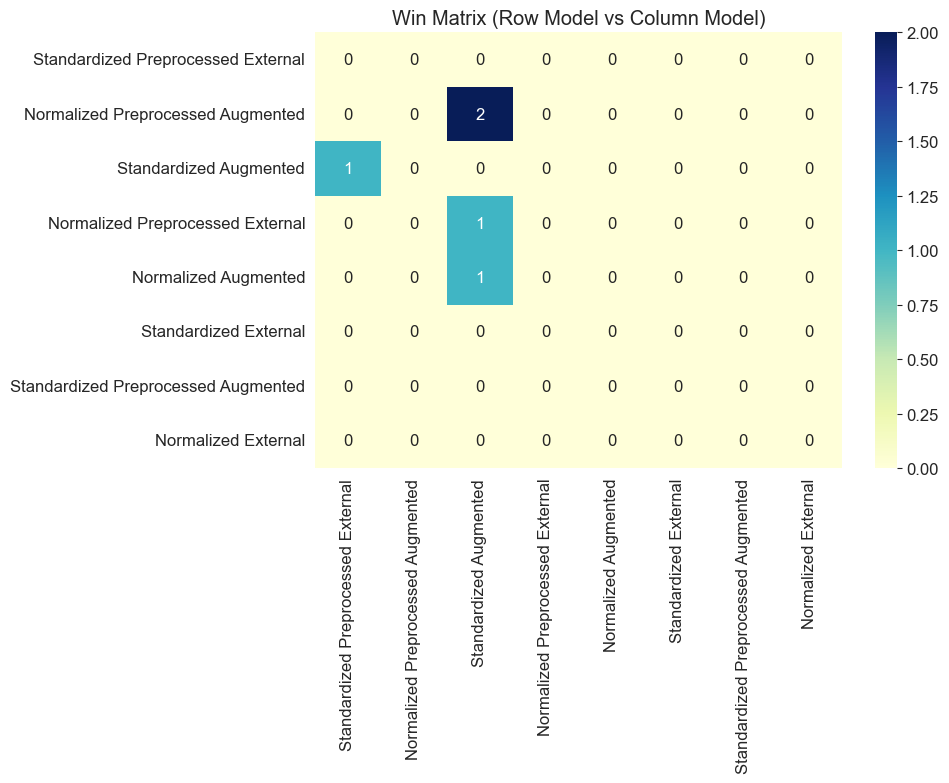

In [57]:
# Analyze all experiments
all_results = analyzer.analyze_all_experiments()

# Summarize performance
summary = analyzer.summarize_performance()

# Generate results table
results_table = analyzer.generate_results_table()
print(results_table)

# Generate detailed report
report = analyzer.generate_detailed_report()
print(report)

# Plot rank summary
analyzer.plot_rank_summary()
plt.show()

# Plot win/loss matrix
analyzer.plot_win_loss_matrix()
plt.show()